In [10]:
import os
import glob
import numpy as np

from skimage.io import imread
from skimage.transform import resize

from sklearn.model_selection import train_test_split

%matplotlib inline
import matplotlib.pyplot as plt
from matplotlib import rcParams
rcParams['figure.figsize'] = (14, 15)

import torch
from models import UNet

from torch.autograd import Variable
import torch.nn.functional as F

In [11]:
net = UNet()
net.load_state_dict(torch.load('../models-pytorch/best_UNet_single_nuclei_lossless_augmentations_std-fn.pth'))
net.cpu().eval()

UNet(
  (conv_1a): Conv2d (3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_1b): Conv2d (16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool_1): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_2a): Conv2d (16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_2b): Conv2d (32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool_2): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_3a): Conv2d (32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_3b): Conv2d (64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool_3): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_4a): Conv2d (64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv_4b): Conv2d (128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (max_pool_4): MaxPool2d(kernel_size=(2, 2), stride=(2, 2), dilation=(1, 1))
  (conv_5a): Conv2d (128, 256, kernel_si

/home/florian/anaconda3/lib/python3.5/site-packages/torch/nn/modules/upsampling.py:180: UserWarning: nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.
  warnings.warn("nn.UpsamplingBilinear2d is deprecated. Use nn.Upsample instead.")


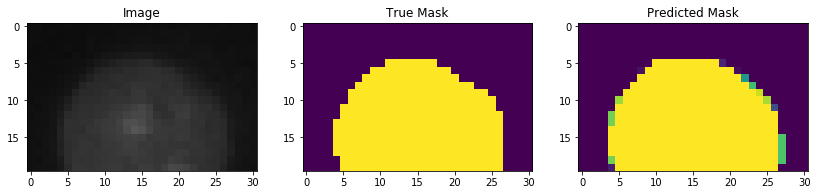

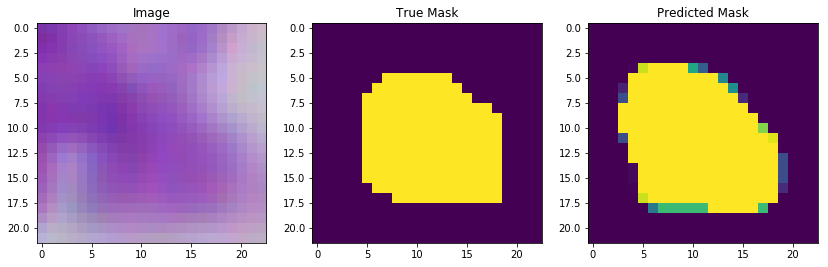

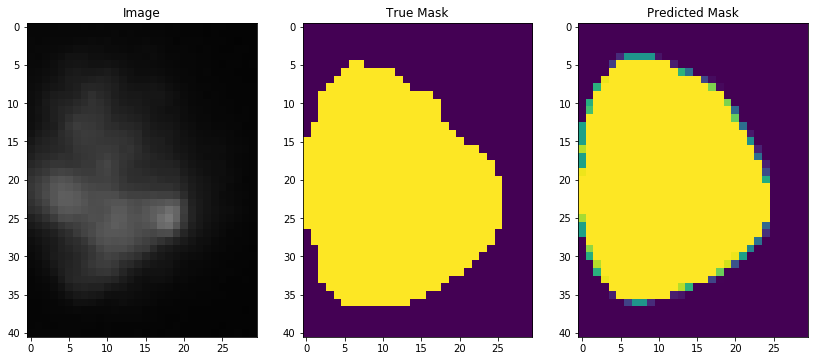

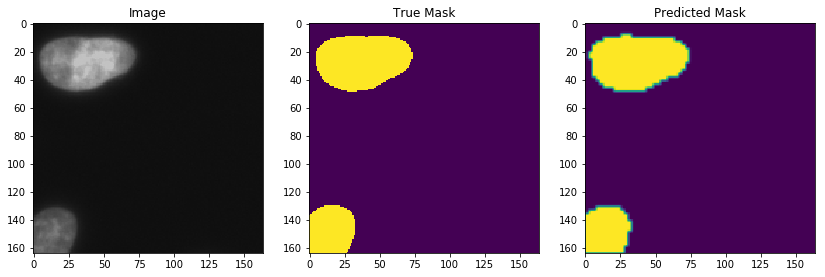

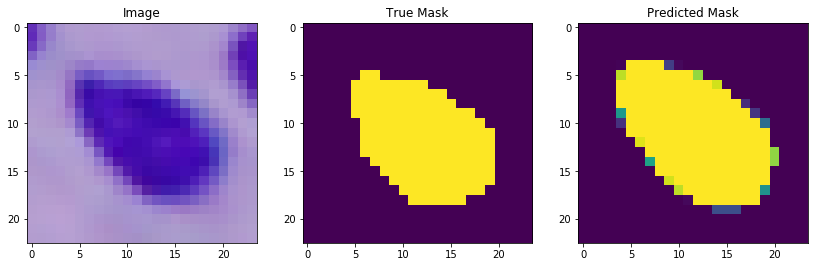

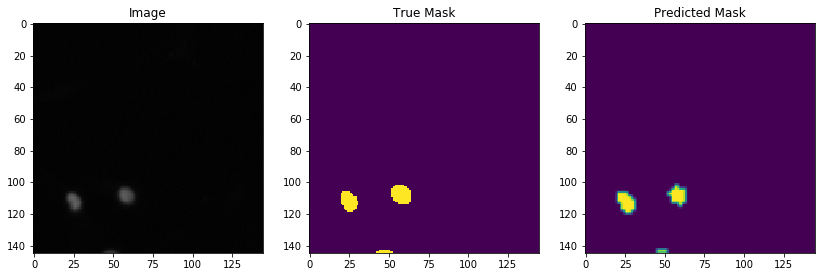

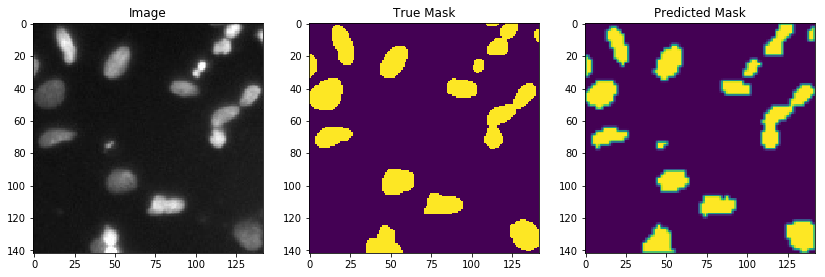

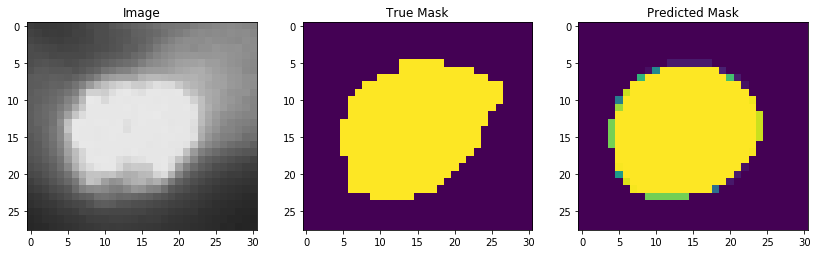

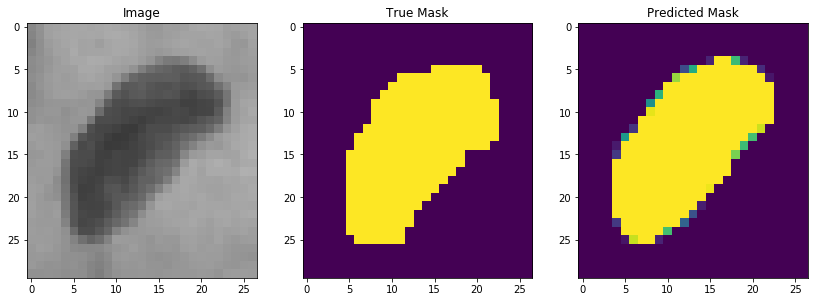

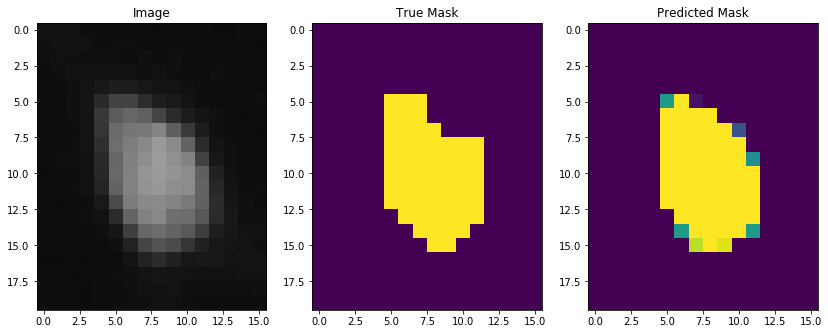

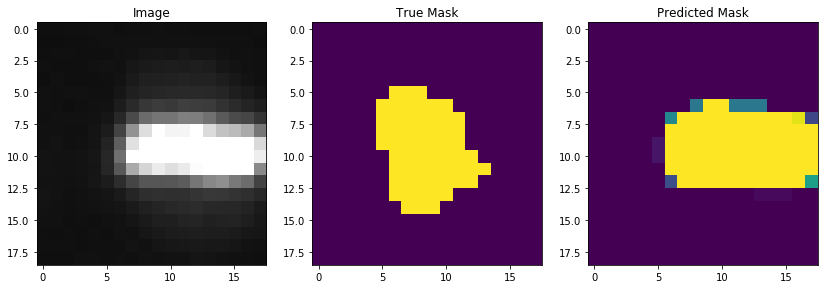

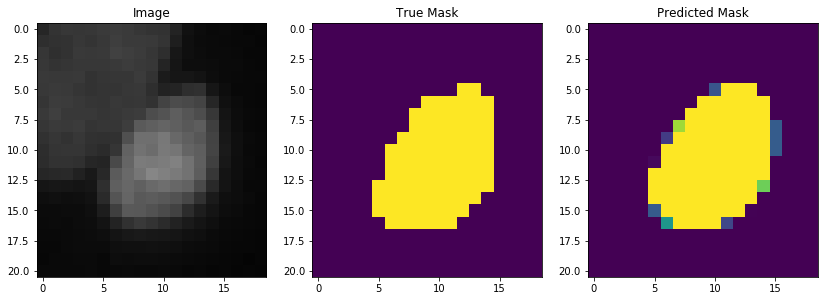

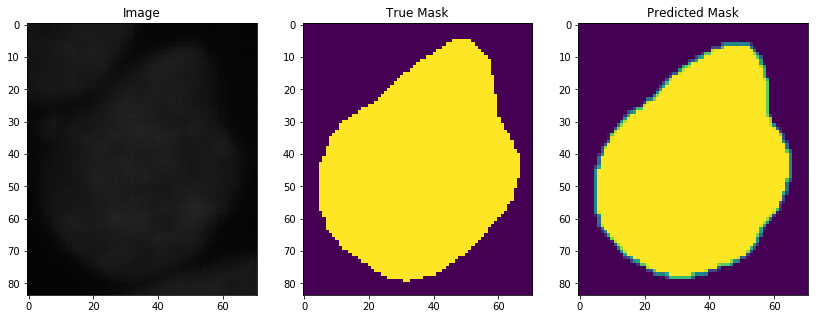

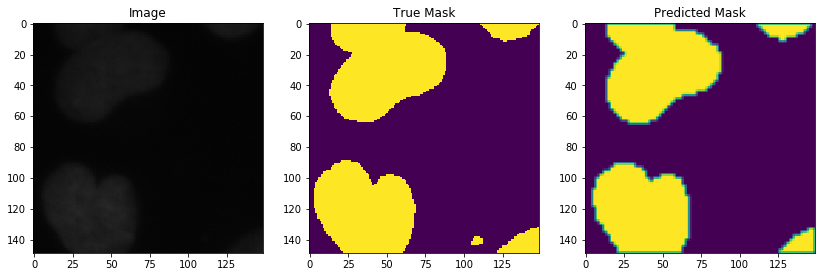

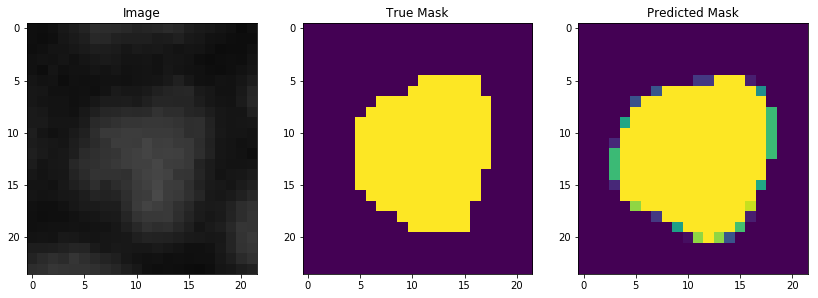

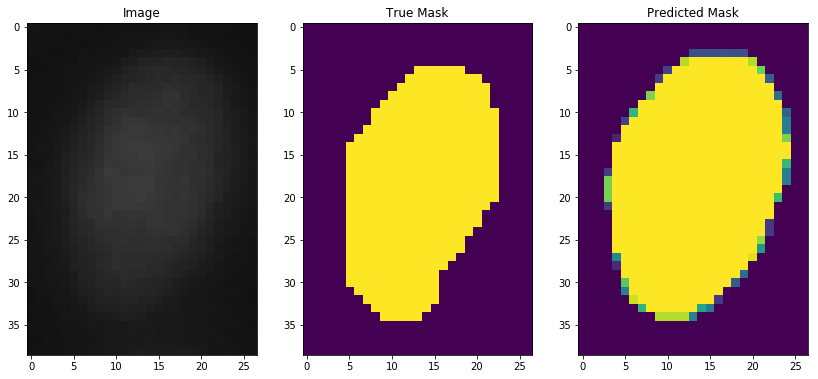

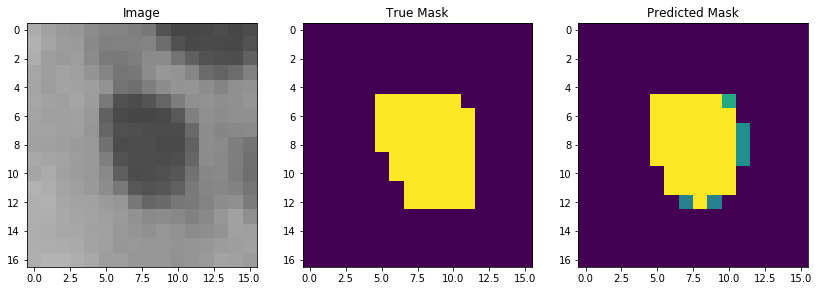

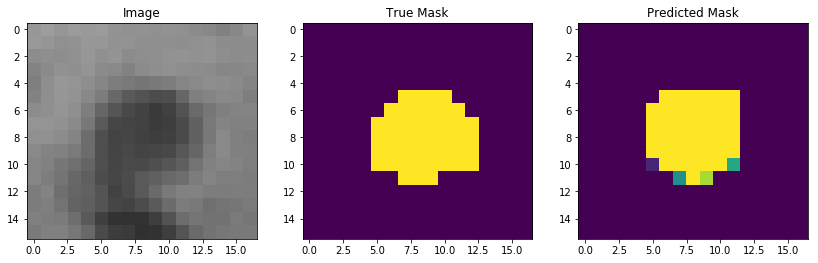

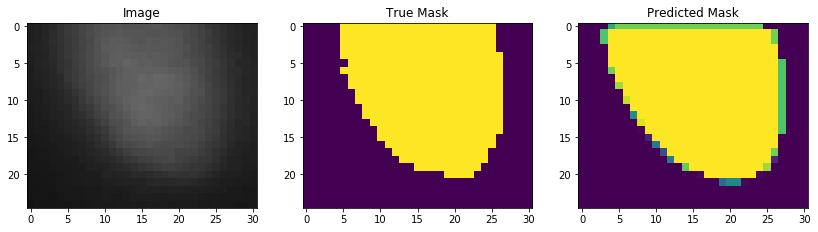

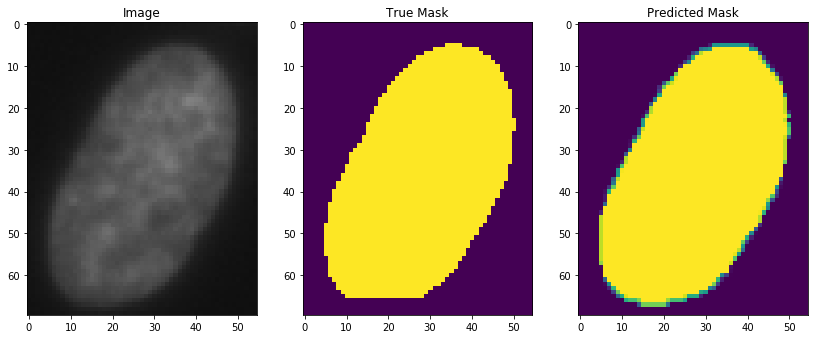

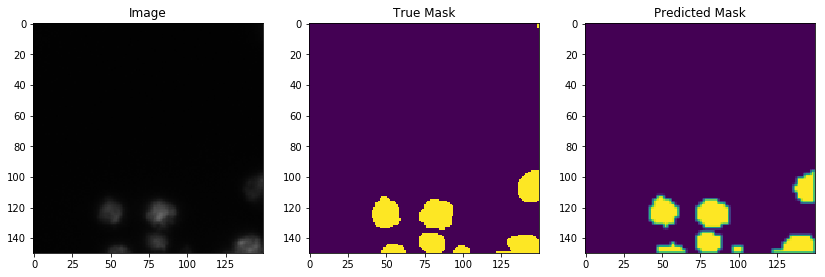

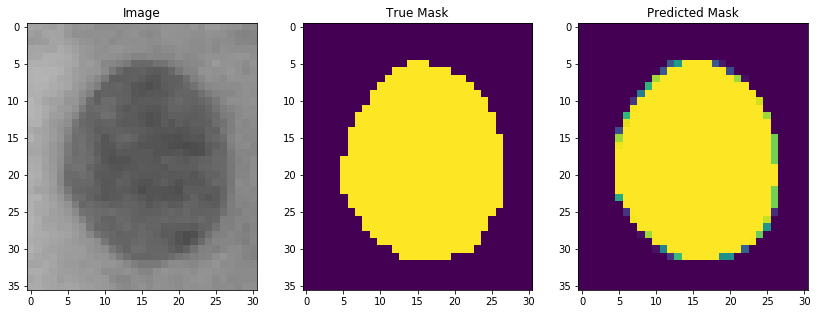

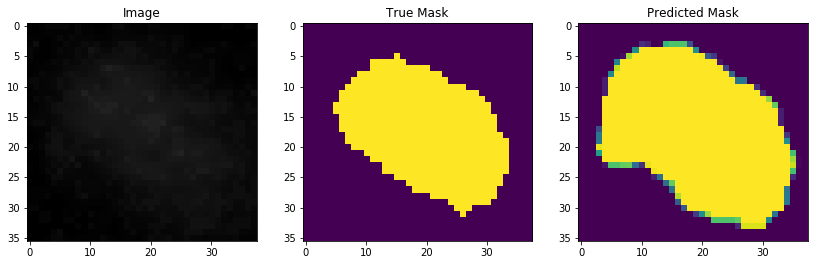

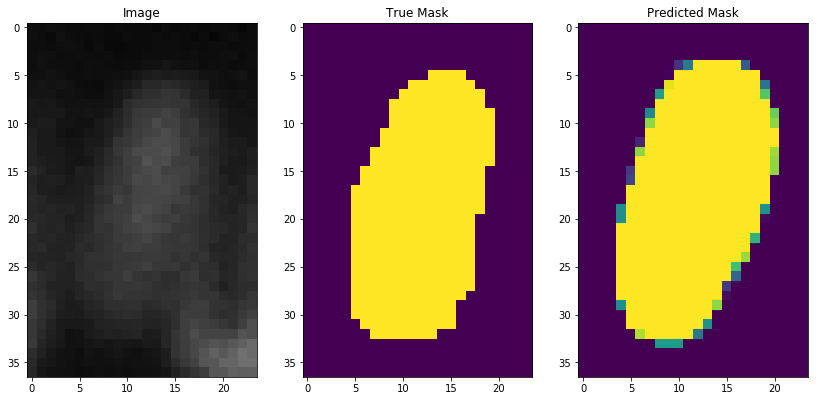

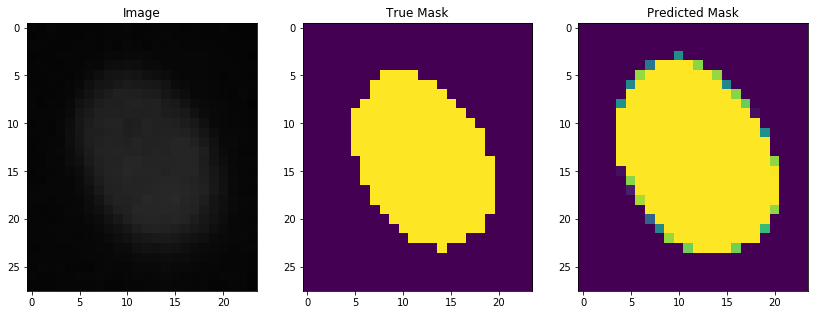

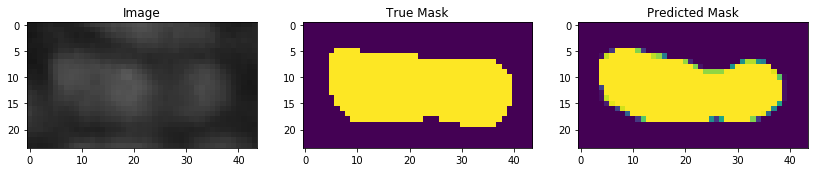

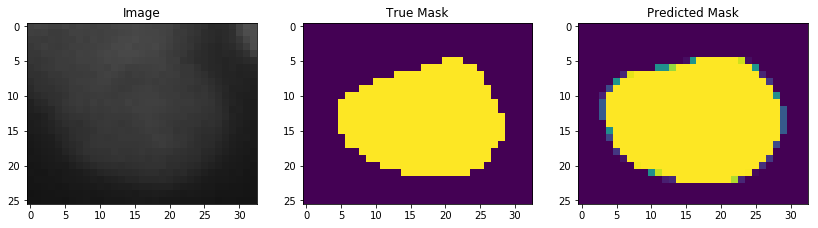

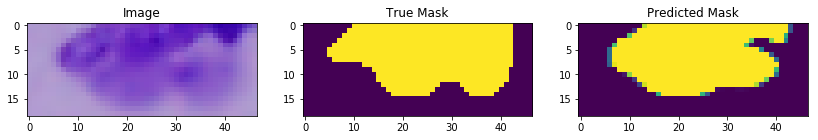

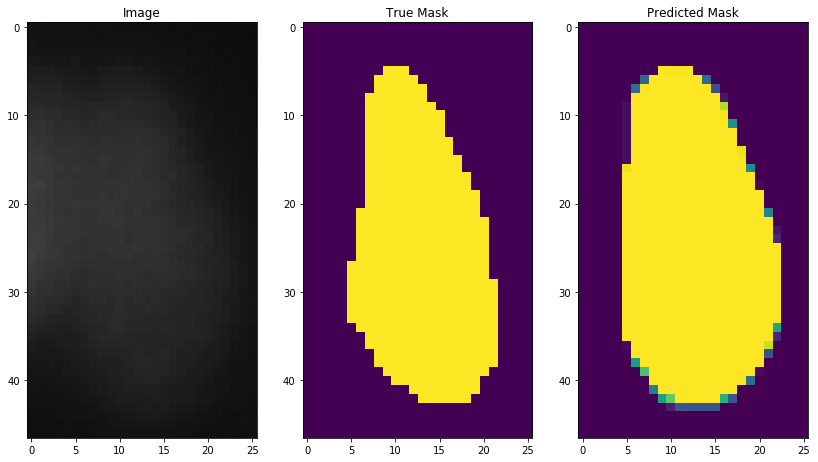

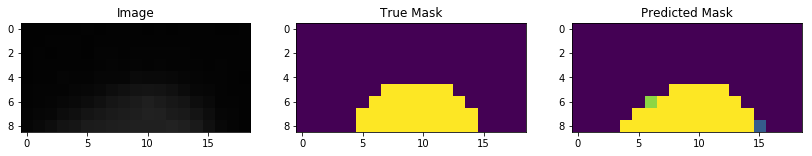

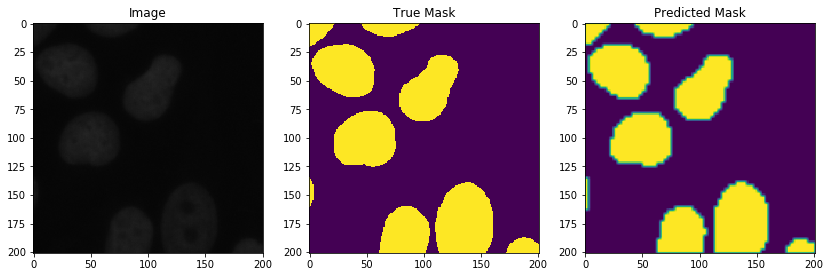

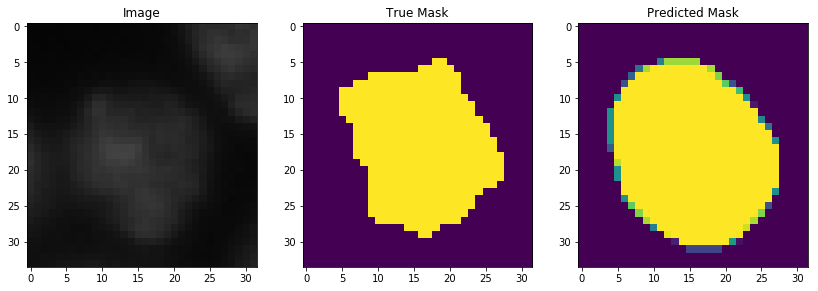

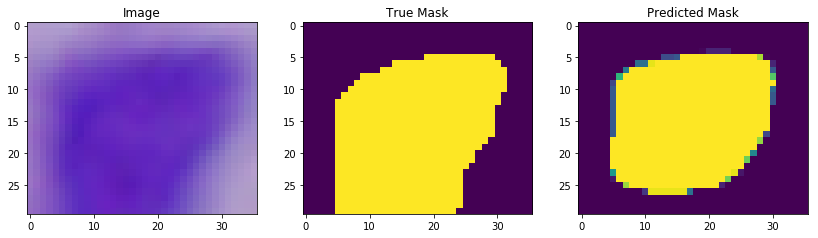

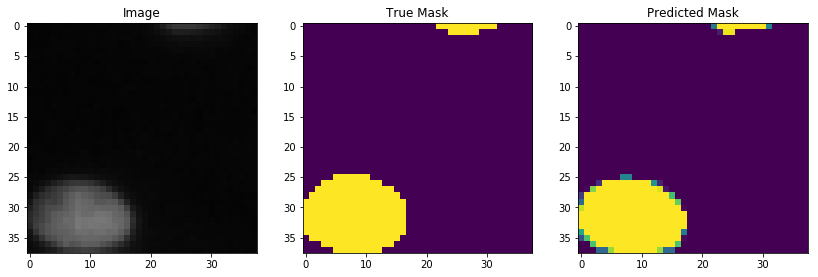

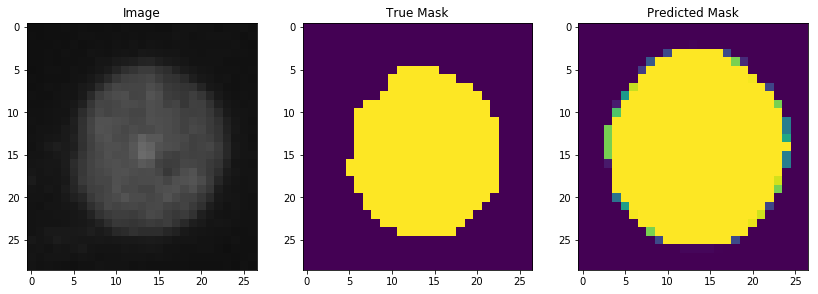

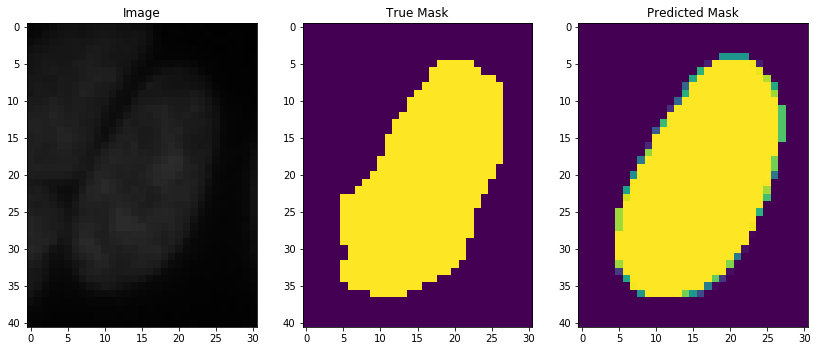

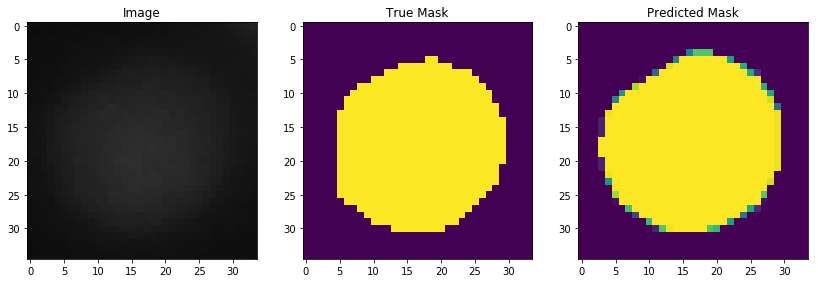

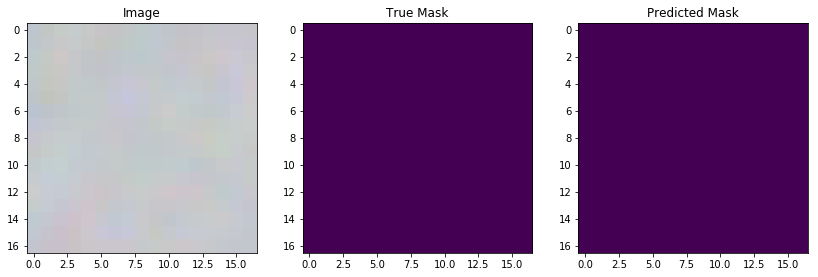

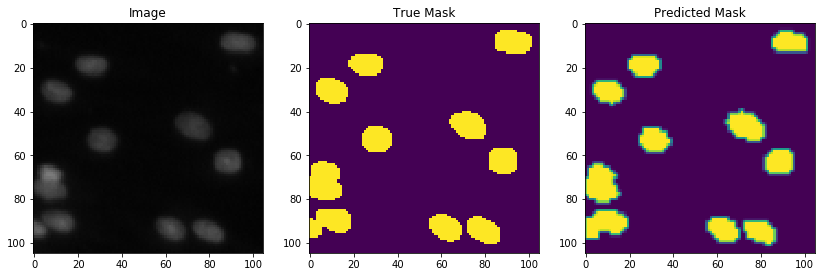

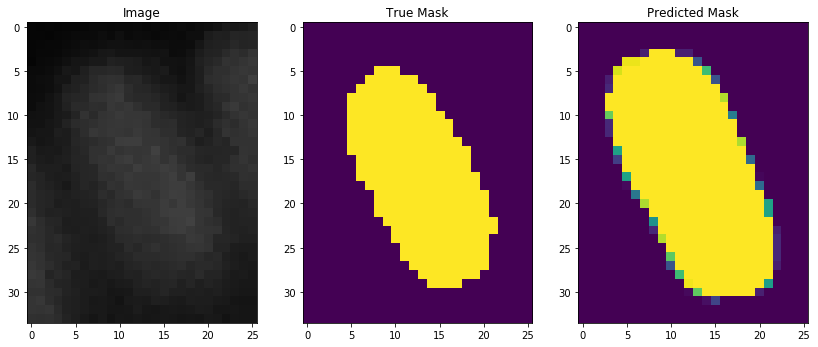

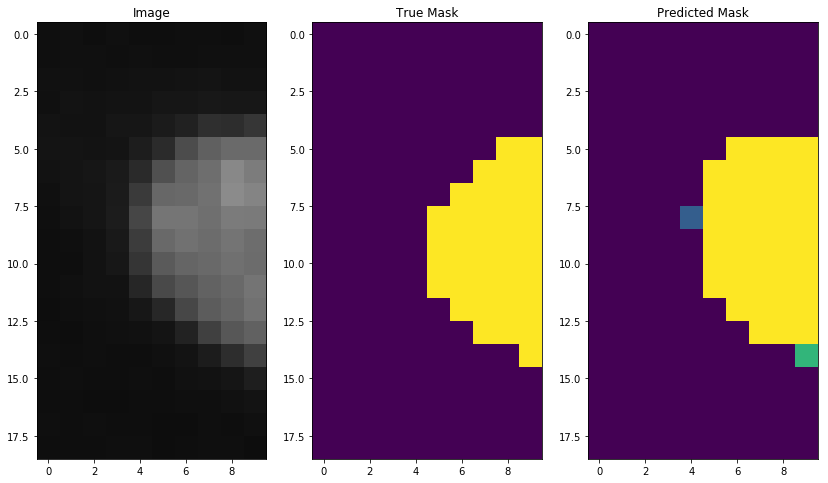

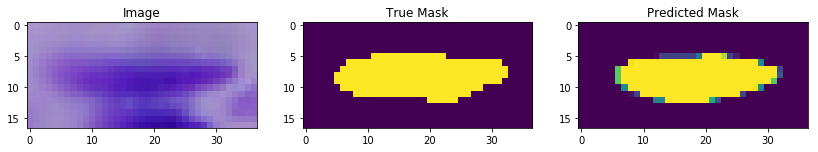

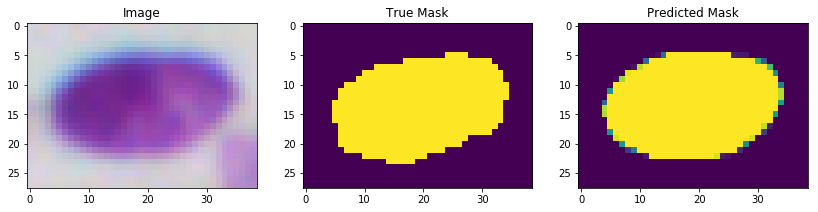

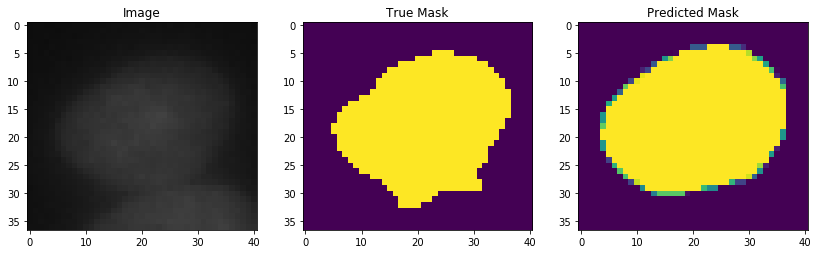

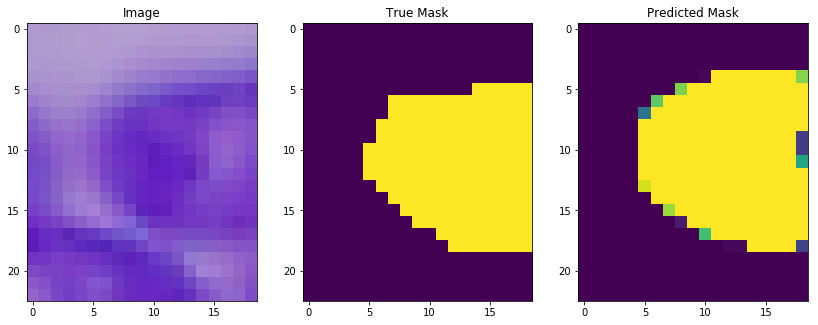

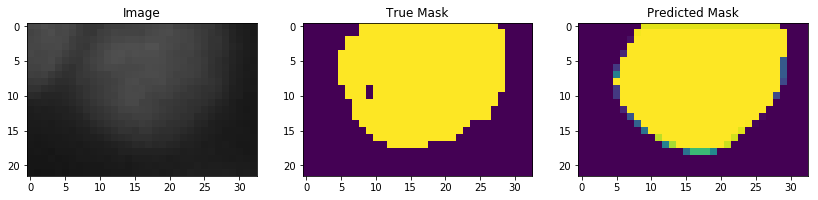

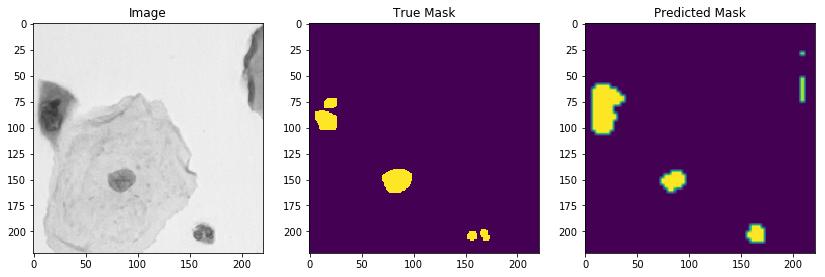

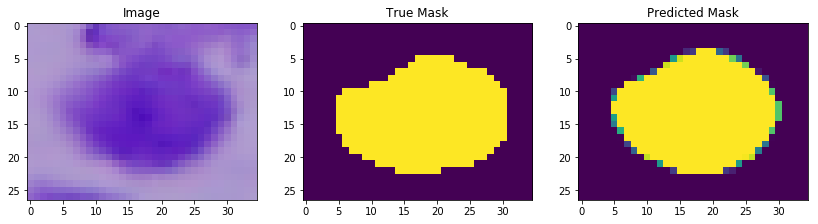

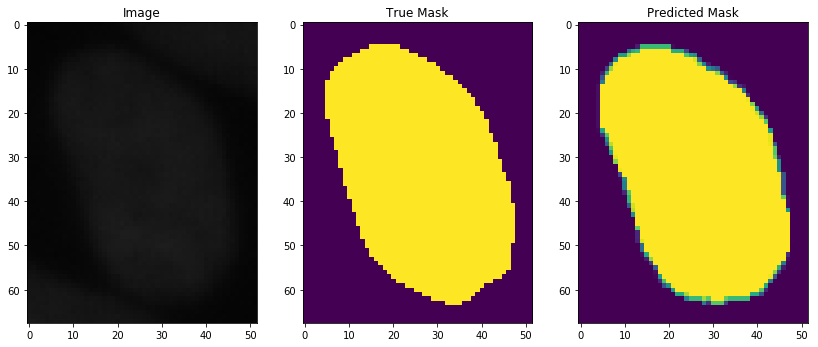

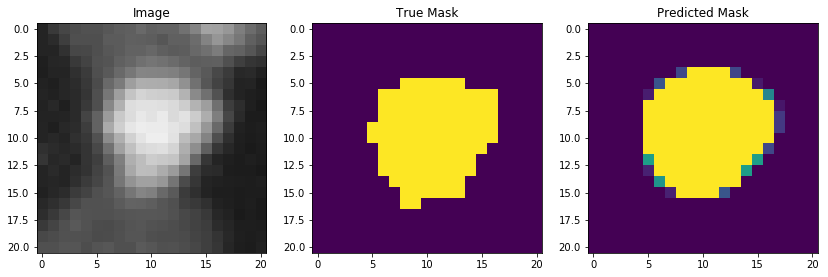

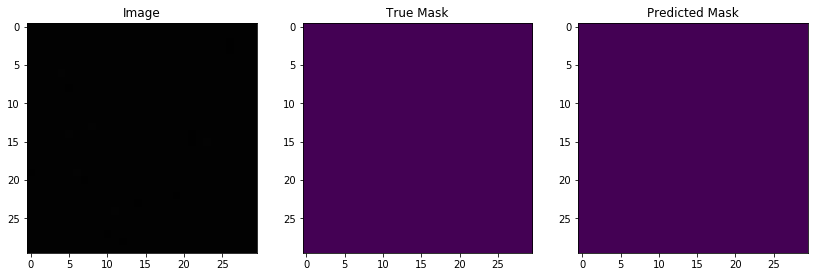

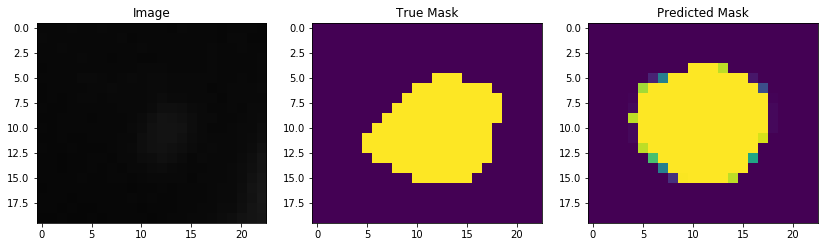

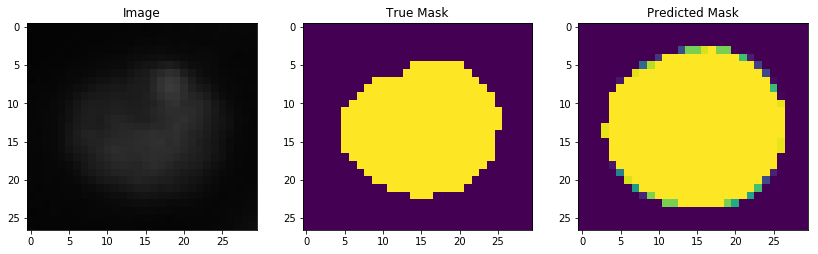

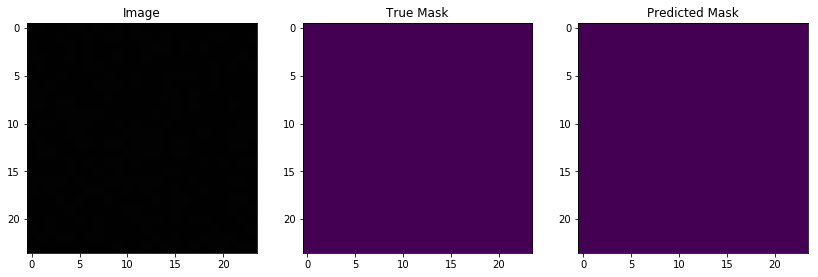

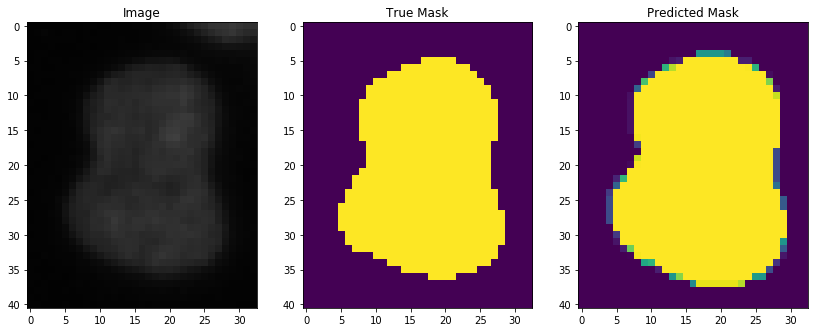

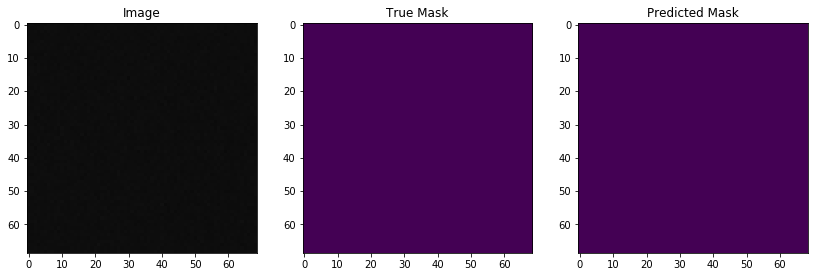

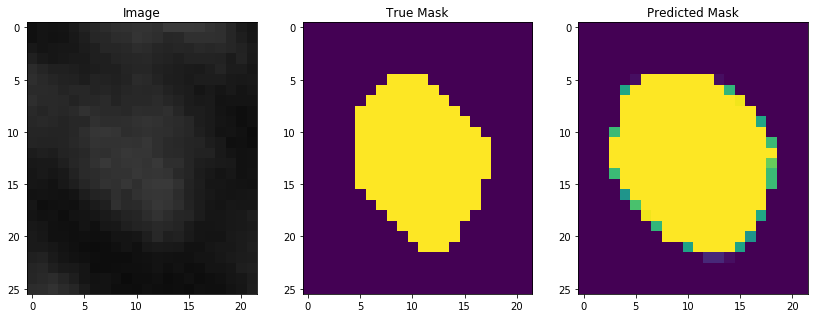

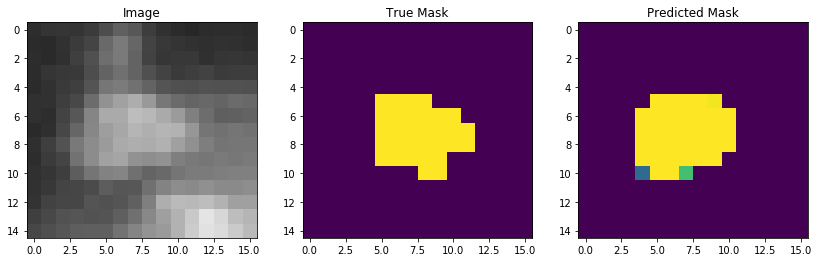

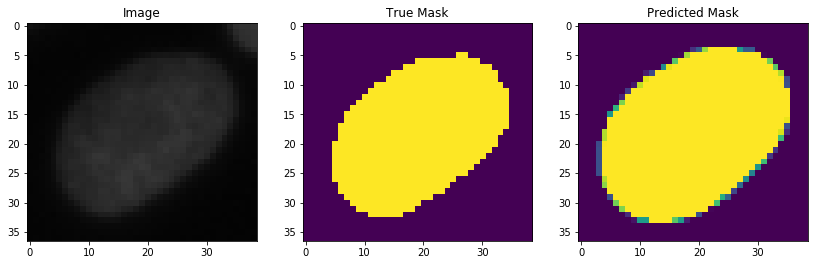

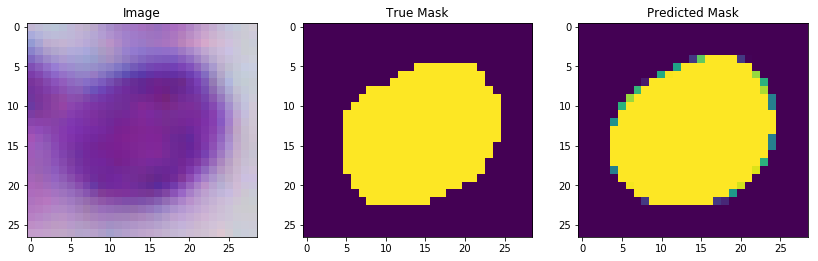

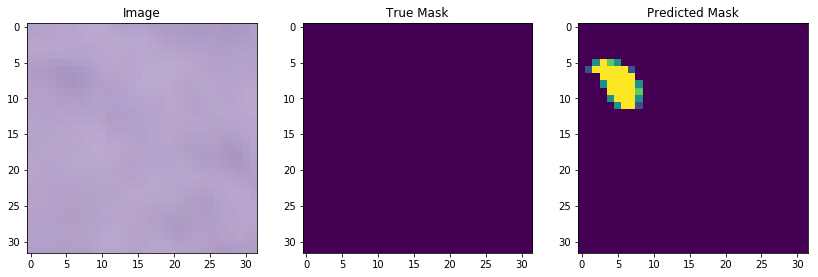

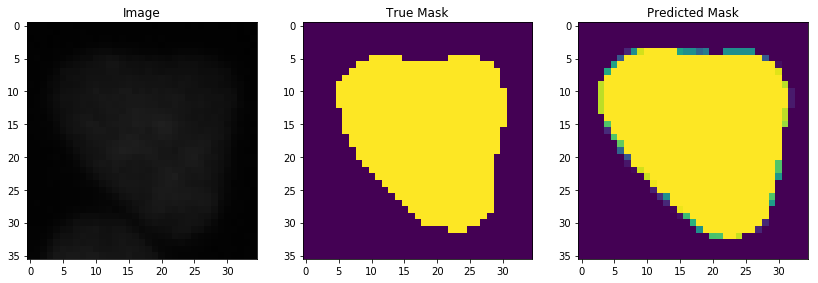

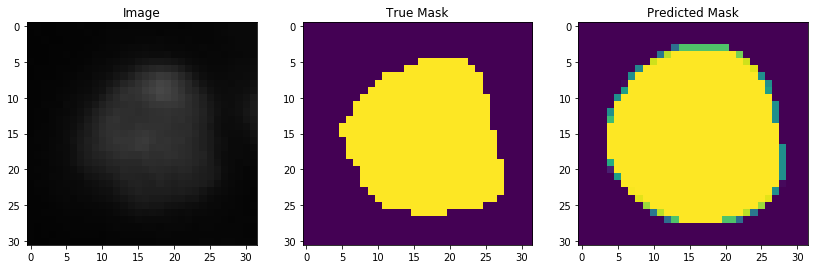

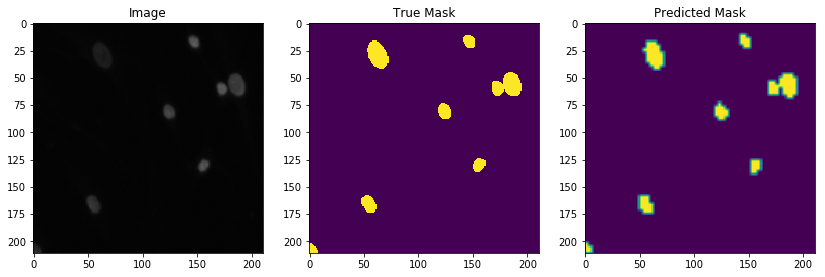

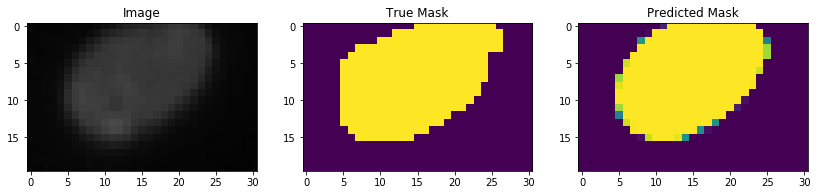

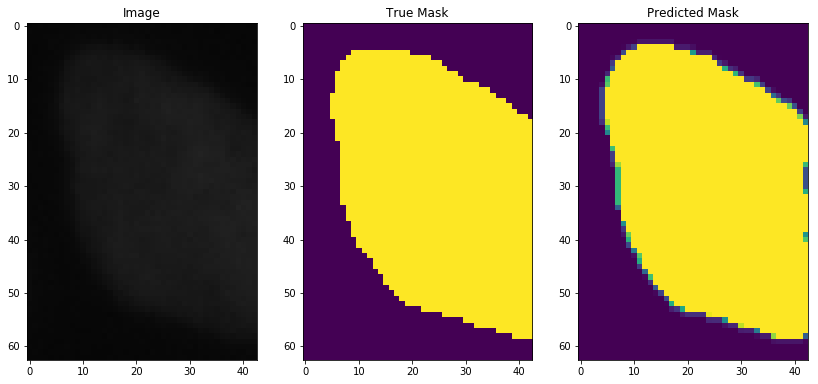

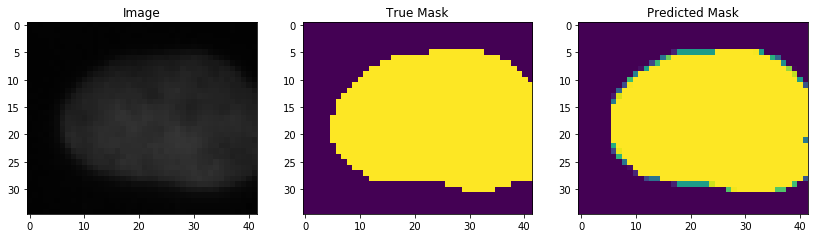

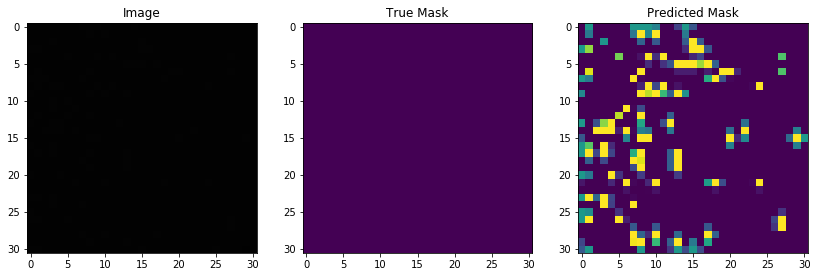

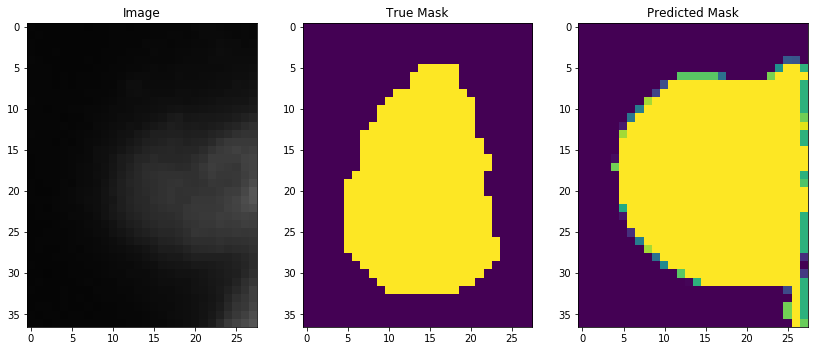

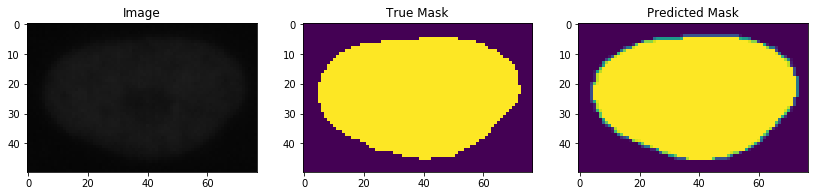

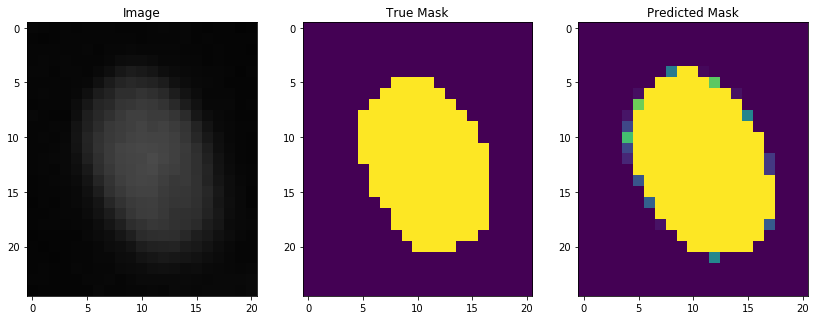

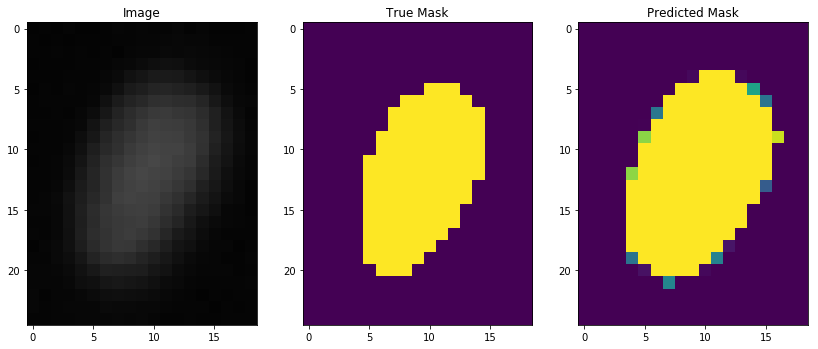

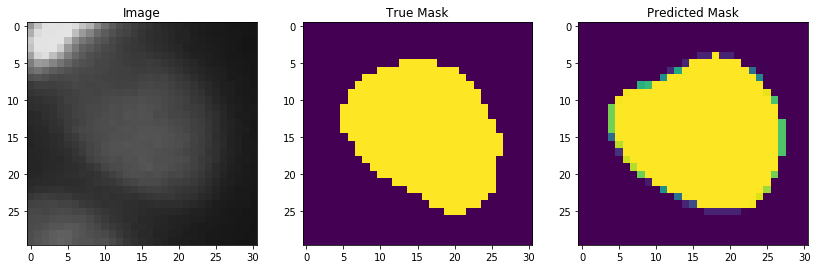

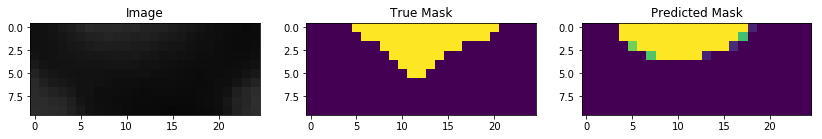

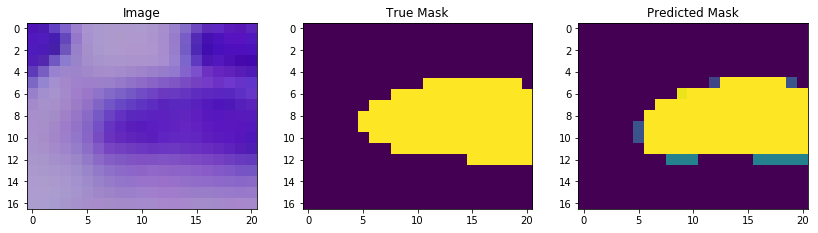

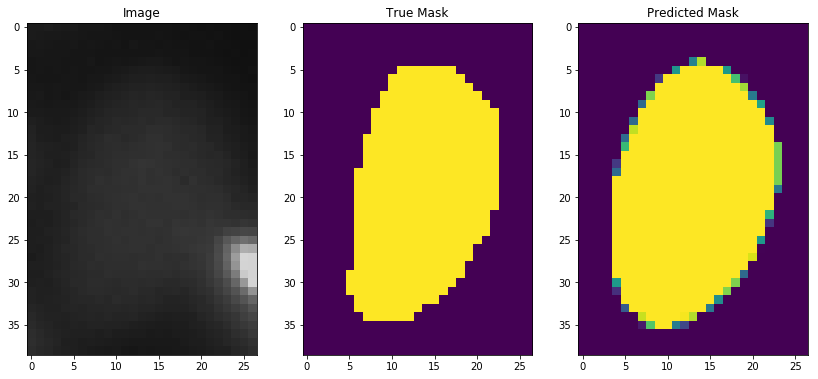

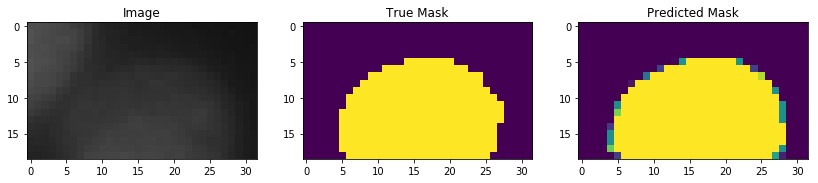

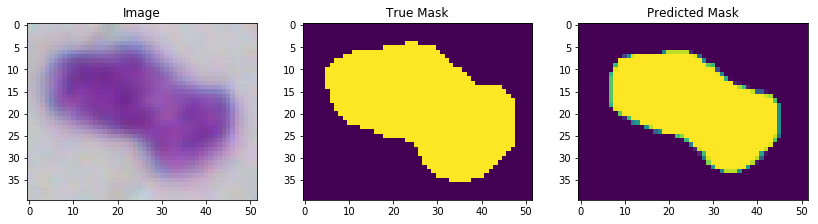

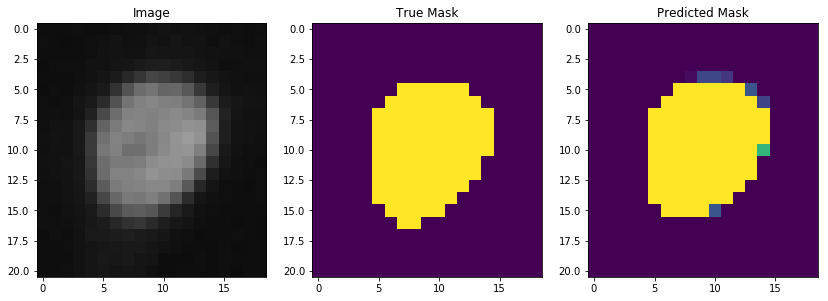

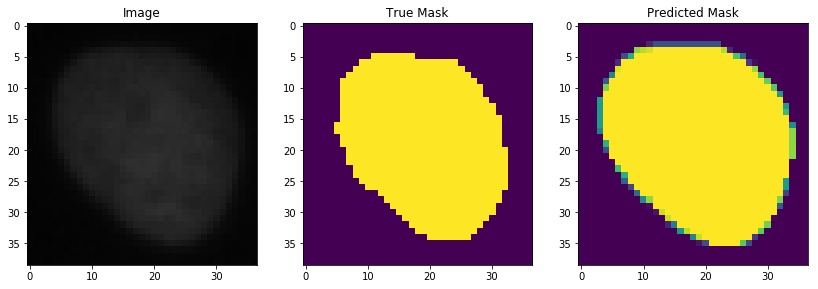

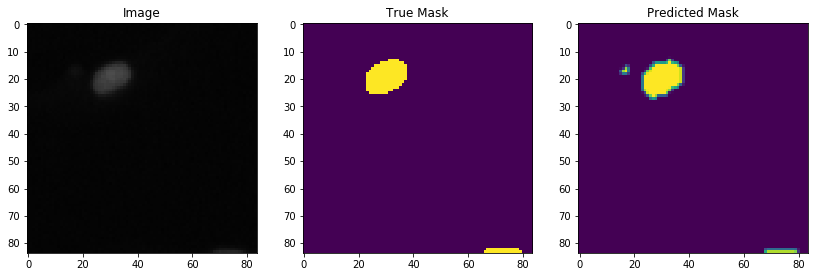

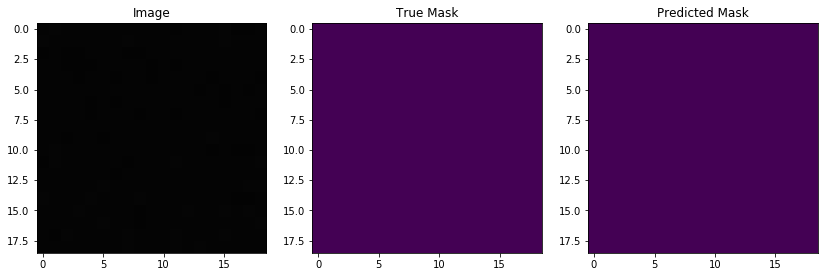

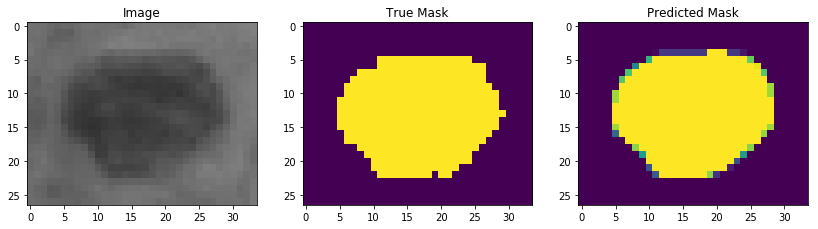

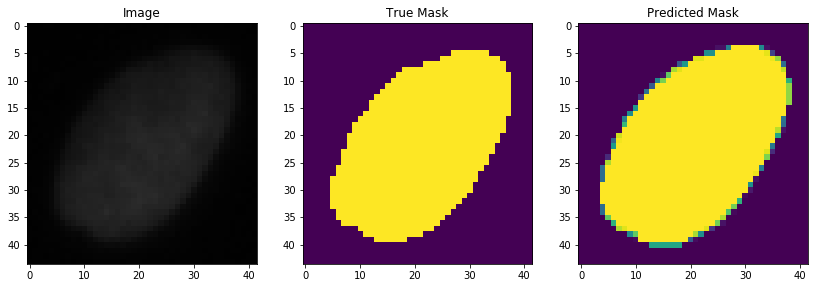

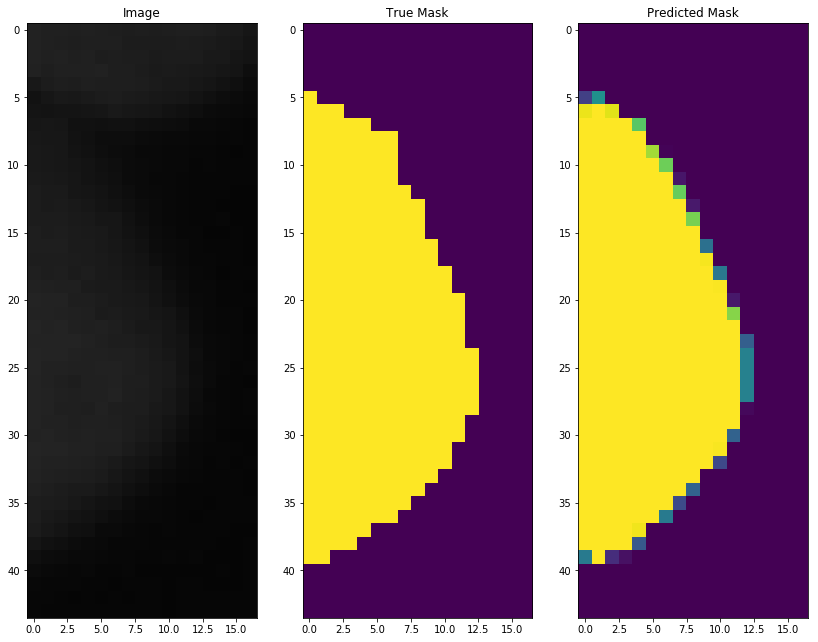

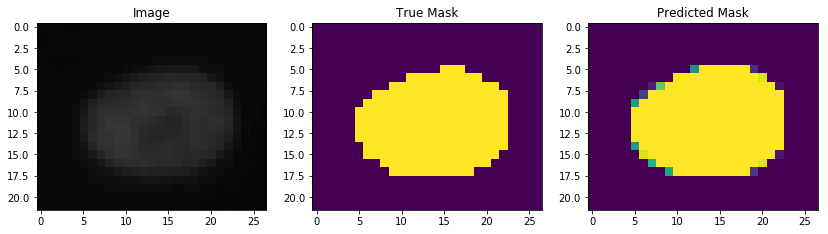

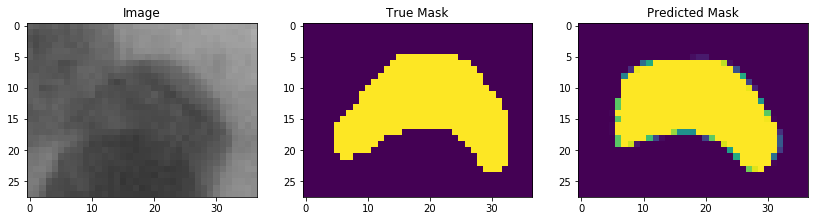

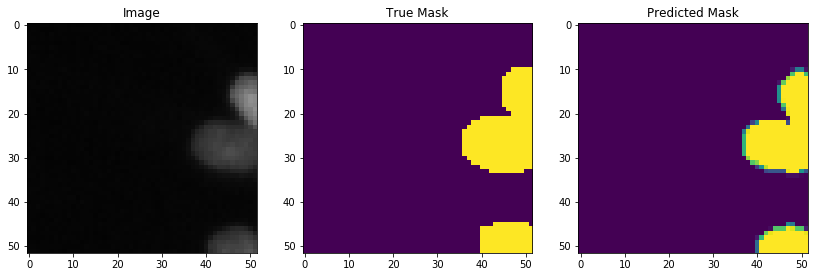

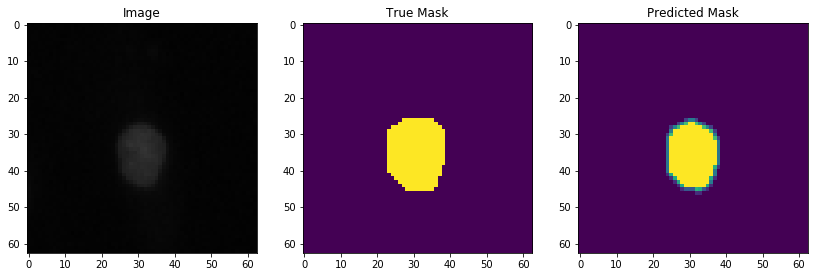

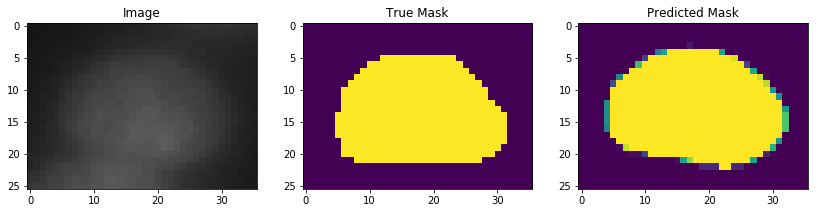

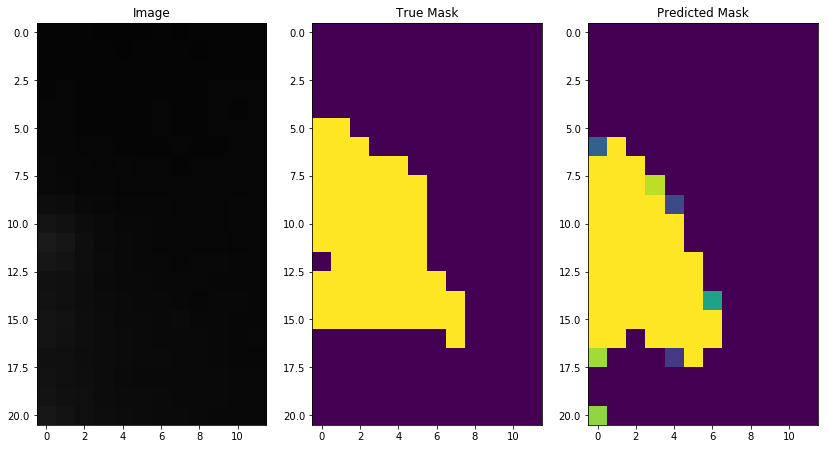

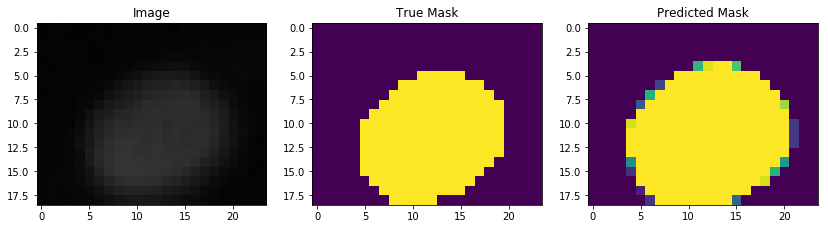

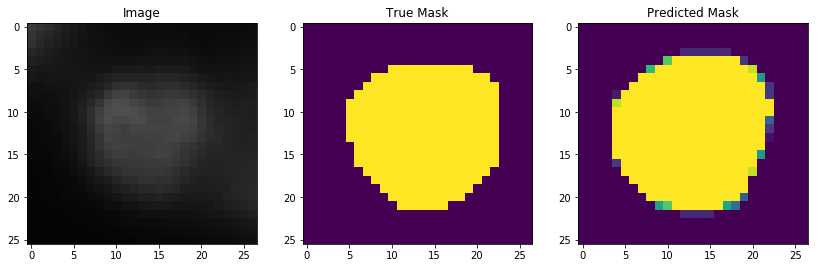

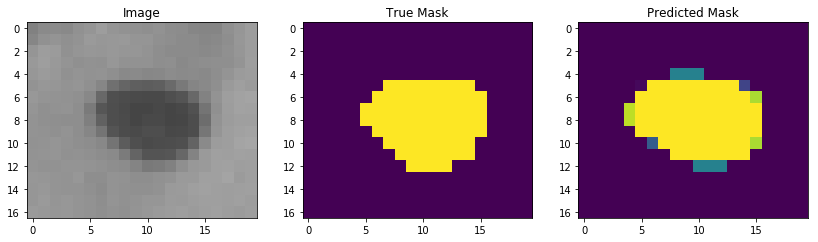

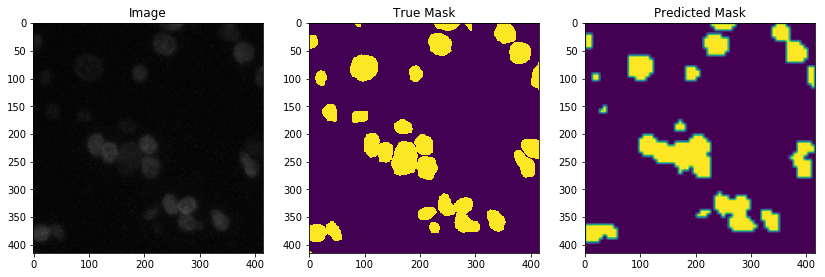

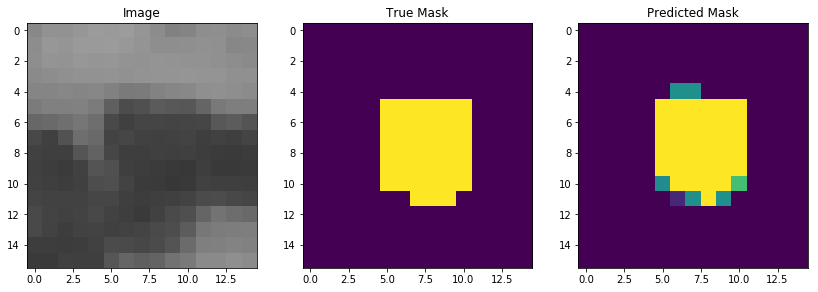

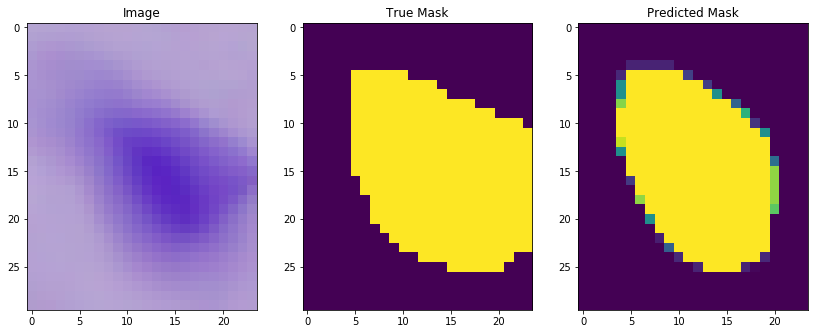

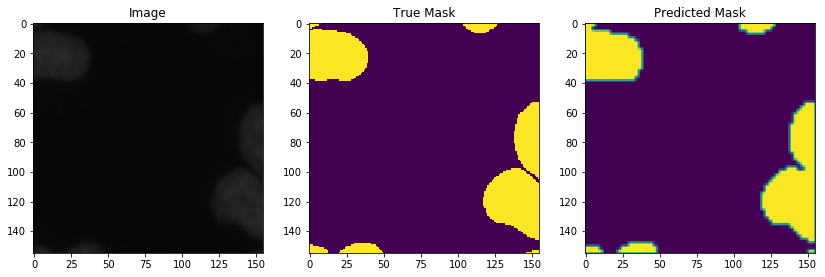

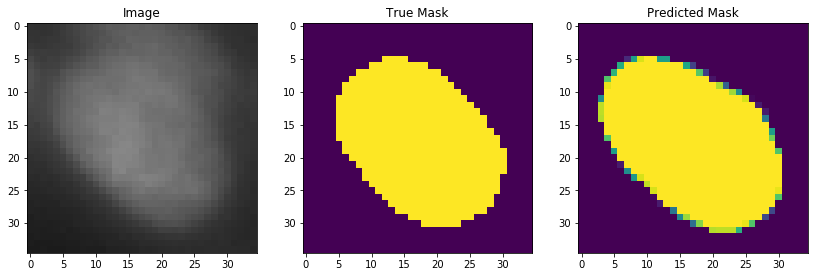

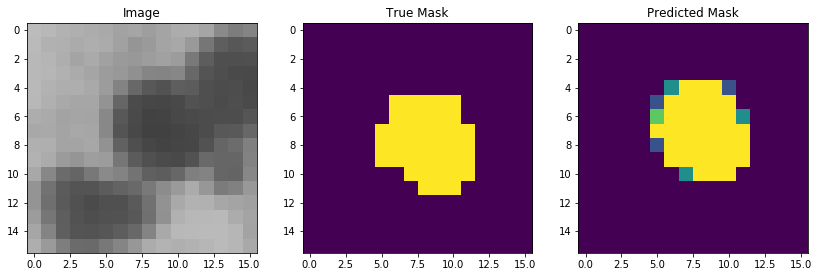

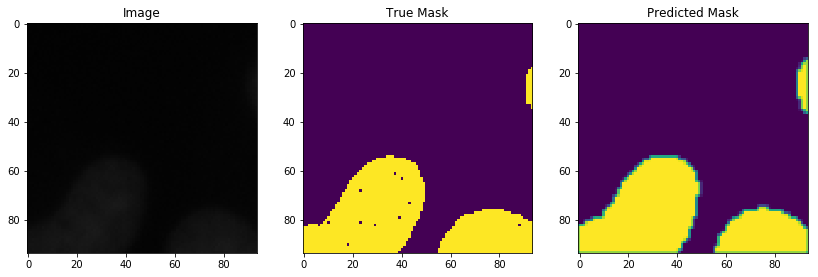

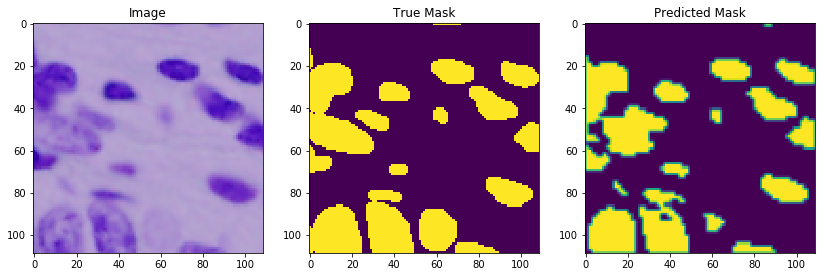

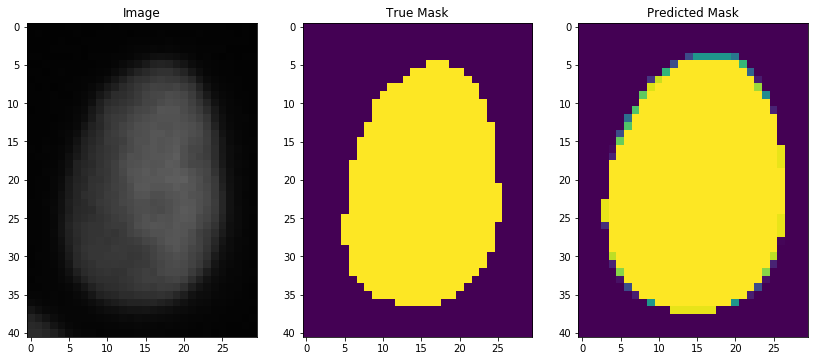

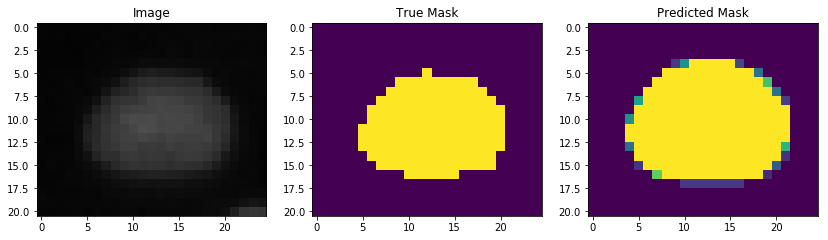

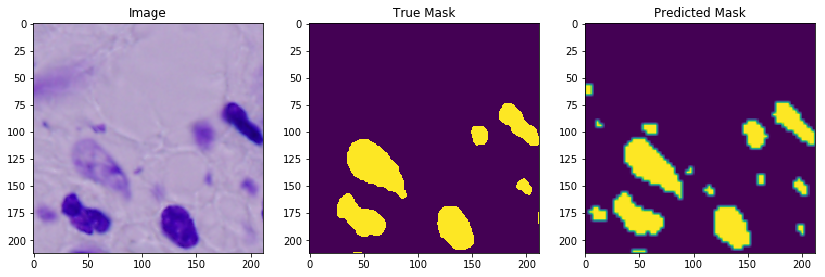

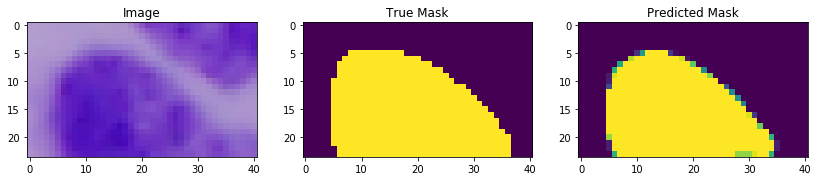

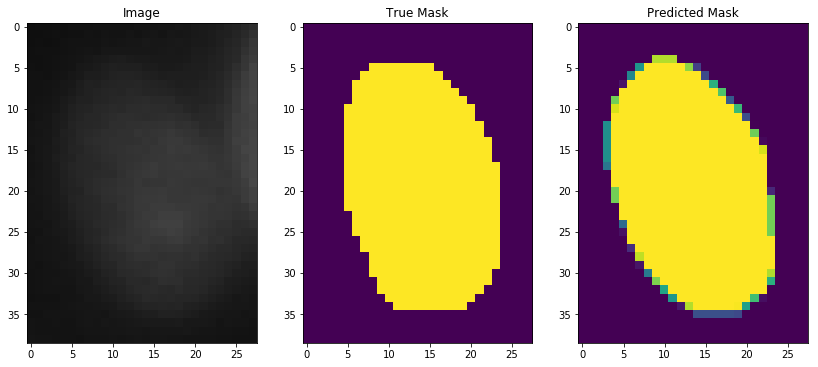

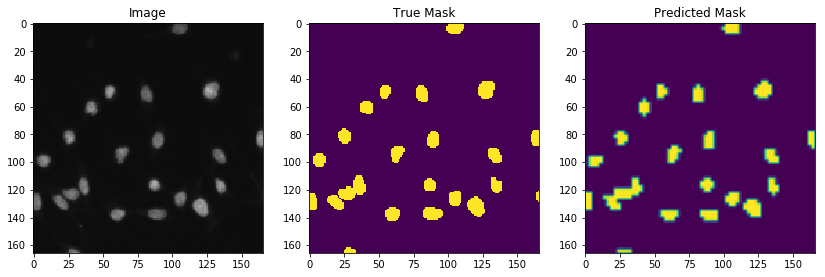

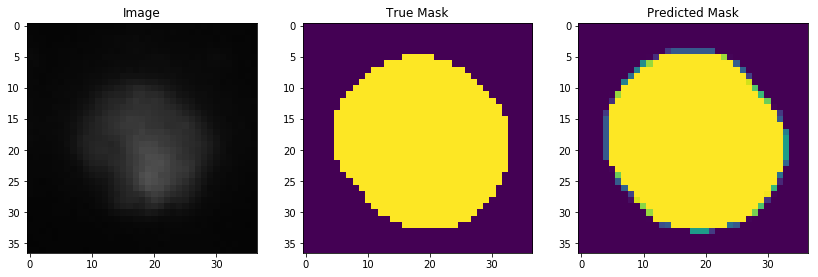

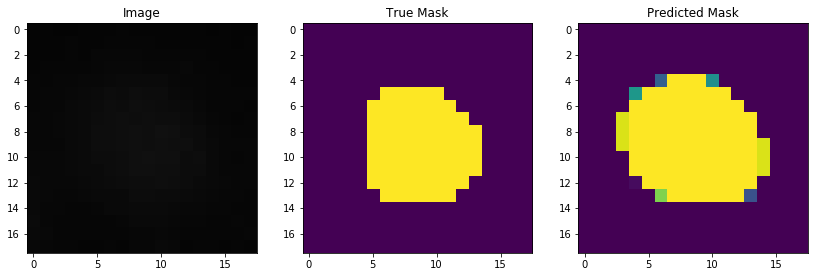

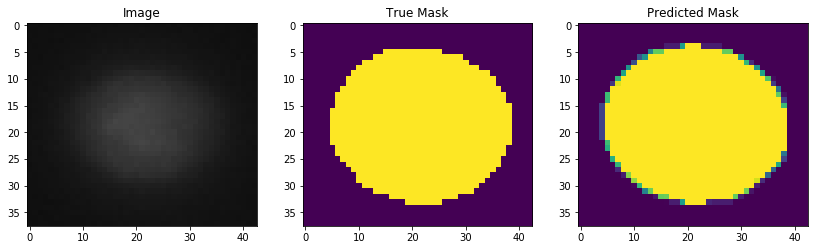

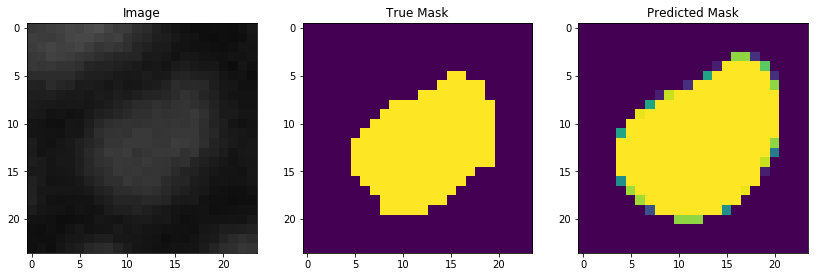

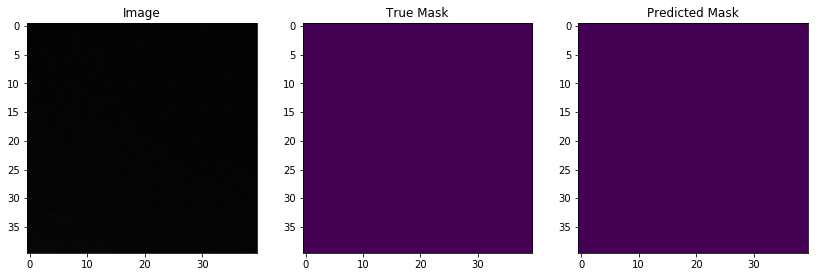

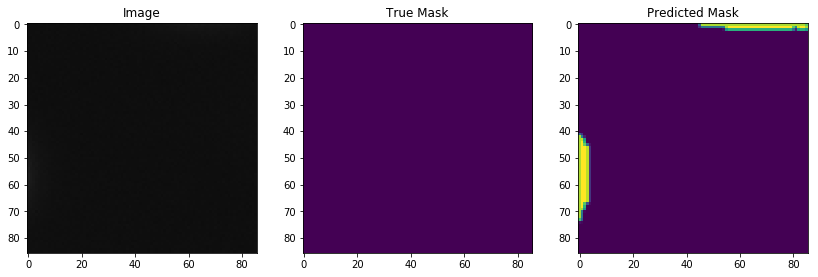

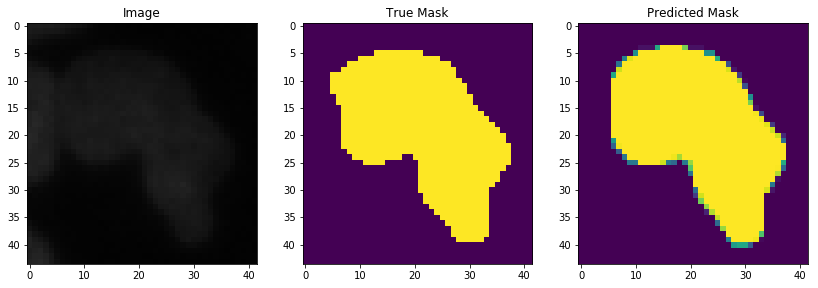

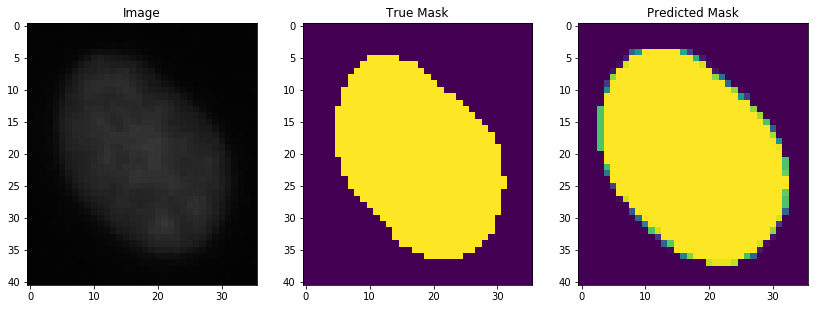

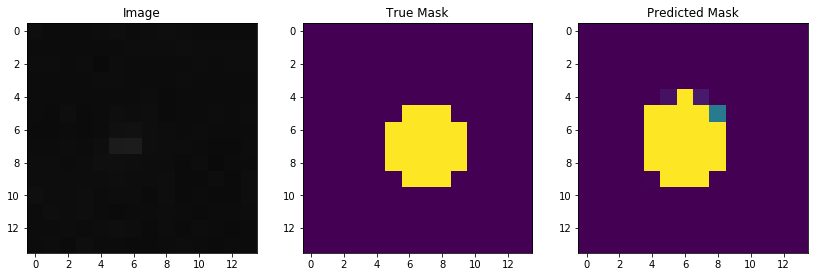

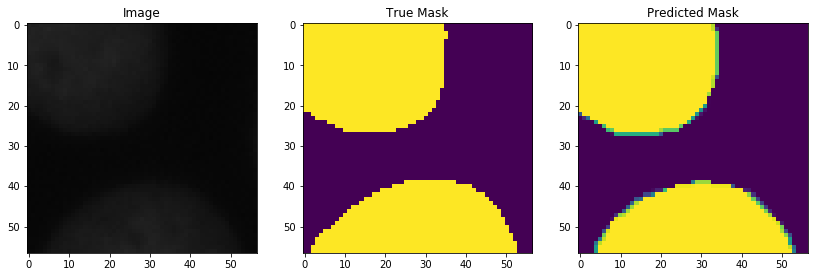

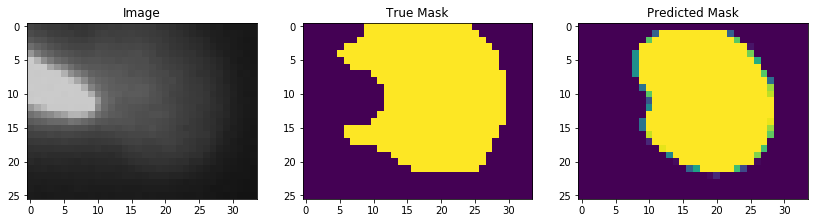

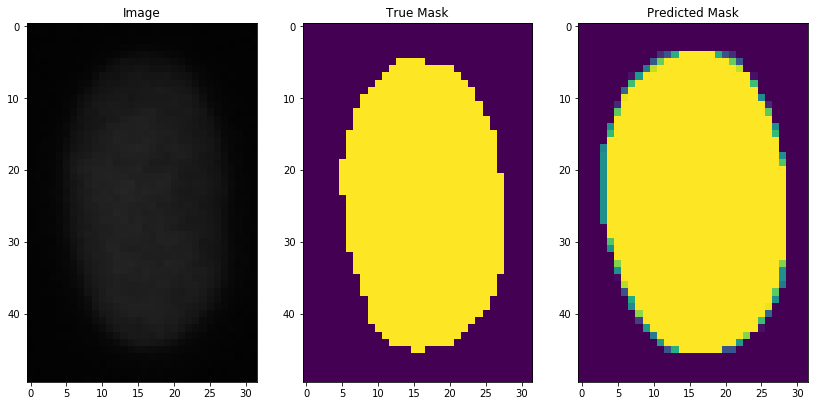

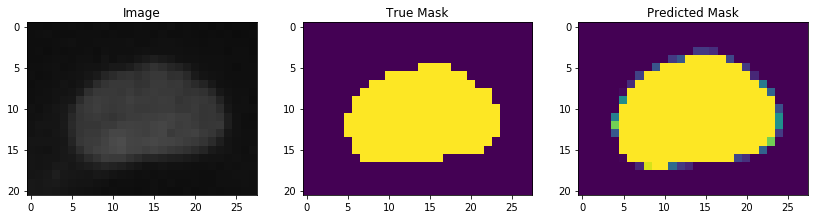

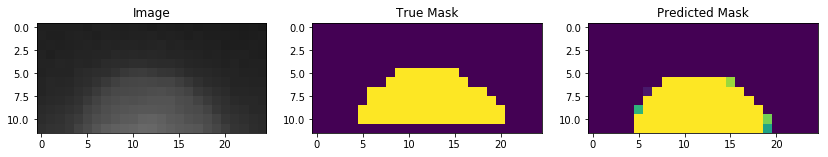

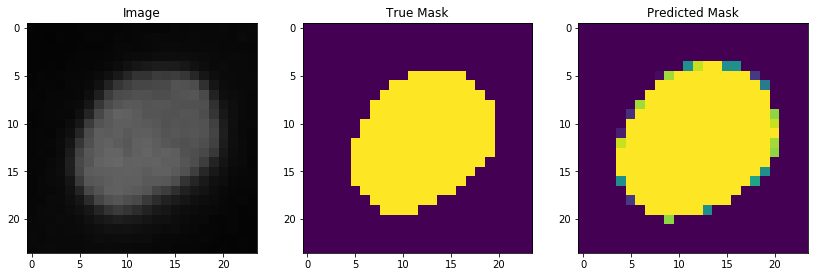

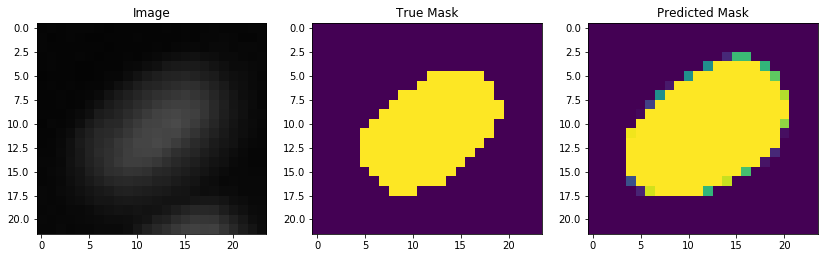

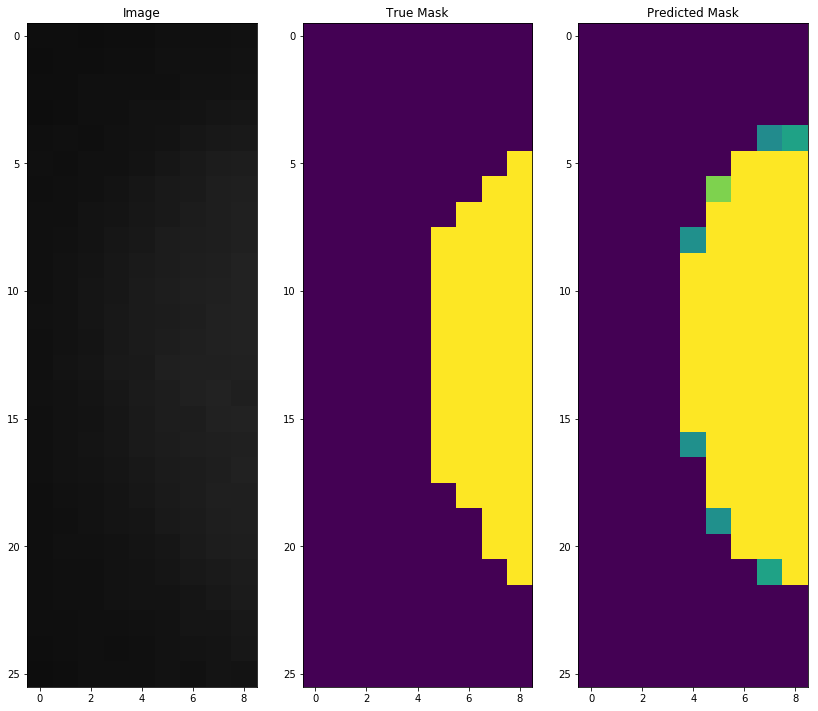

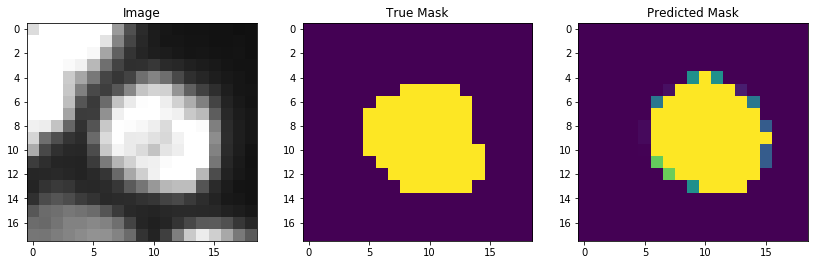

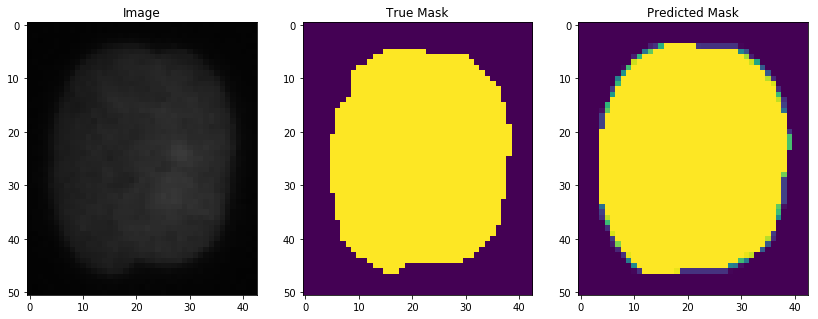

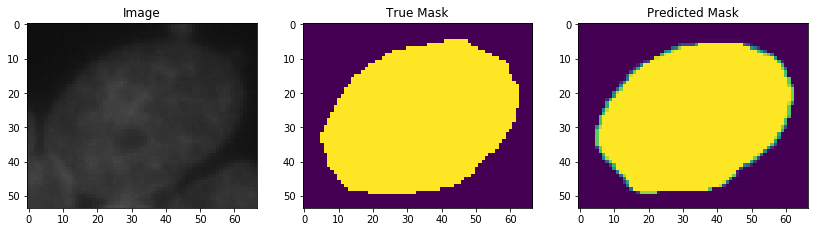

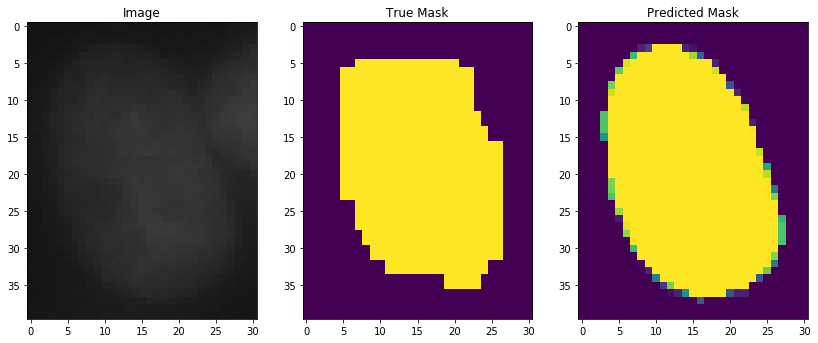

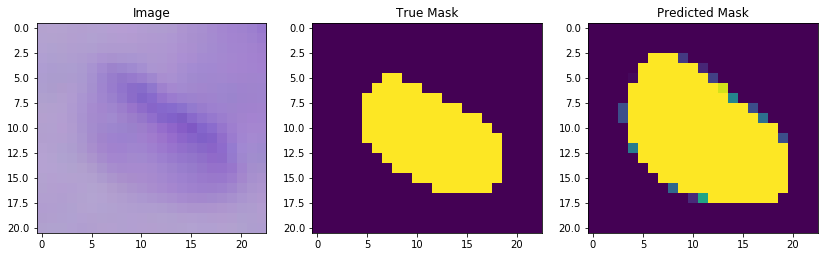

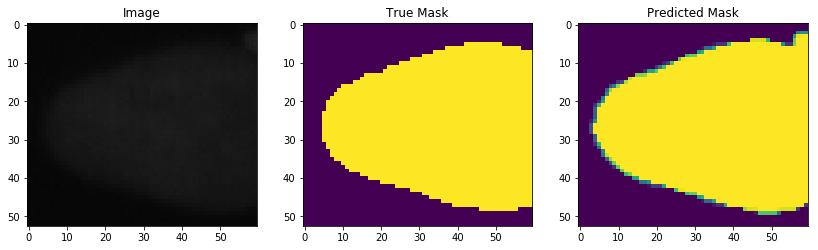

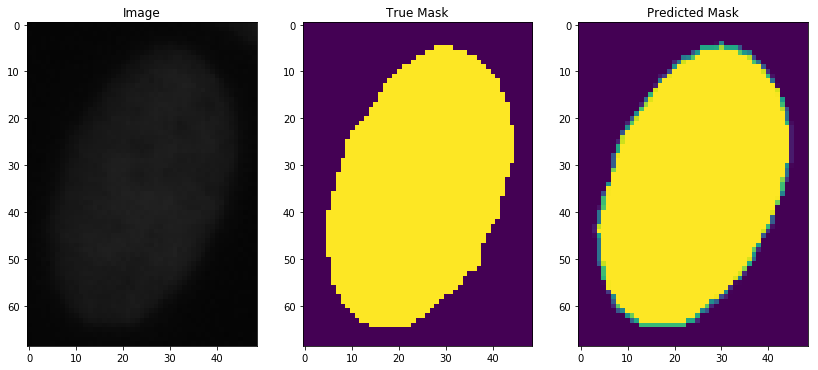

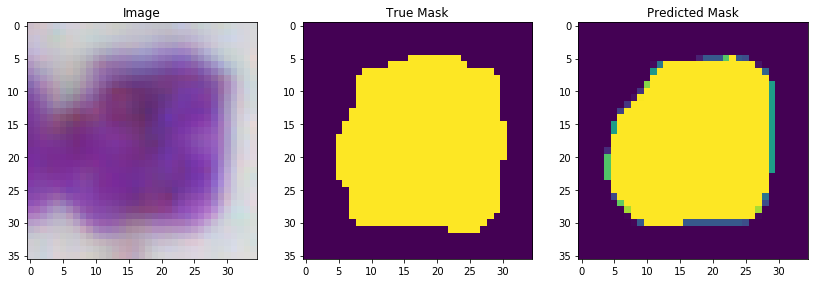

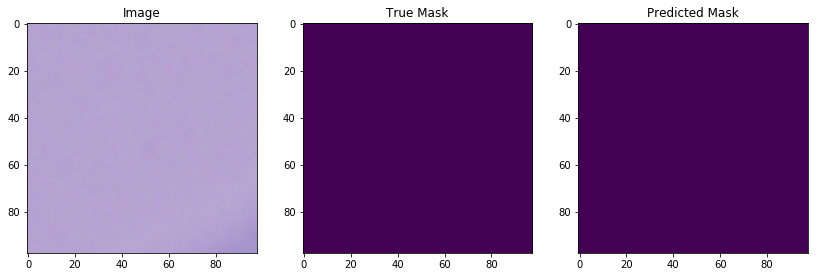

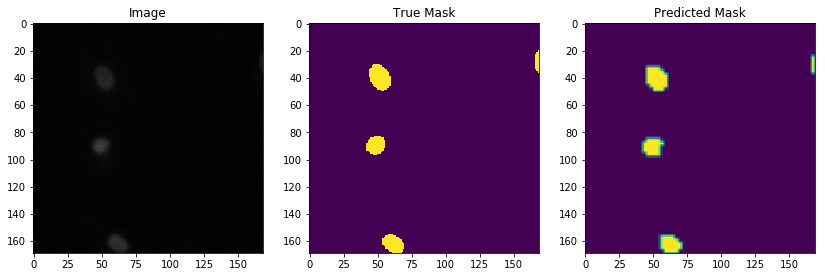

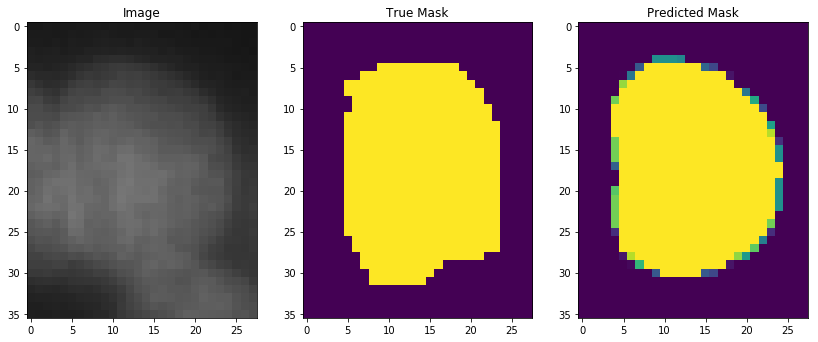

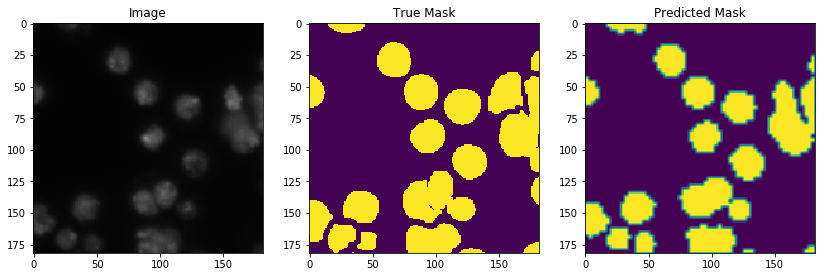

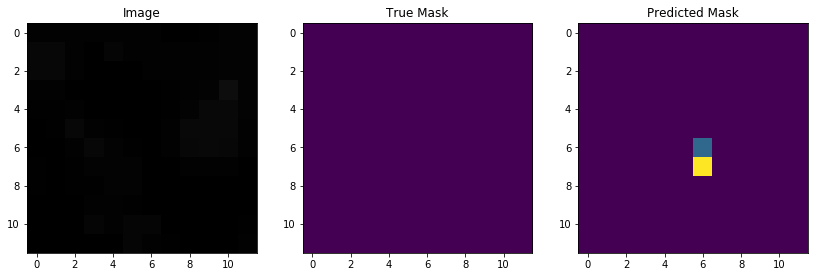

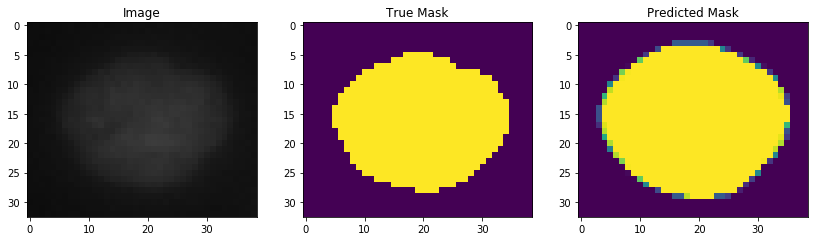

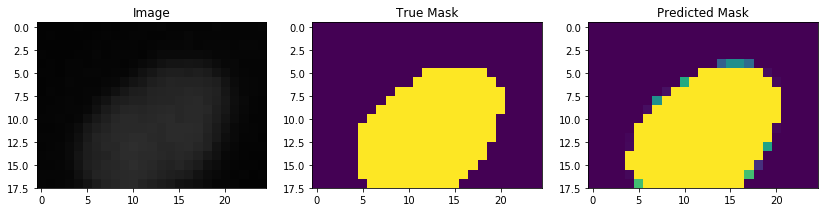

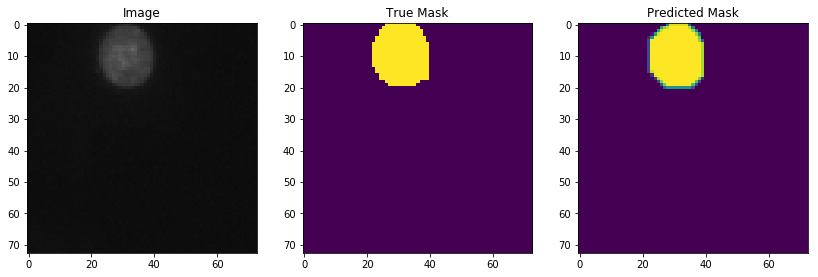

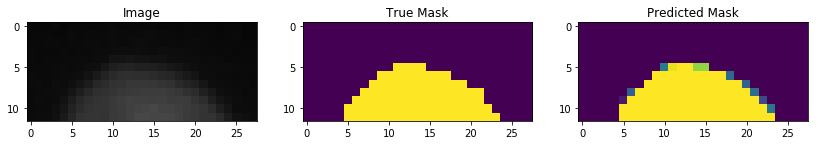

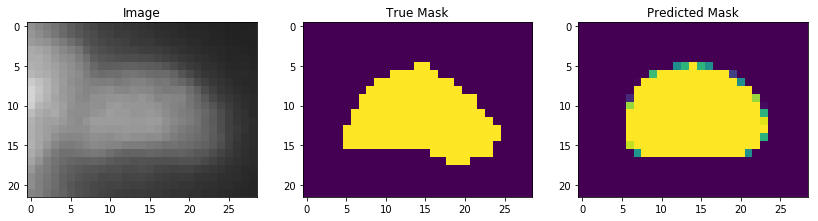

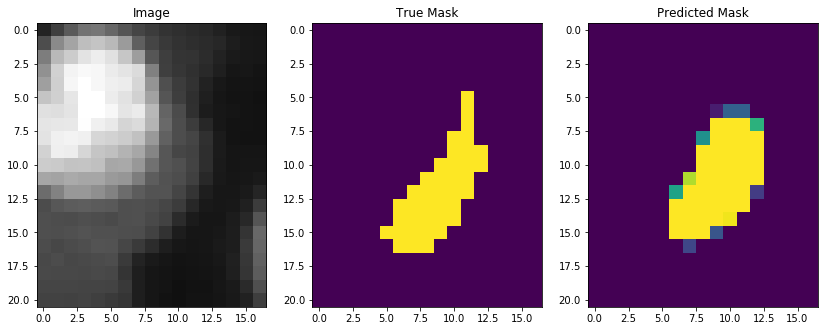

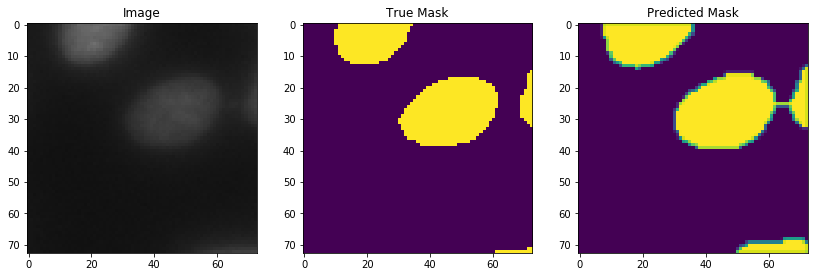

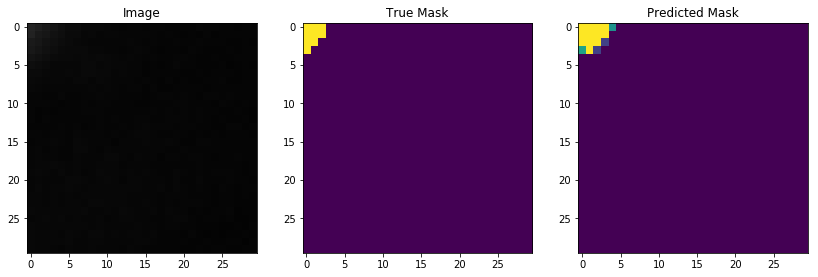

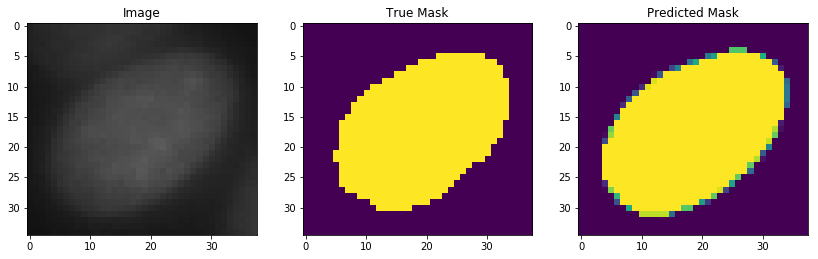

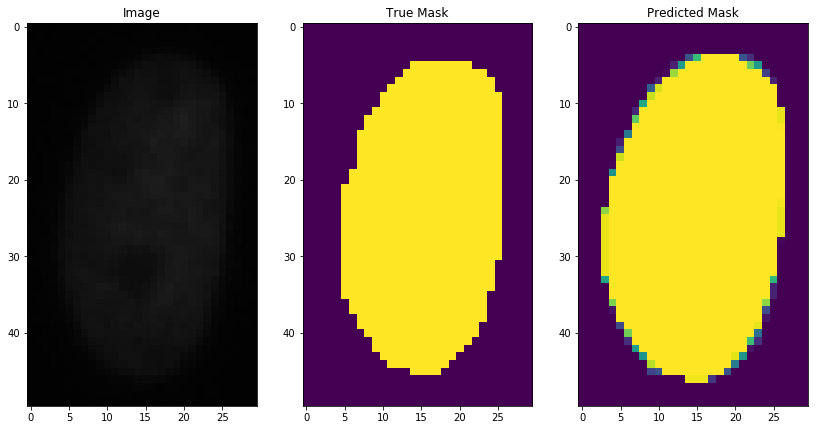

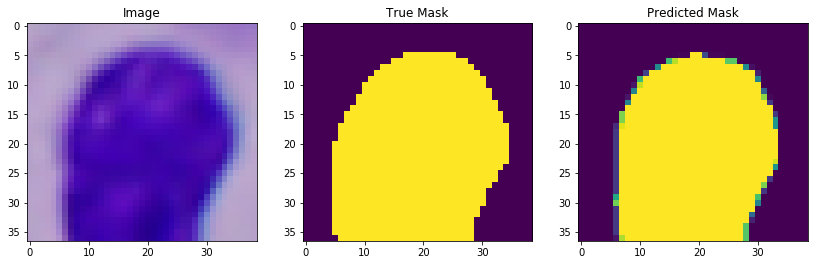

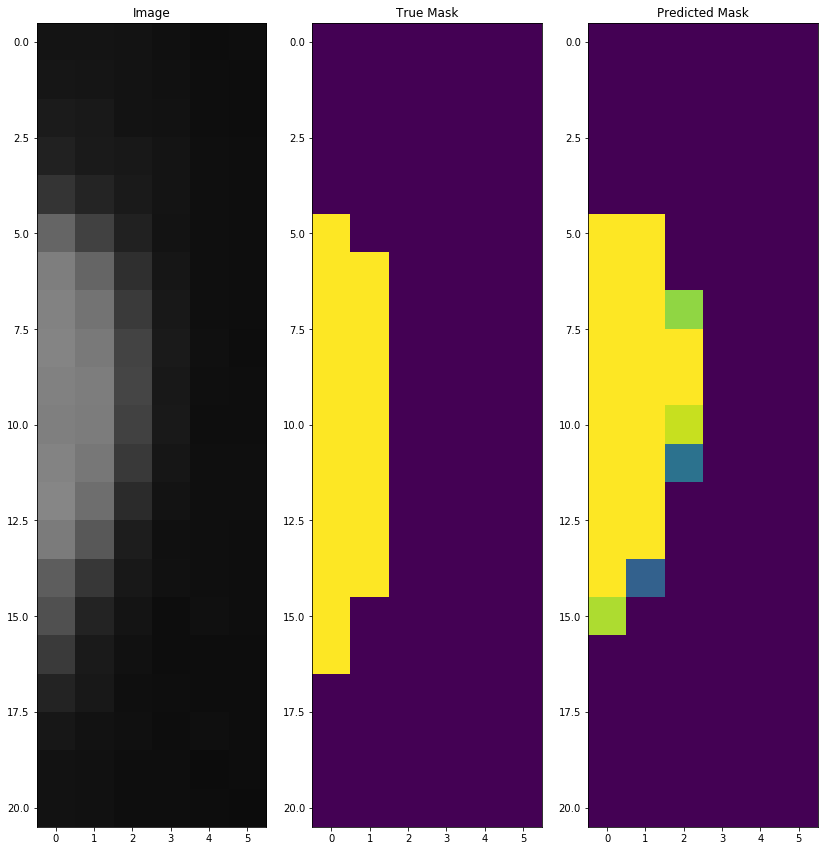

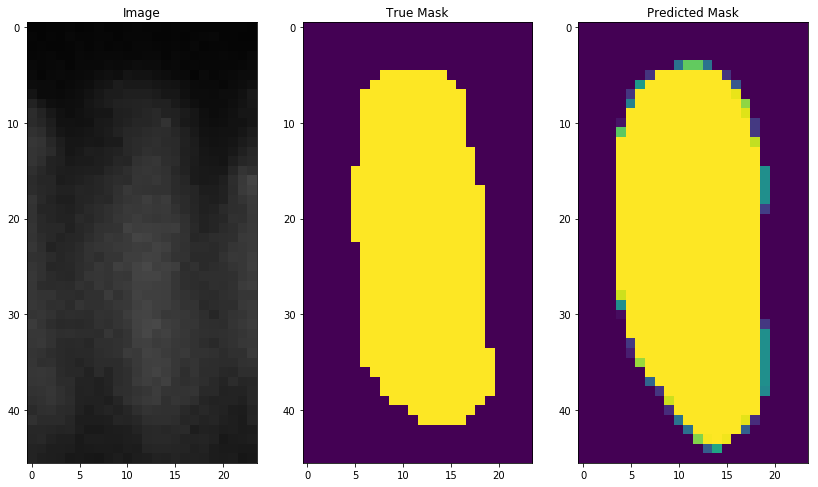

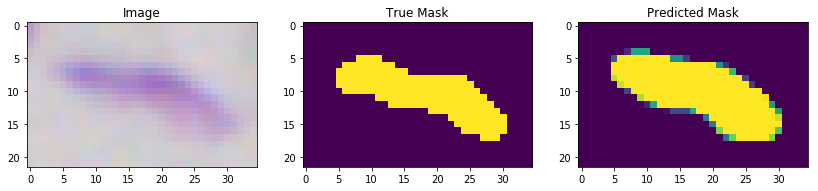

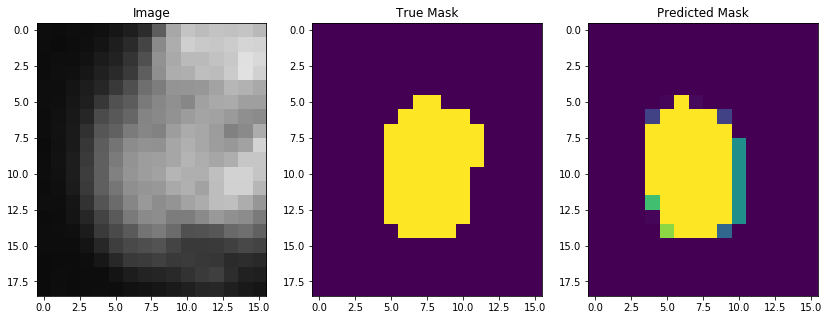

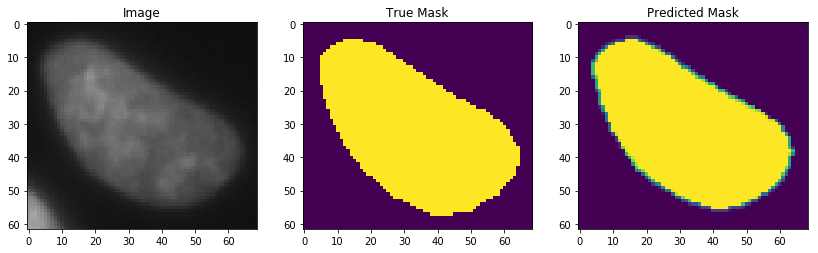

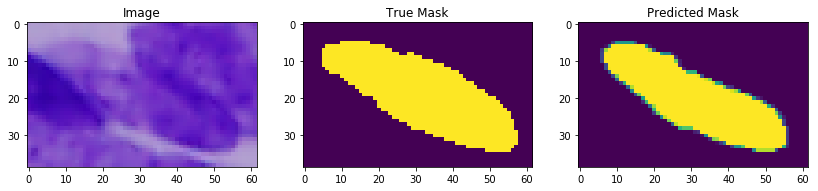

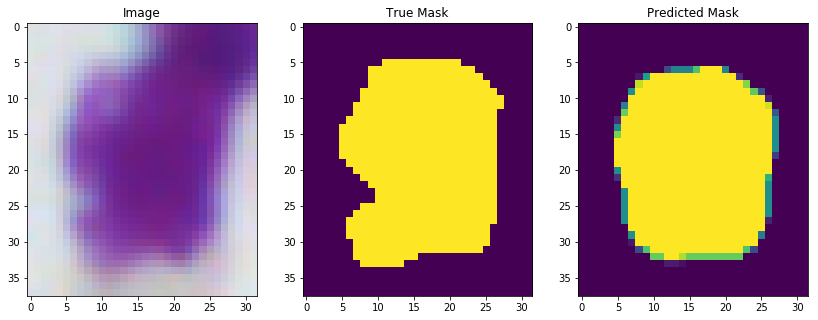

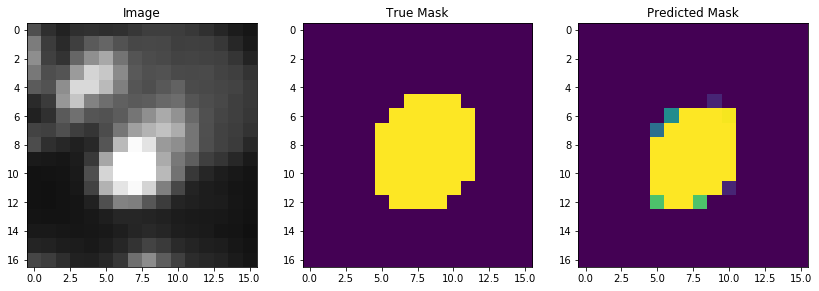

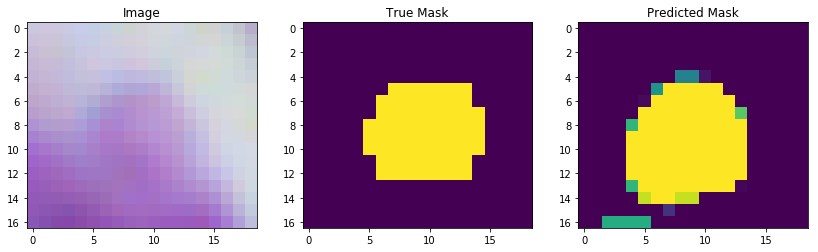

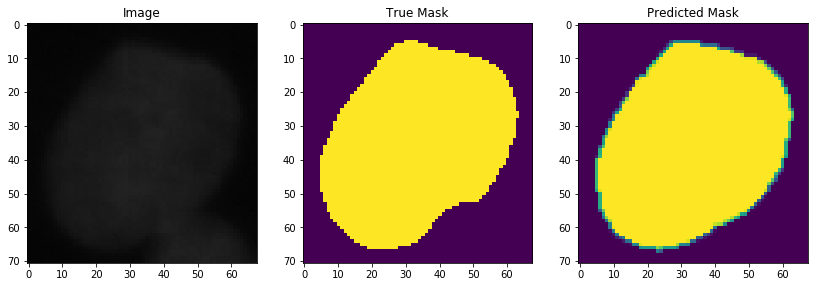

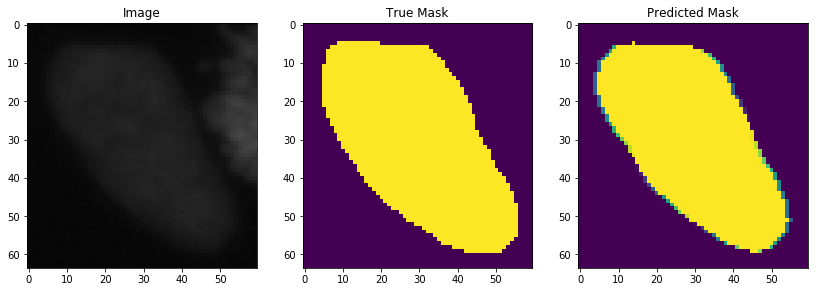

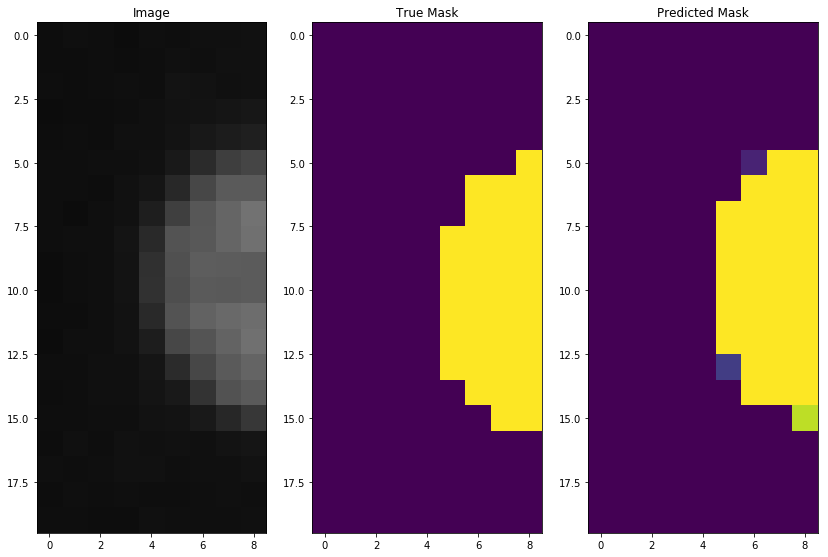

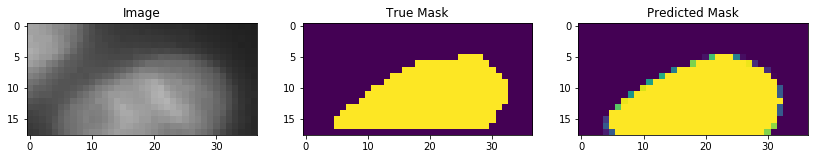

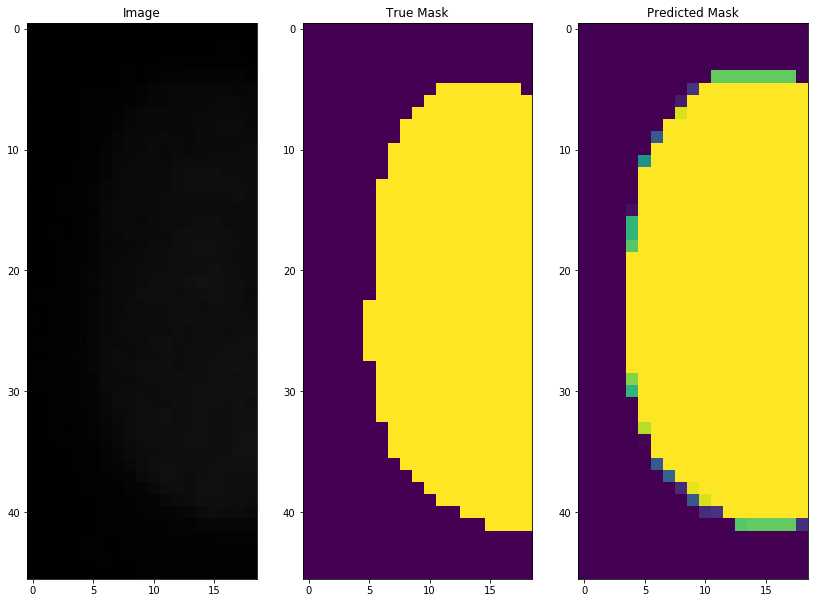

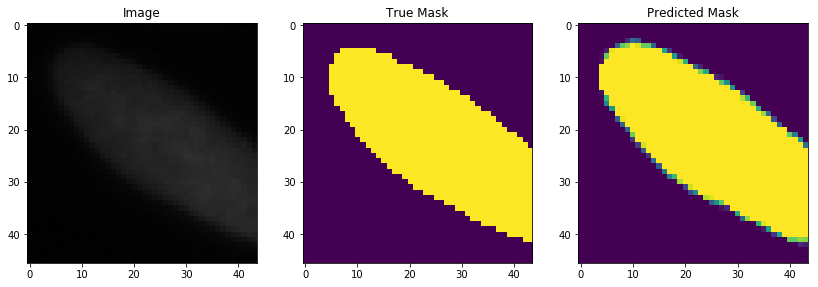

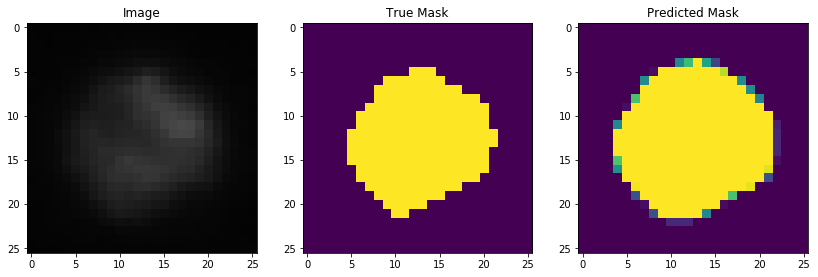

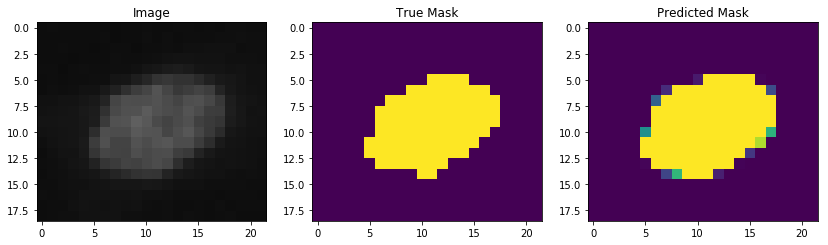

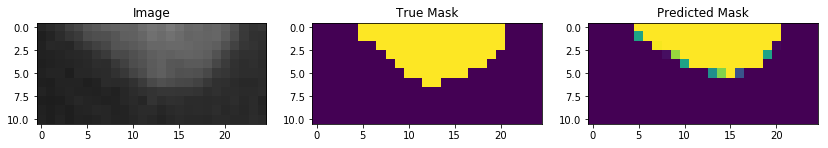

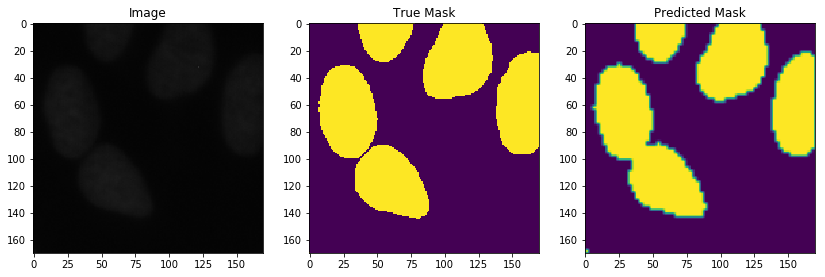

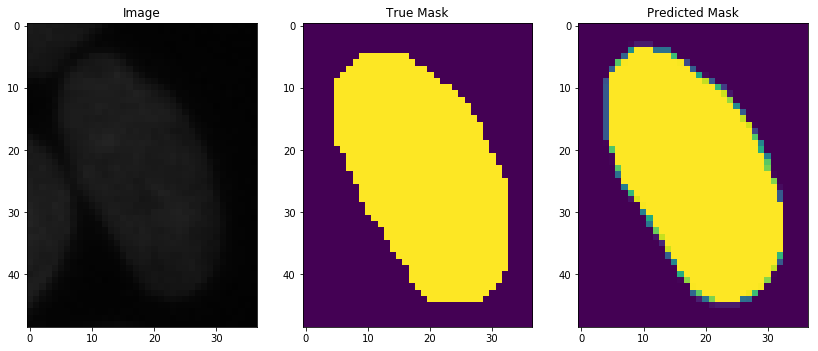

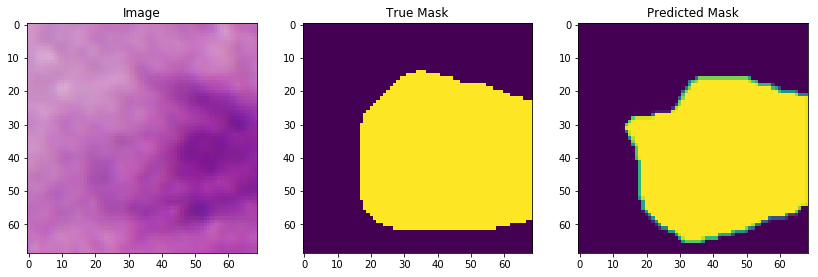

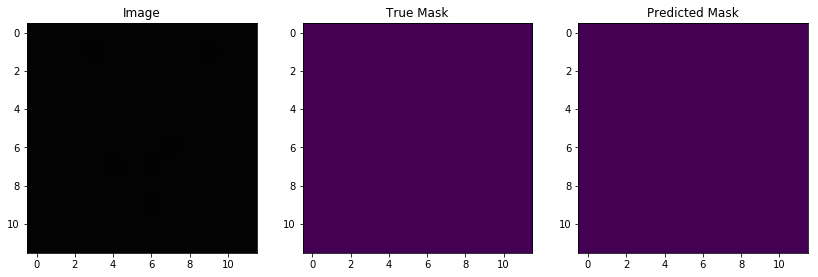

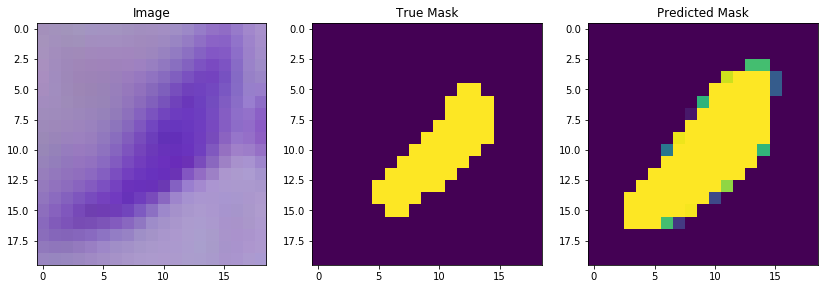

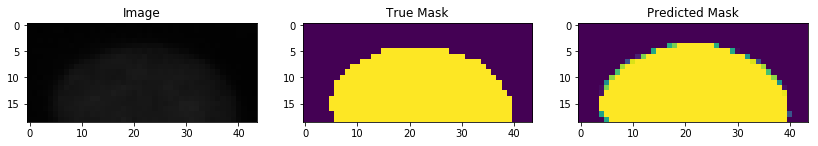

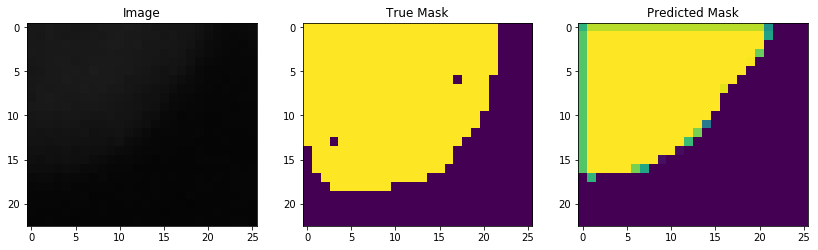

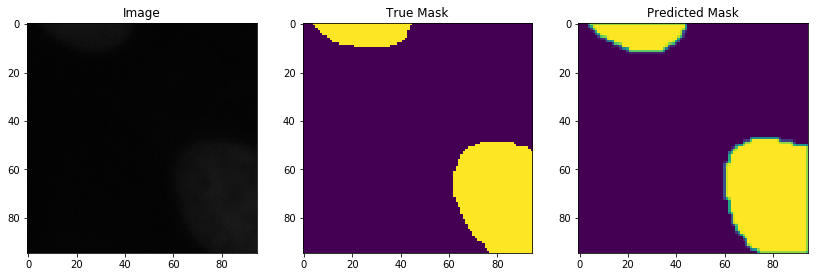

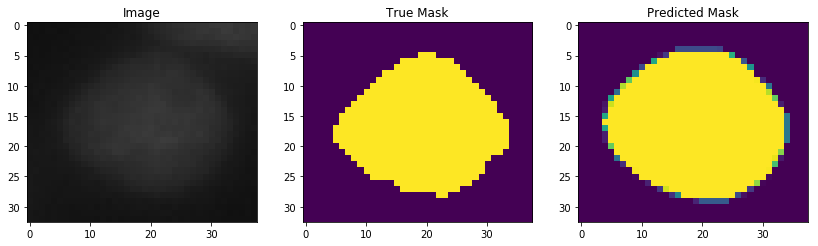

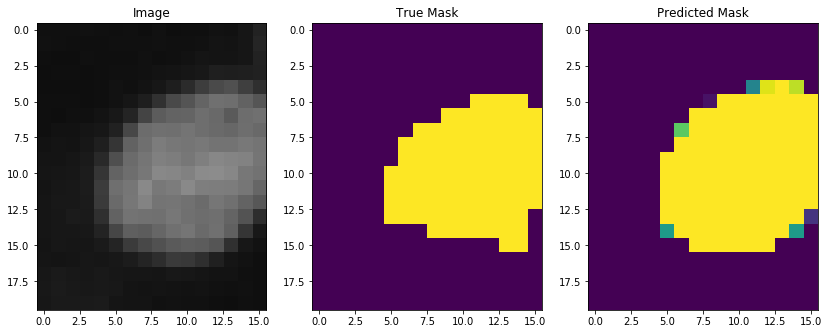

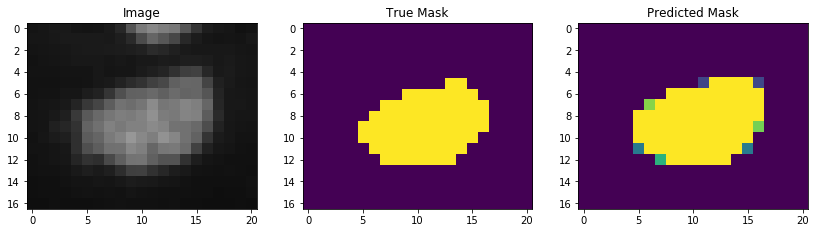

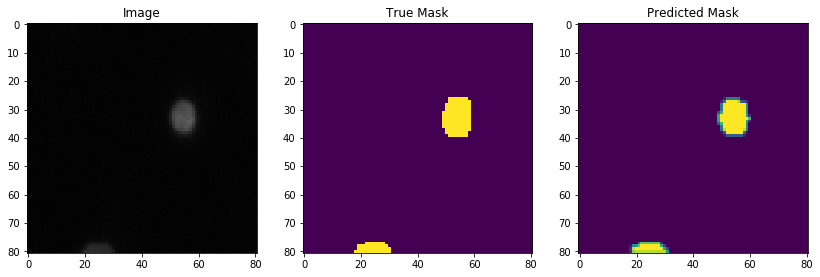

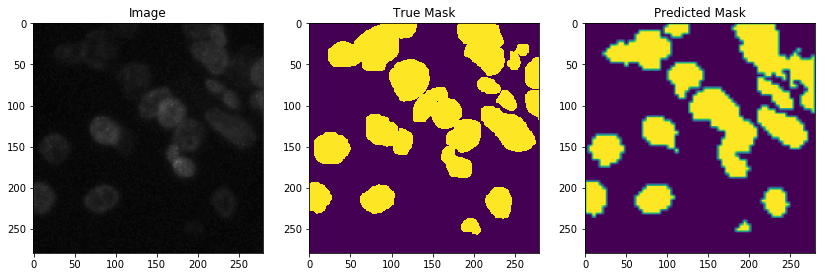

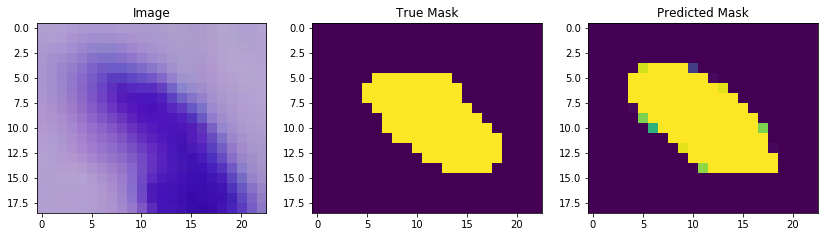

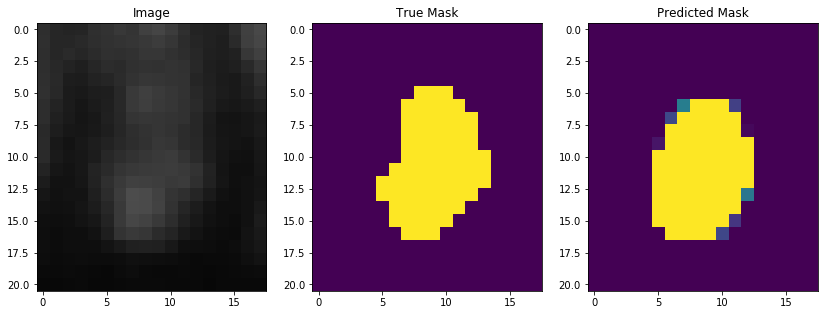

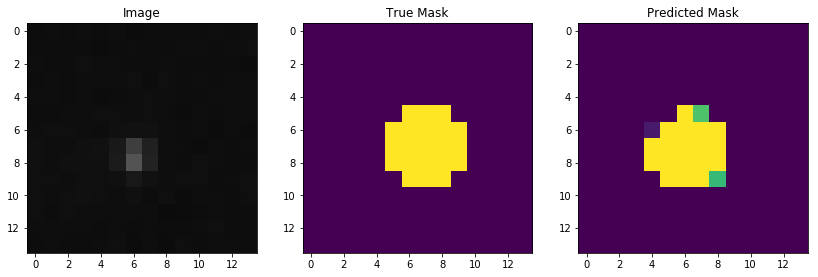

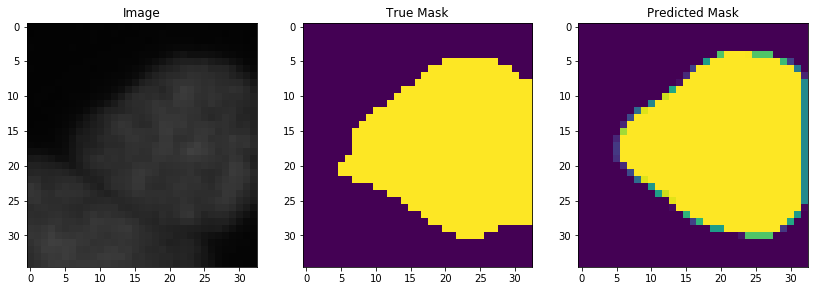

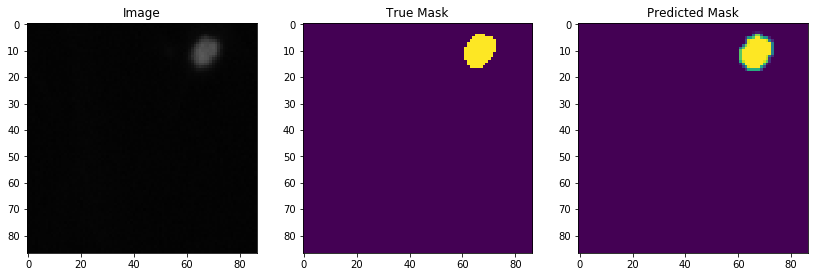

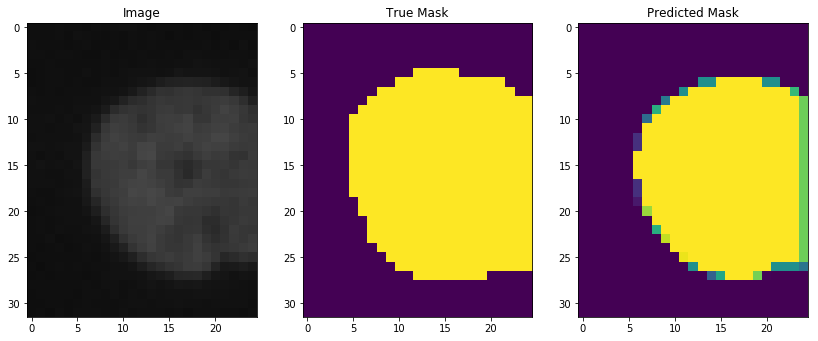

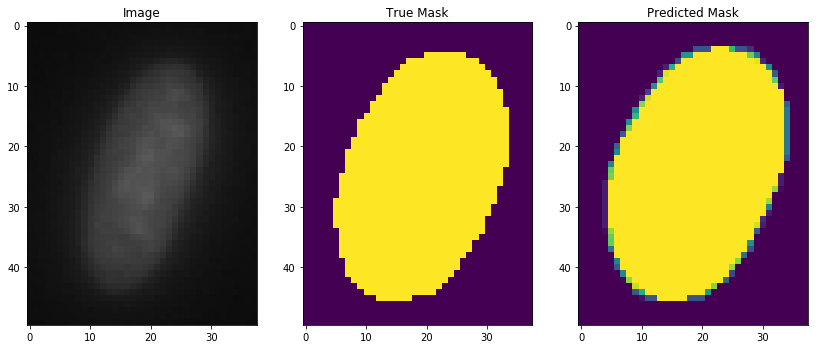

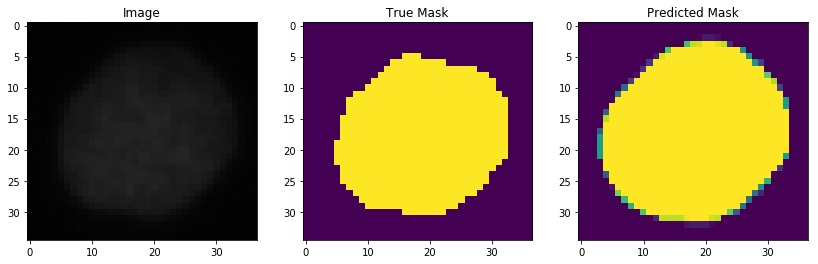

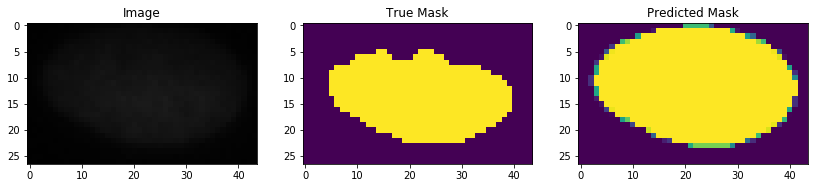

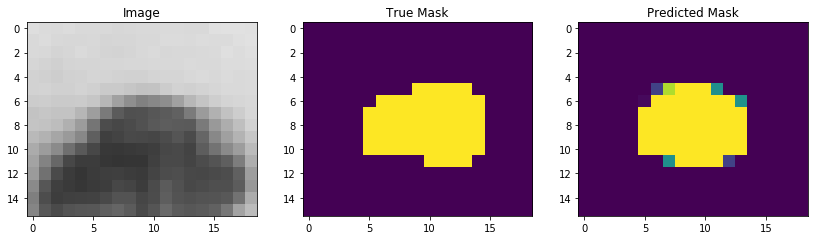

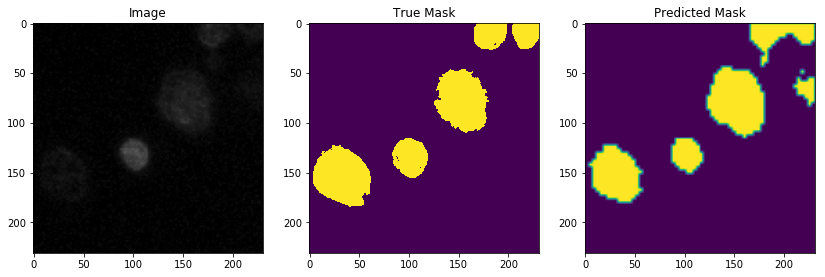

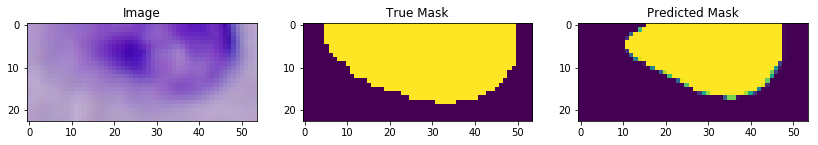

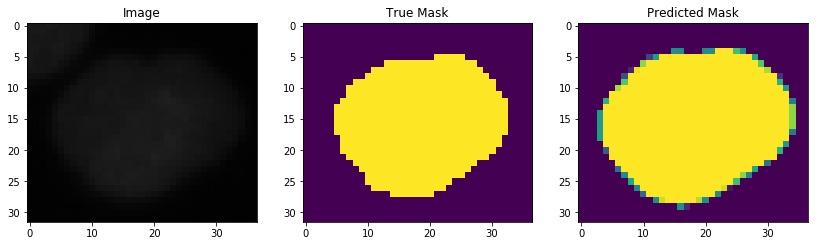

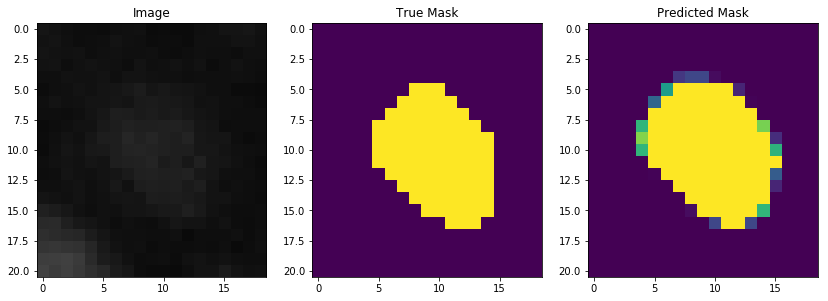

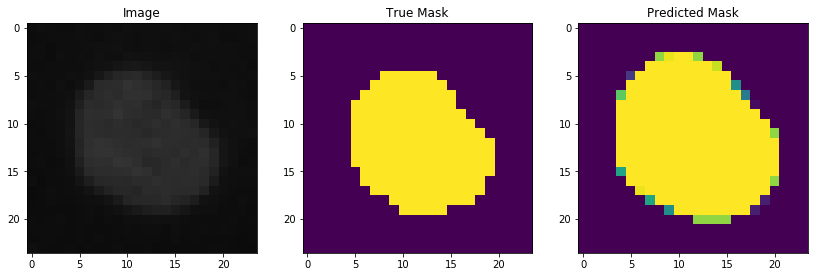

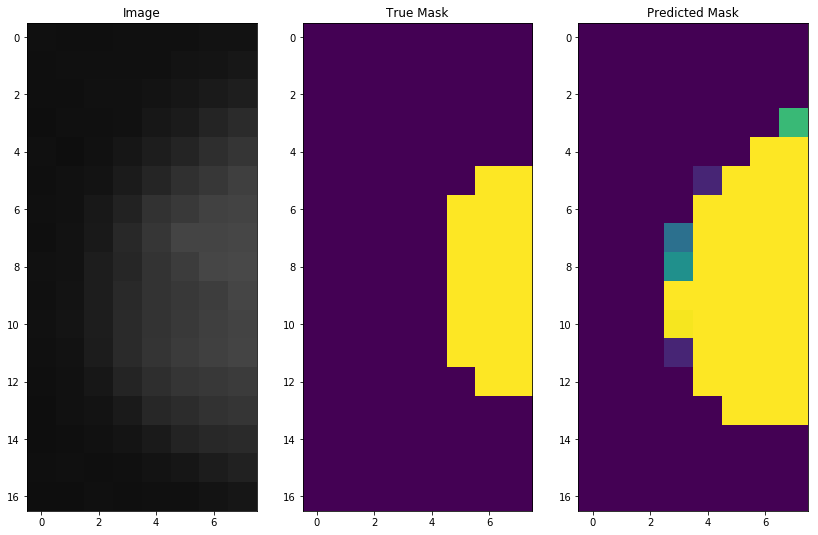

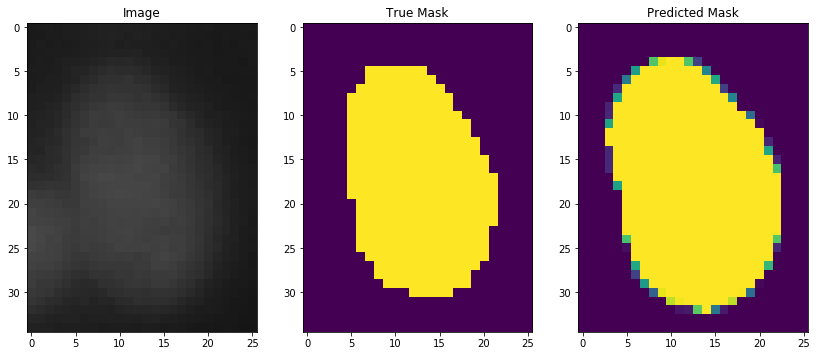

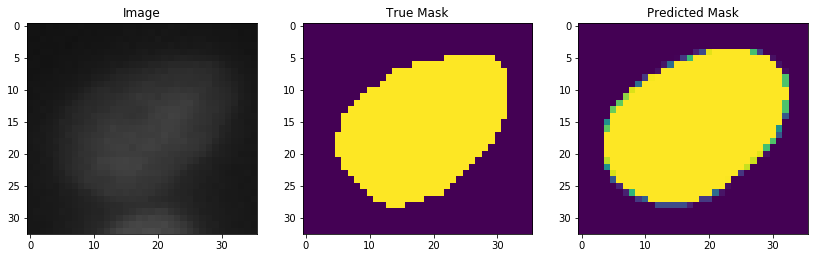

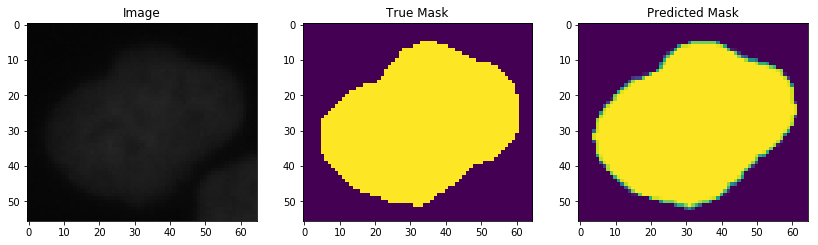

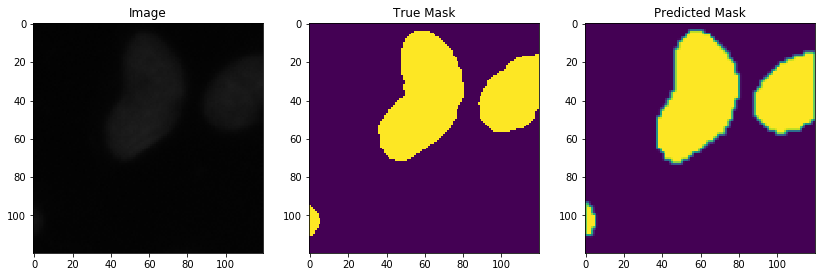

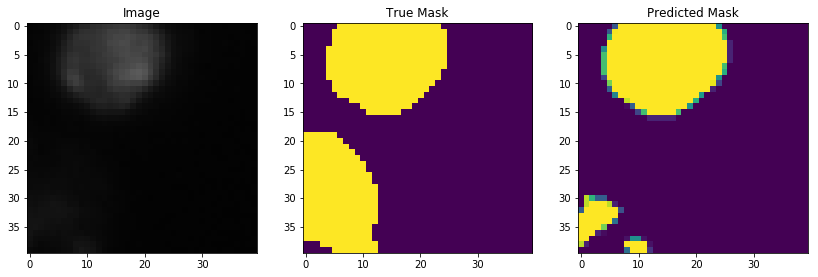

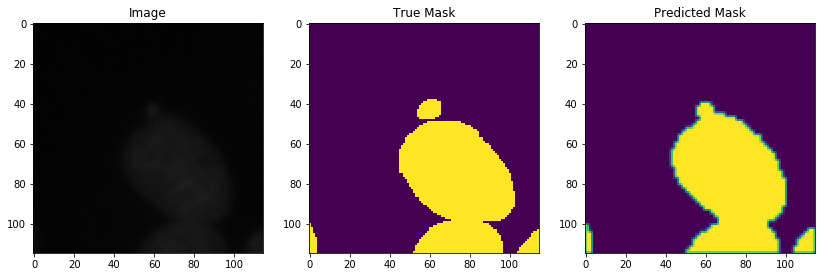

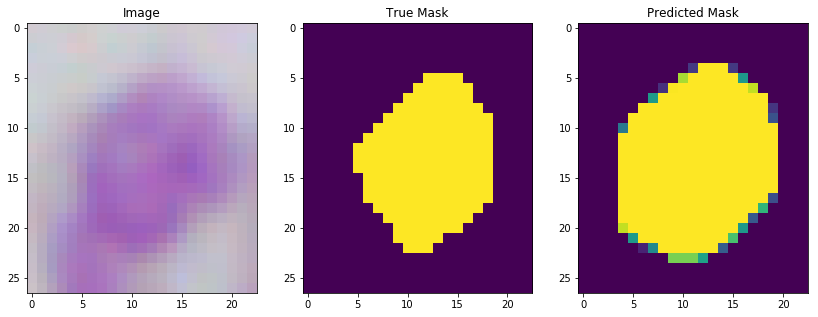

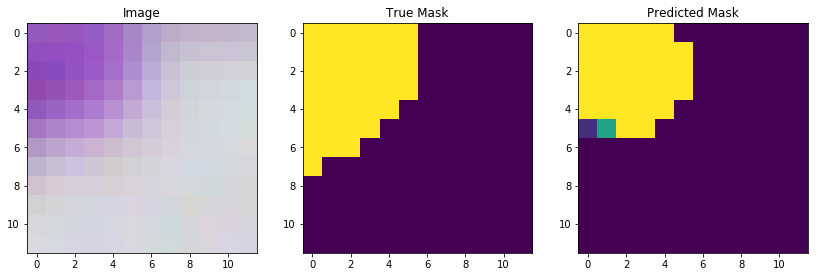

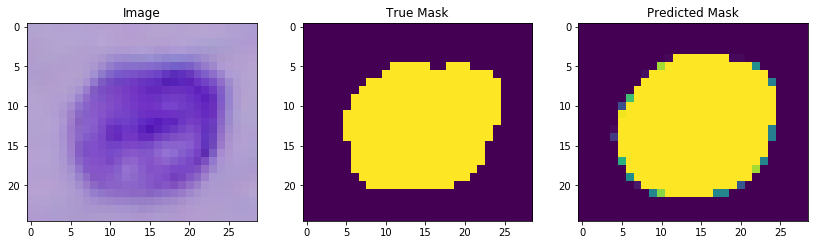

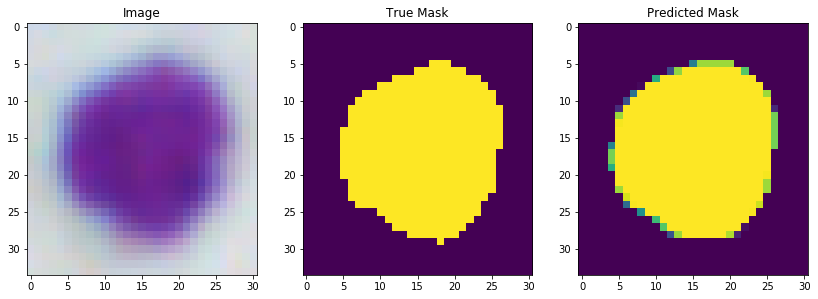

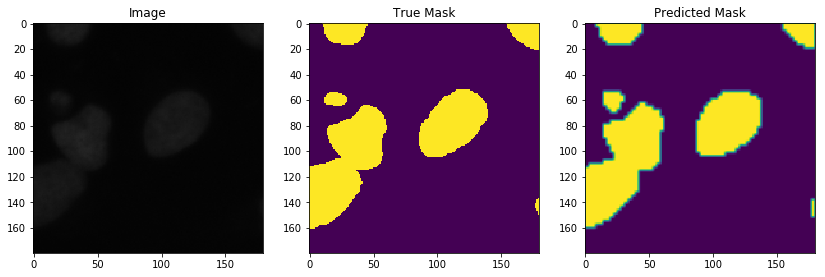

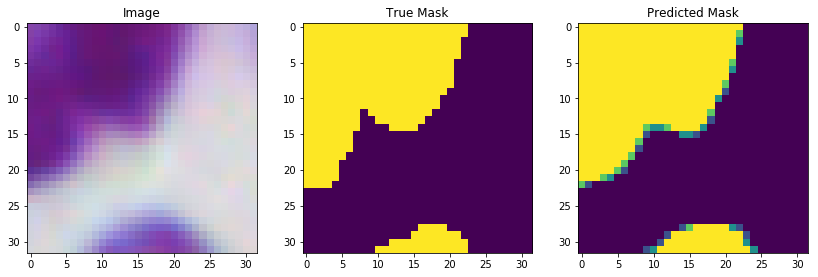

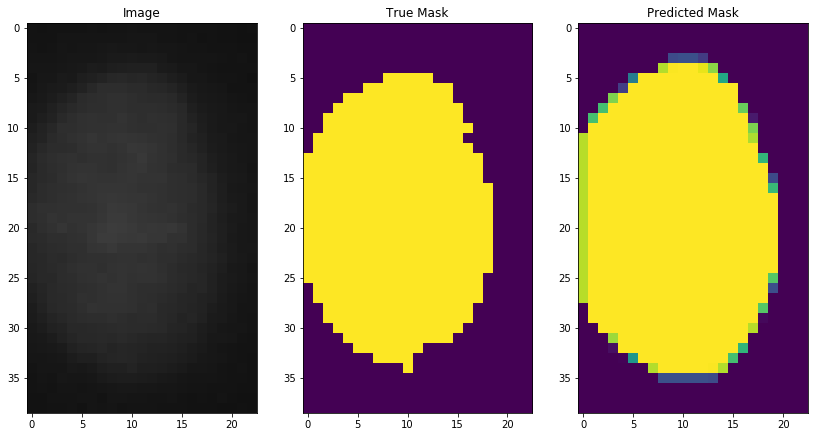

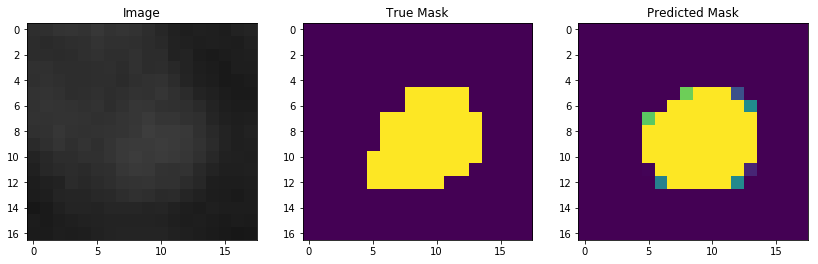

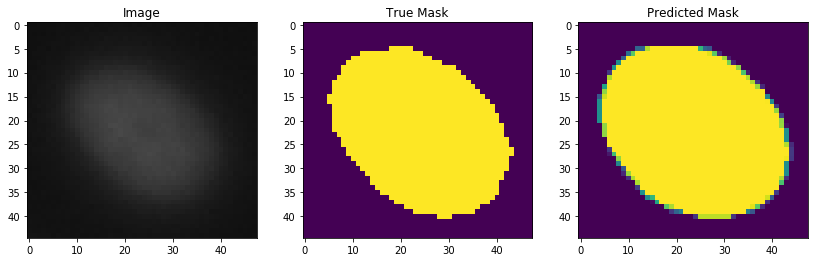

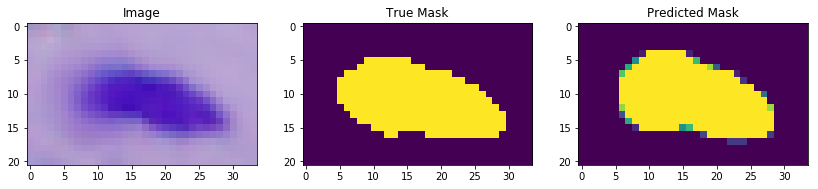

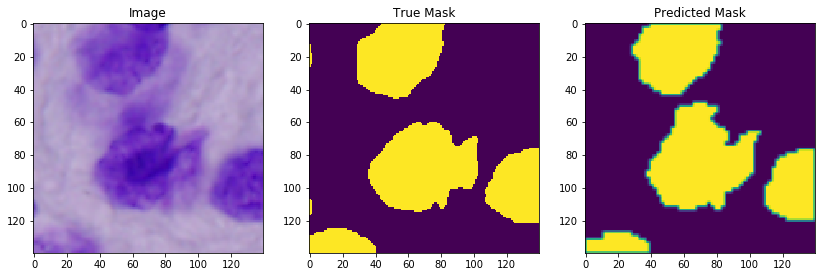

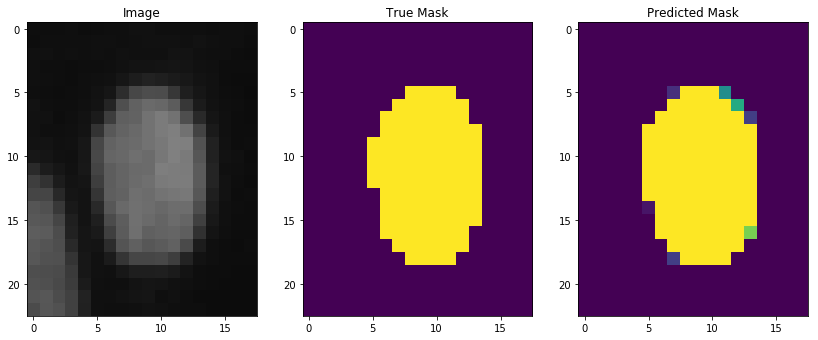

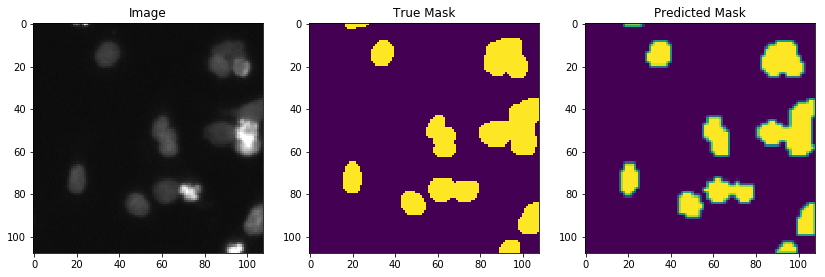

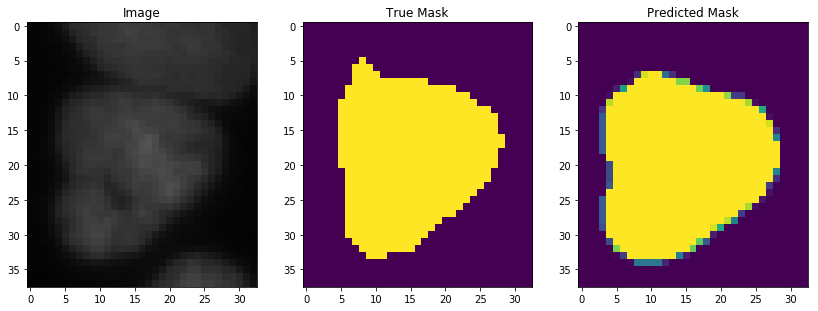

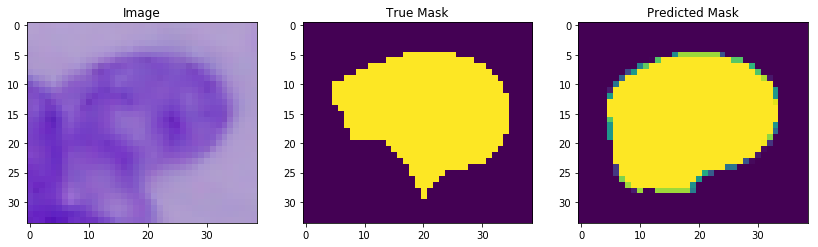

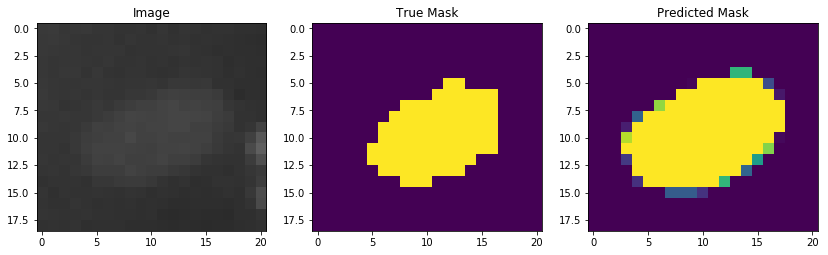

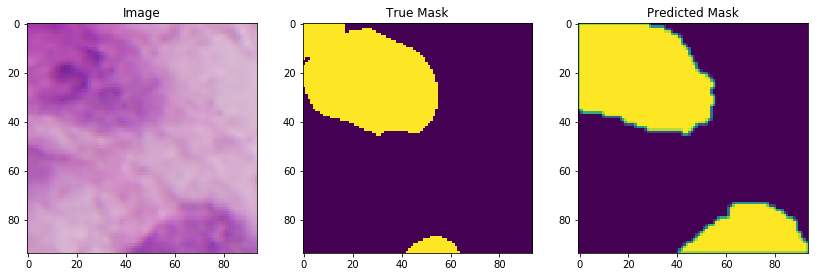

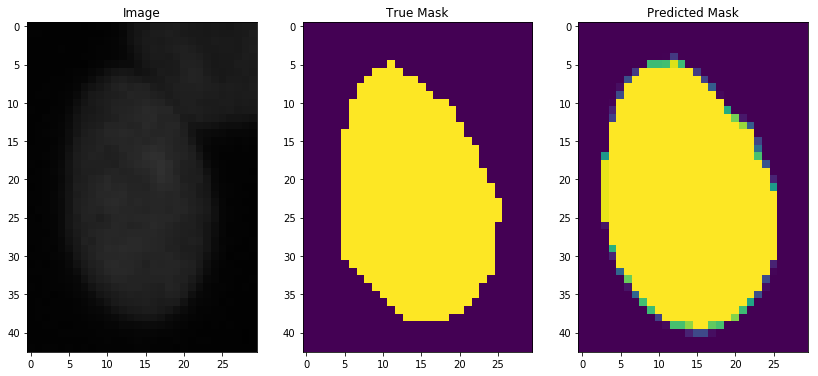

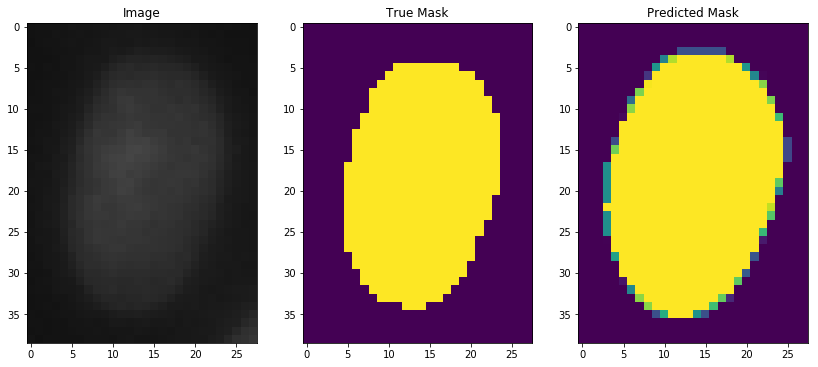

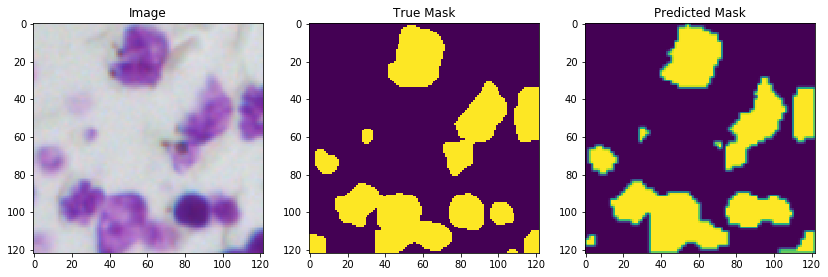

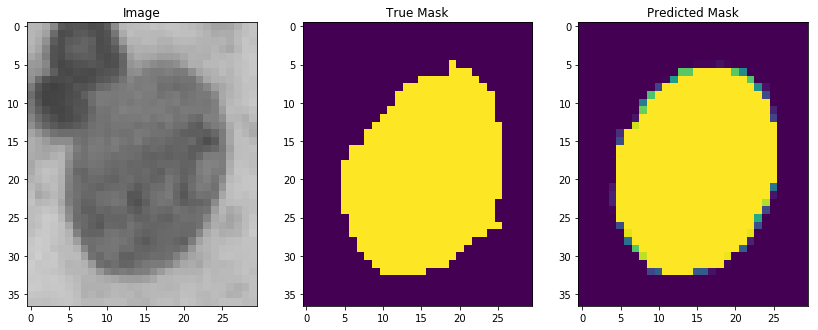

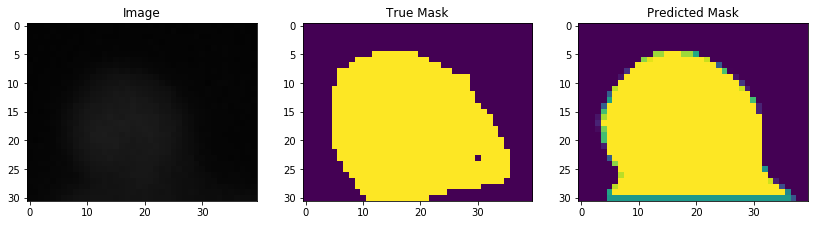

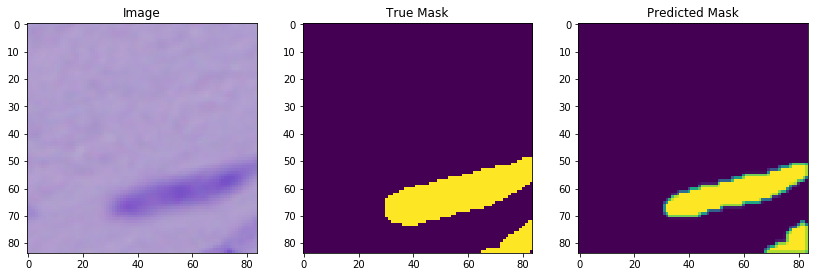

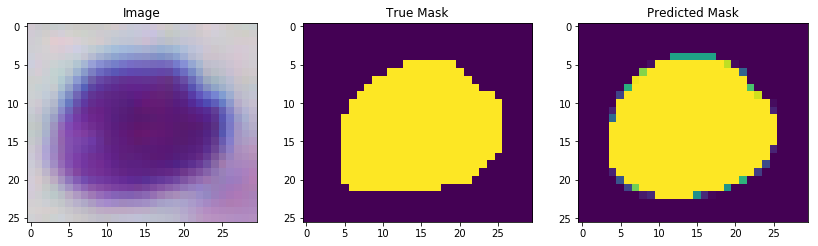

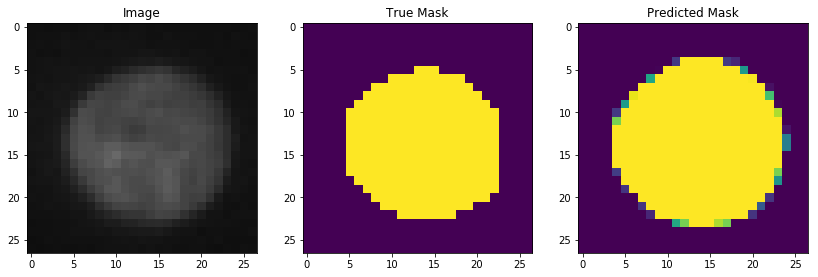

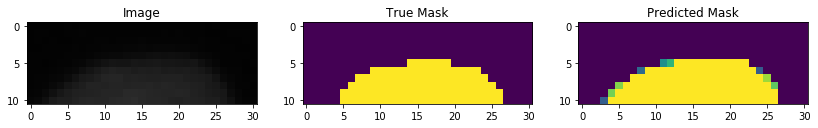

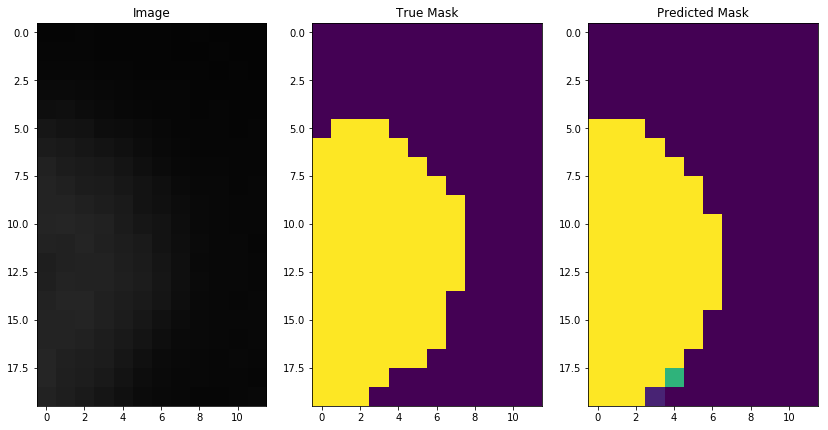

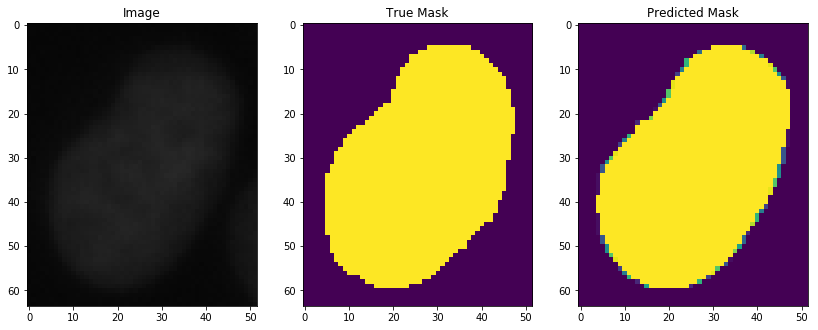

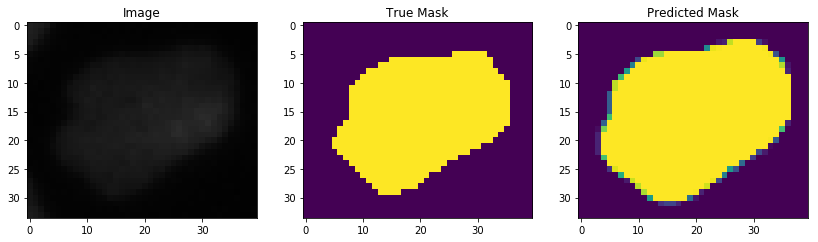

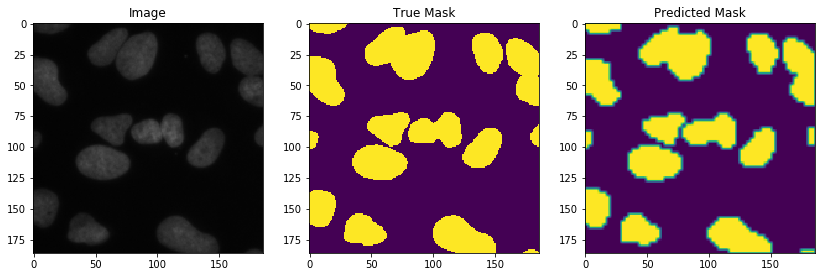

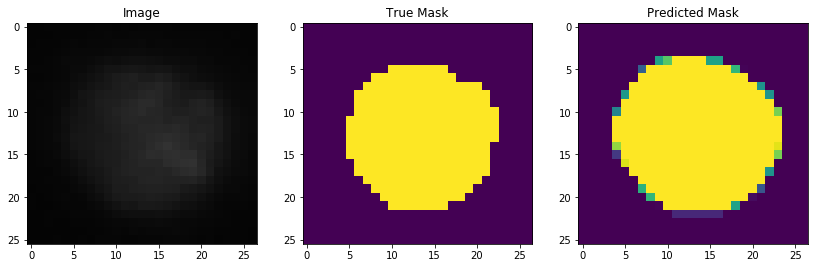

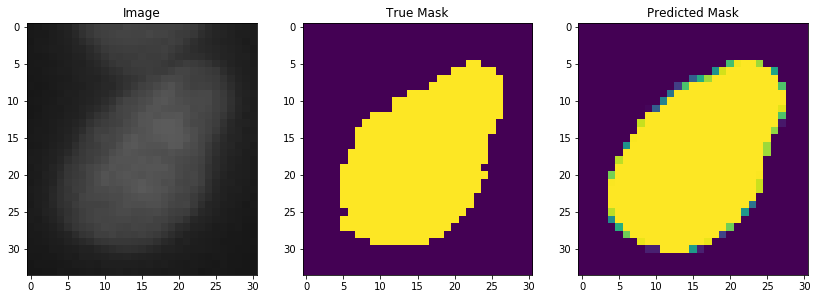

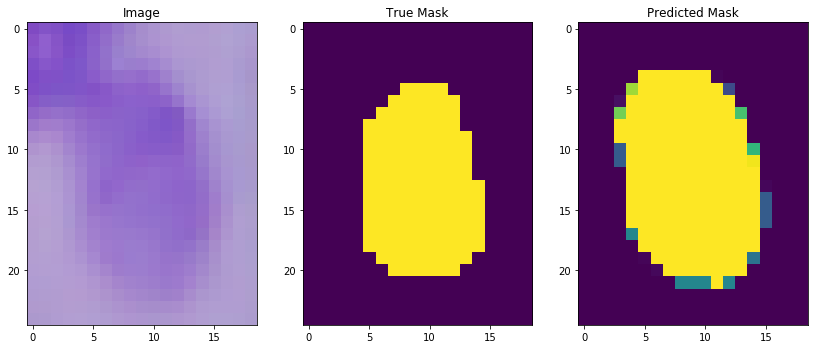

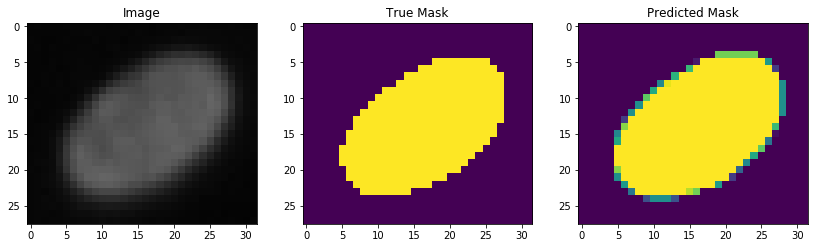

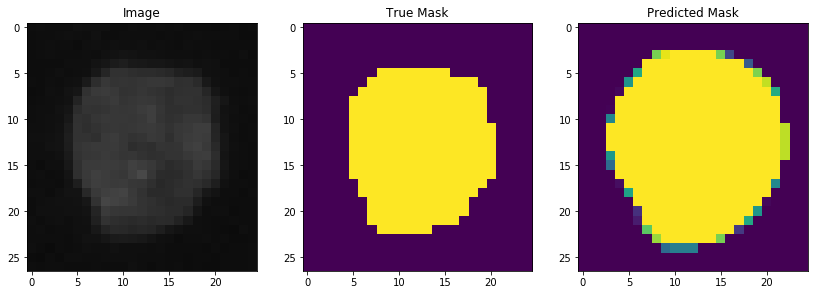

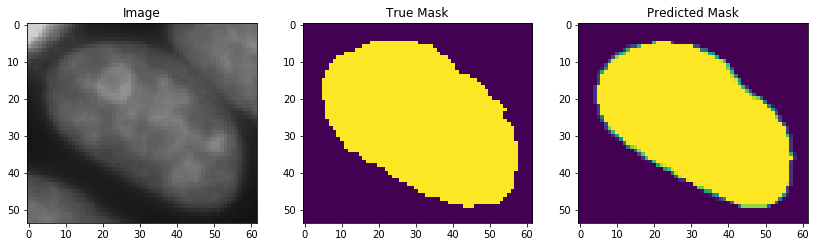

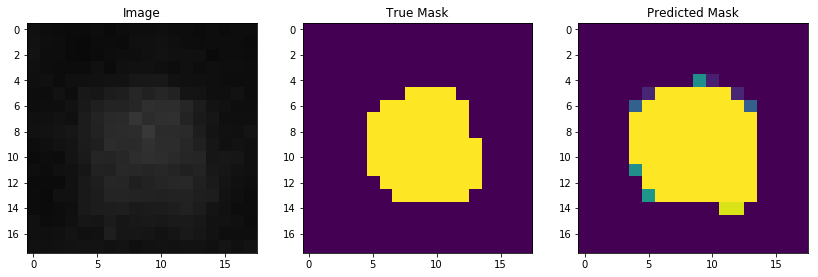

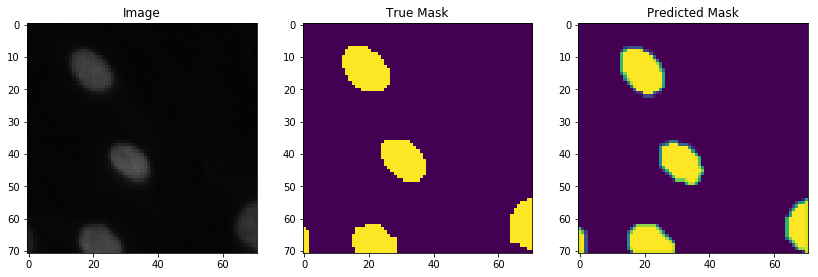

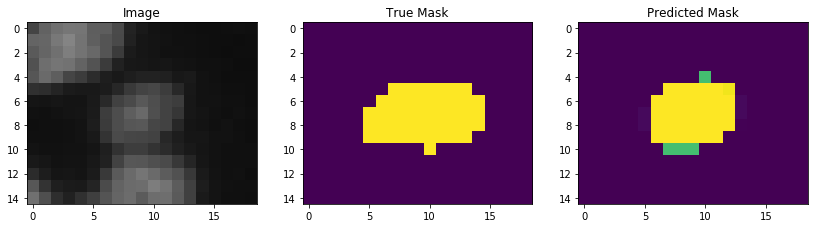

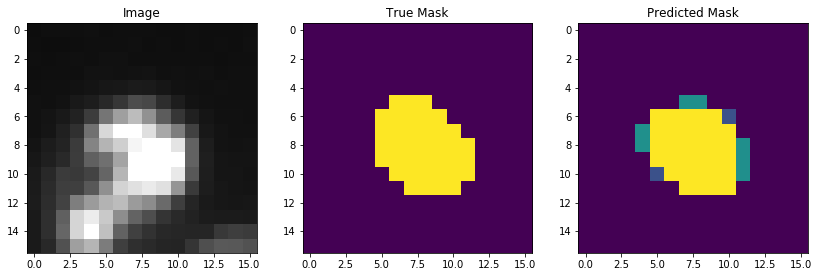

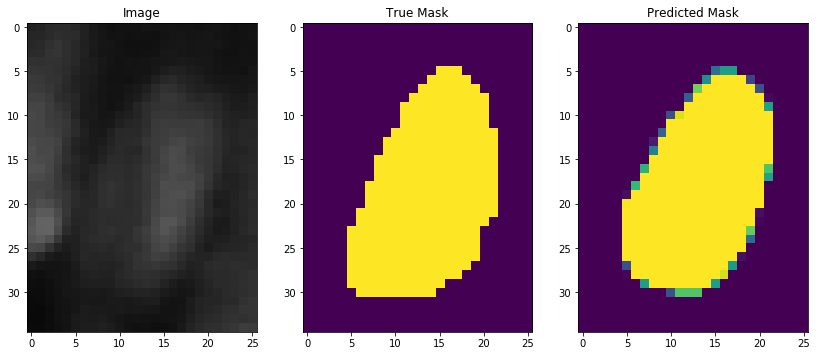

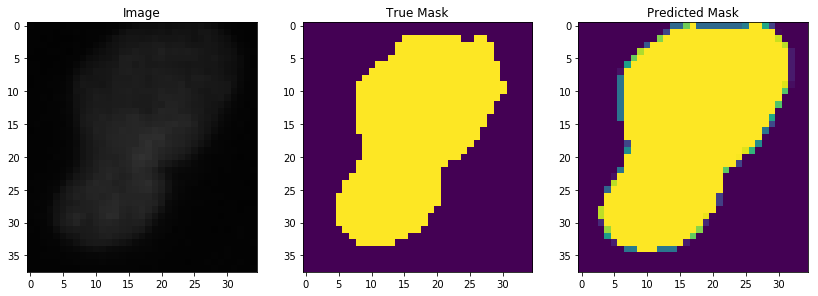

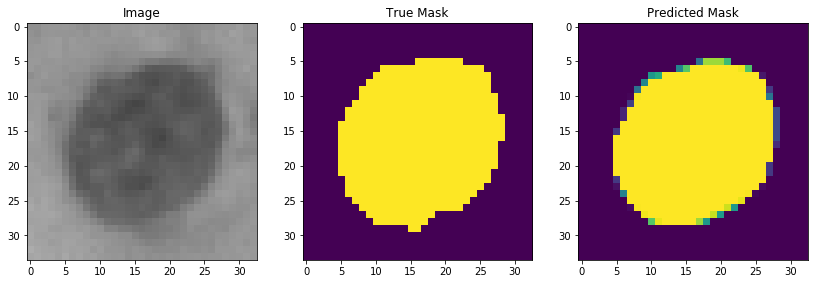

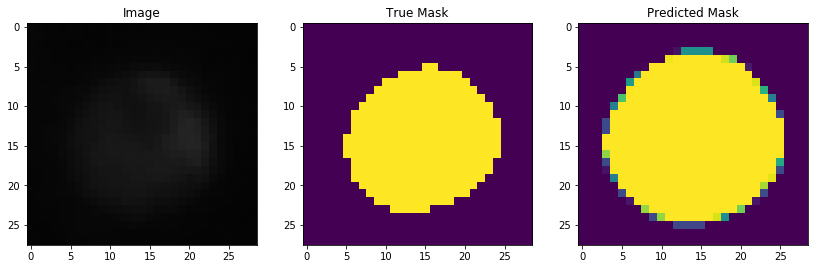

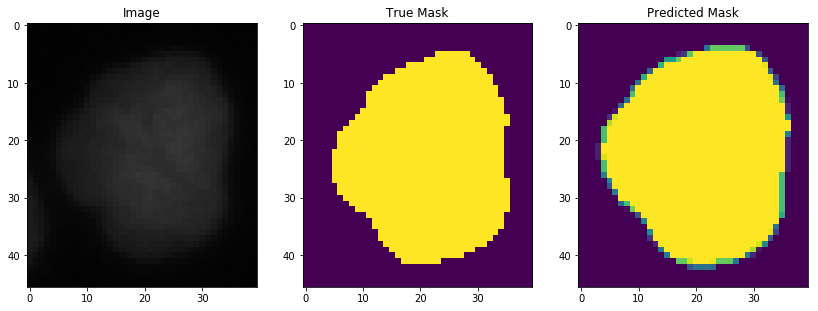

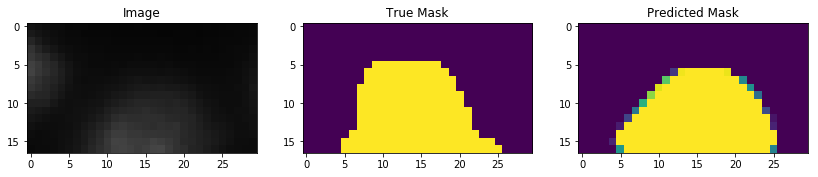

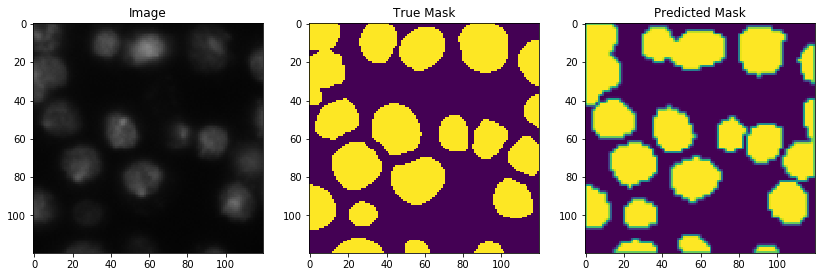

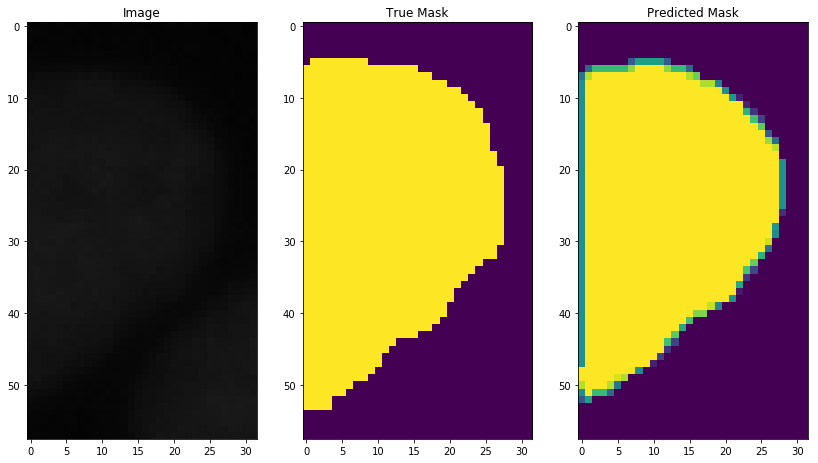

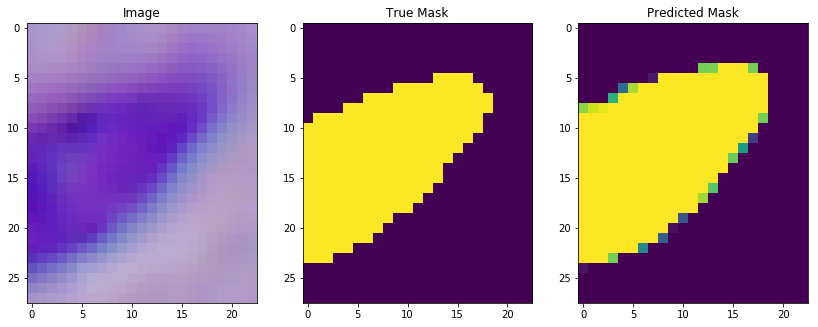

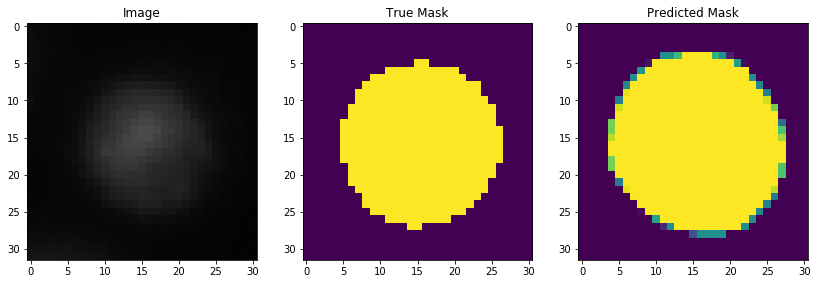

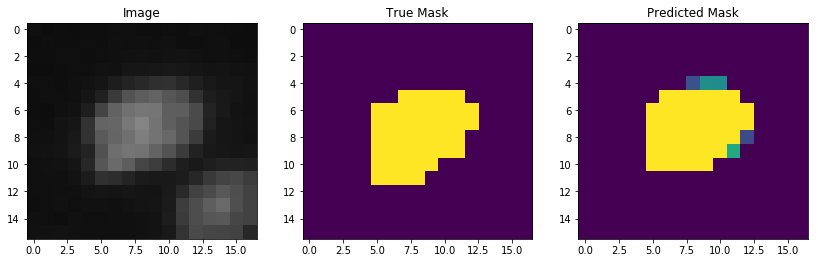

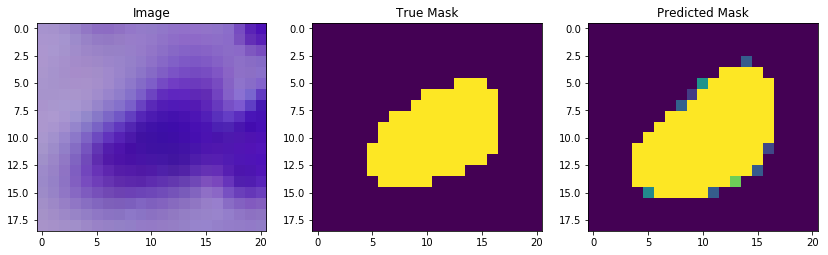

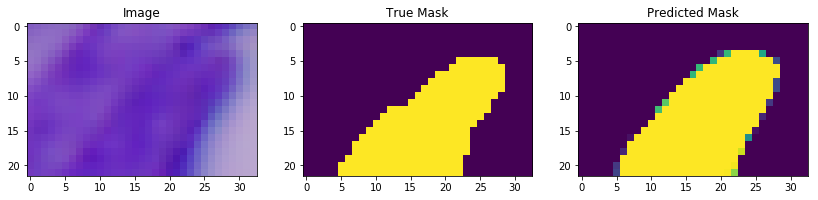

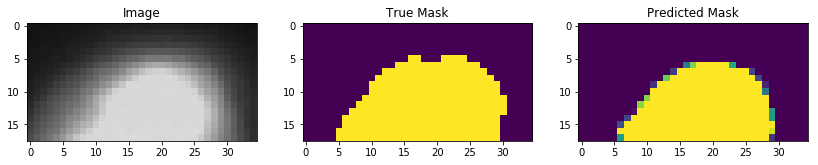

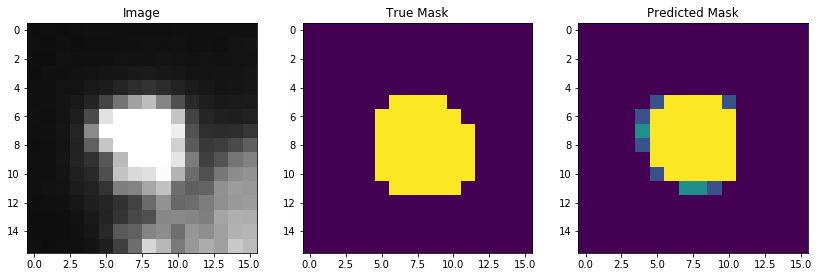

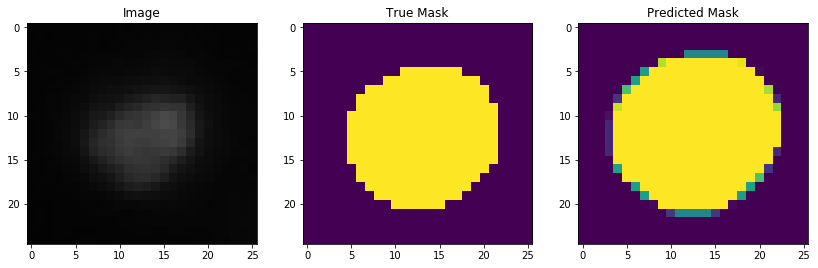

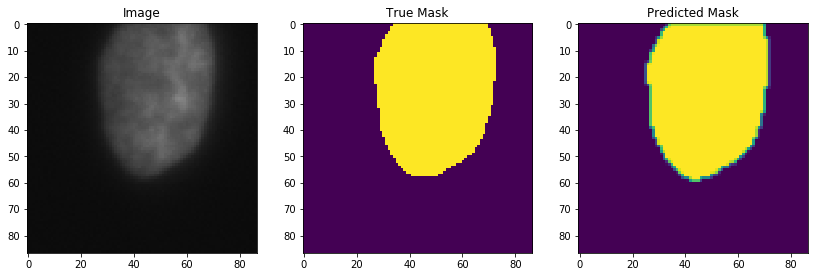

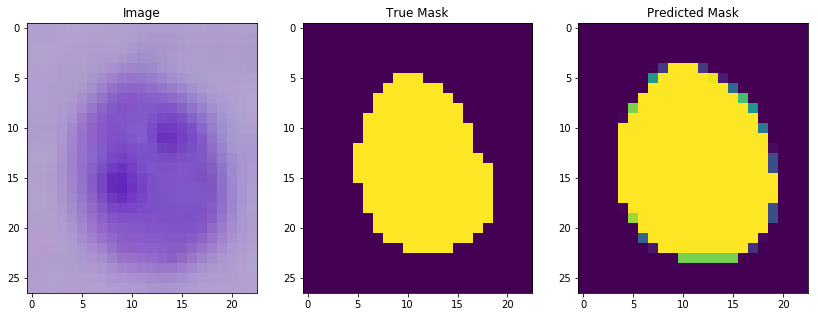

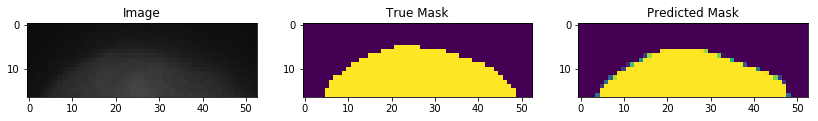

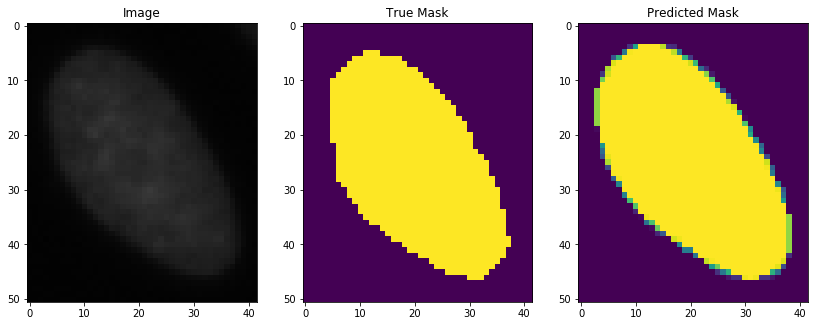

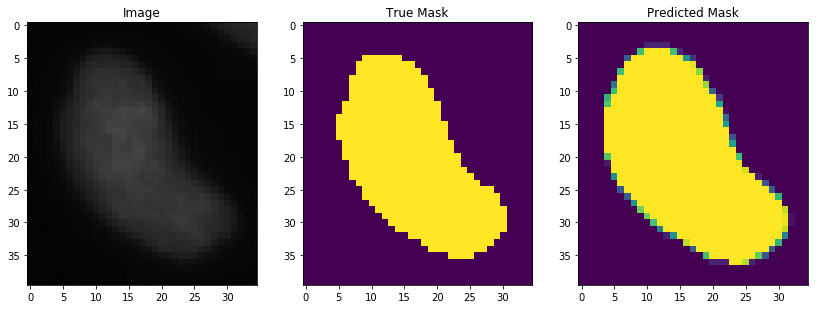

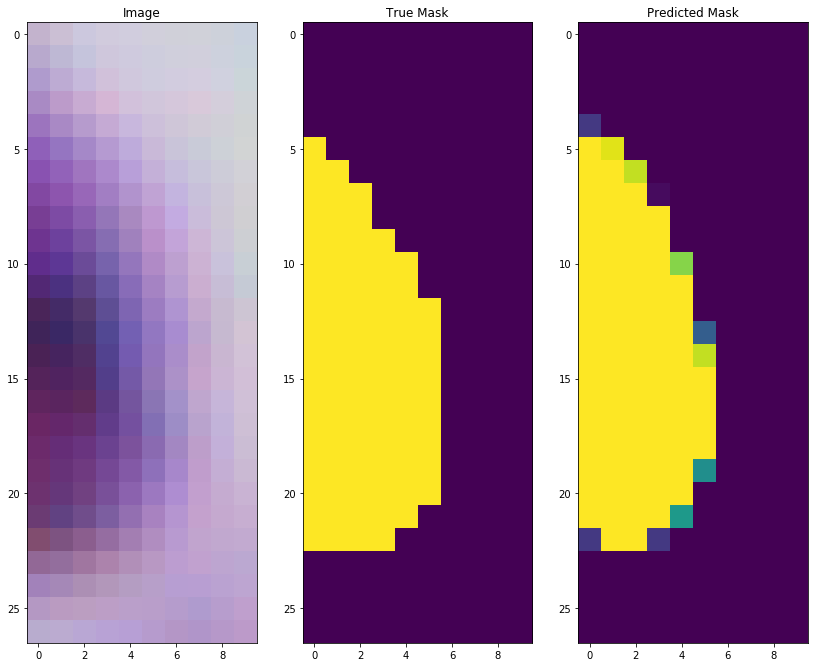

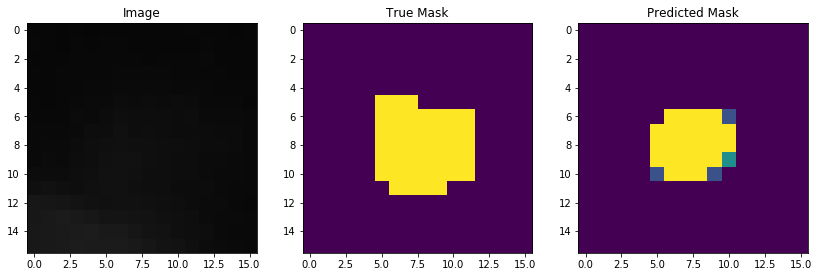

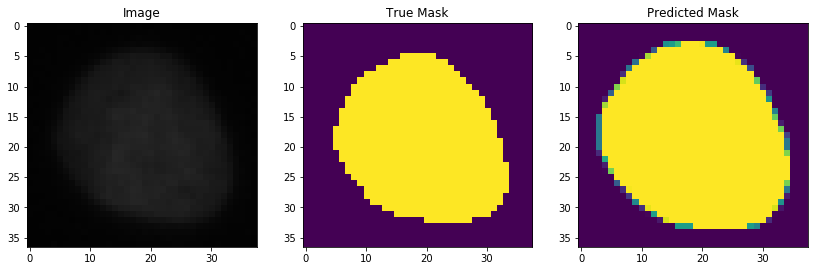

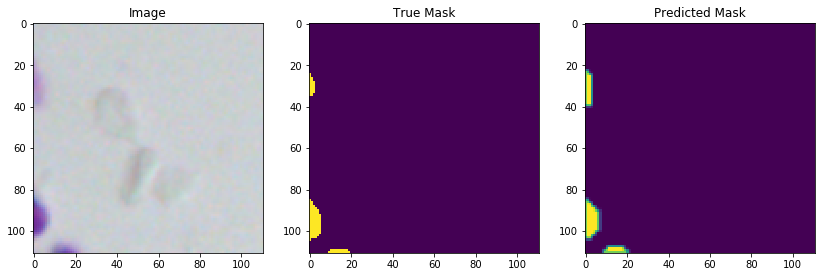

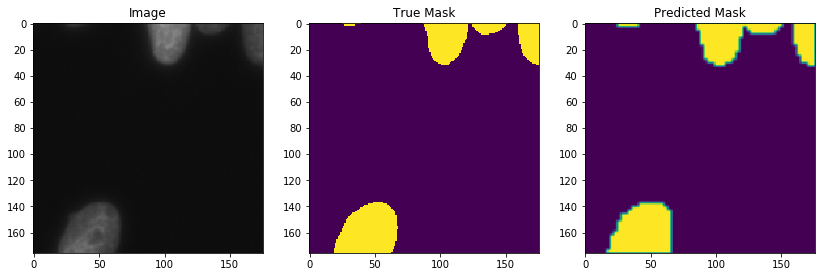

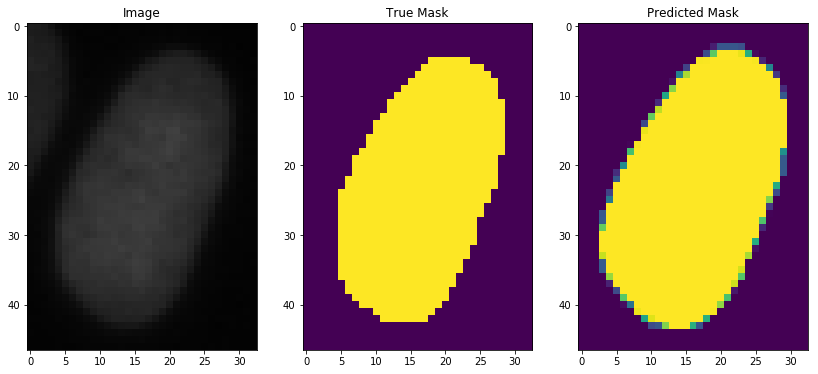

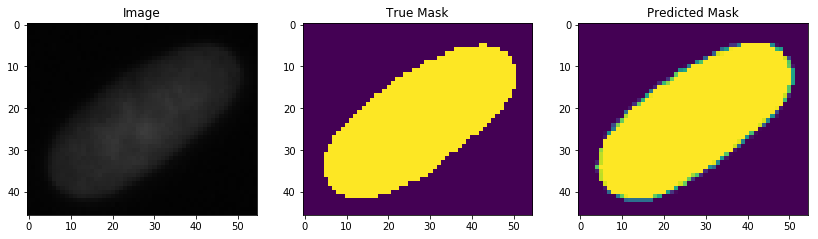

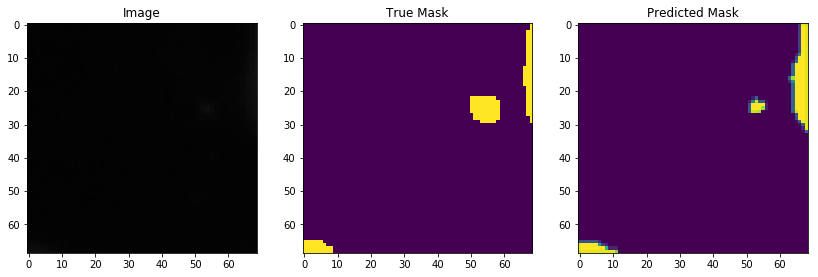

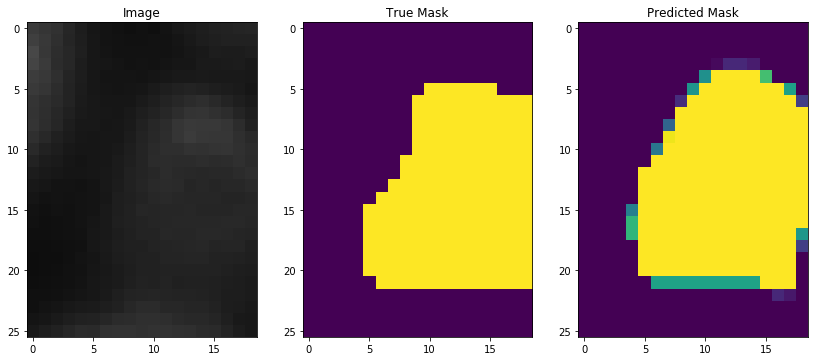

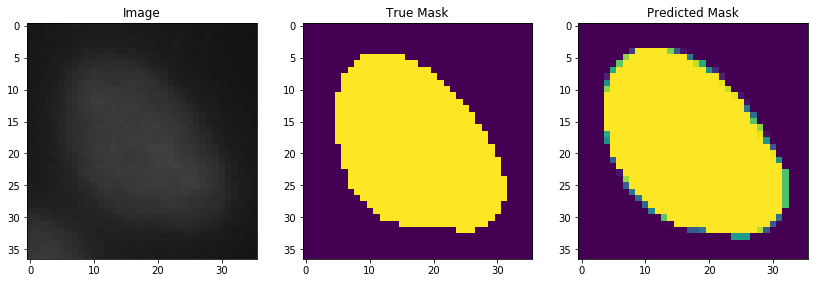

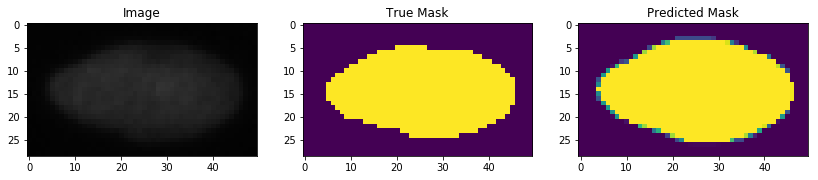

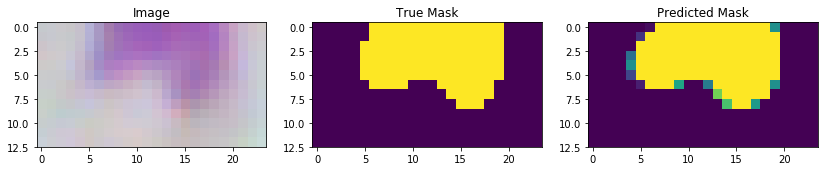

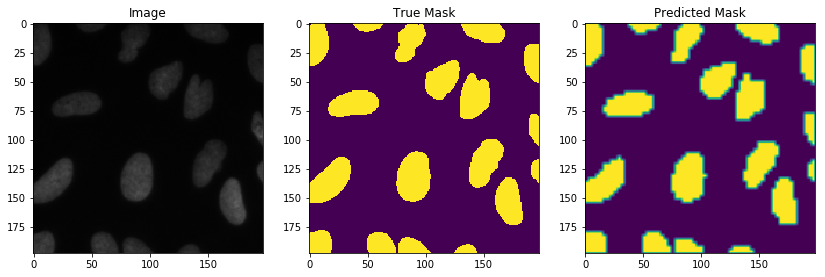

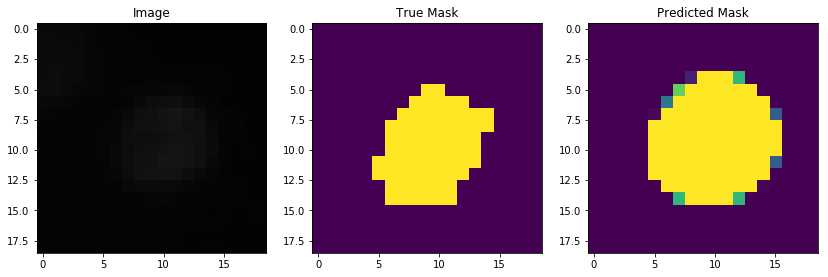

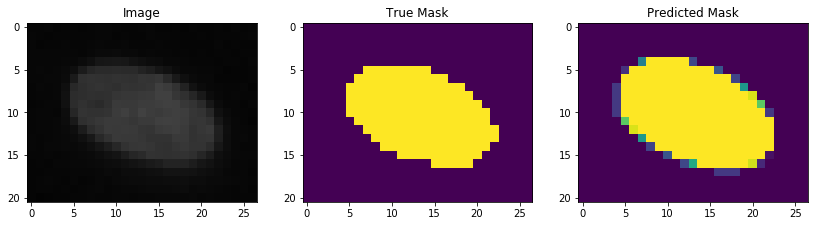

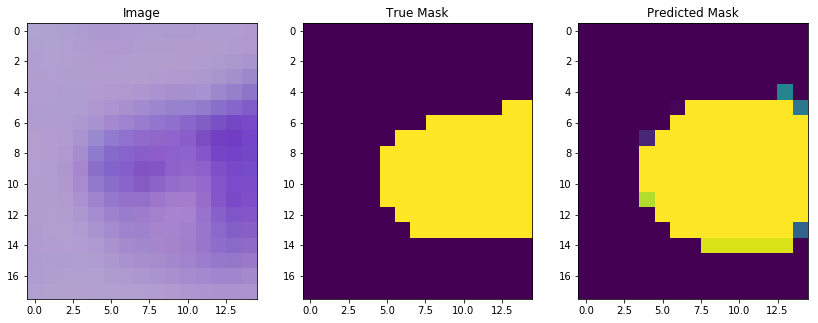

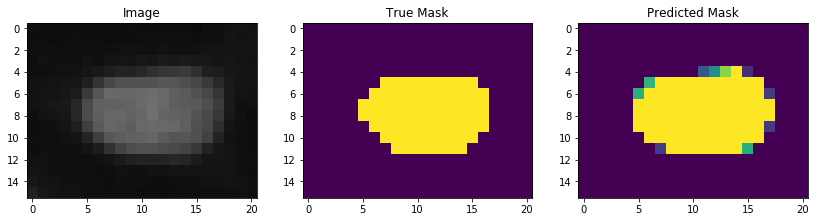

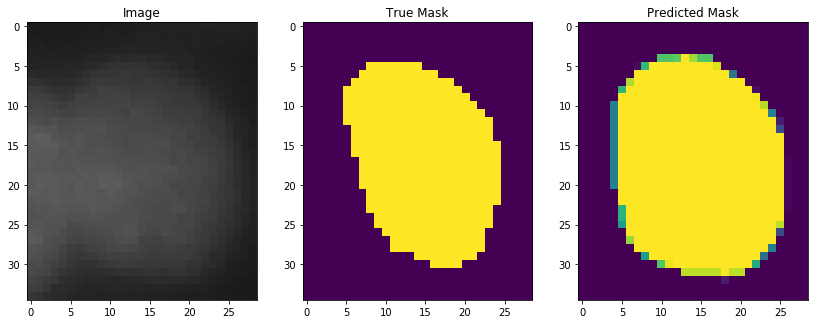

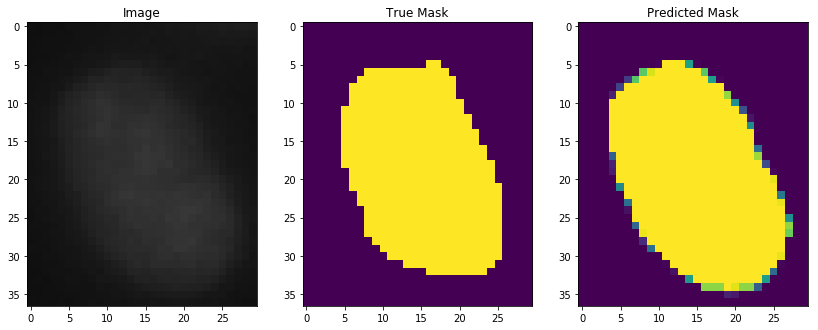

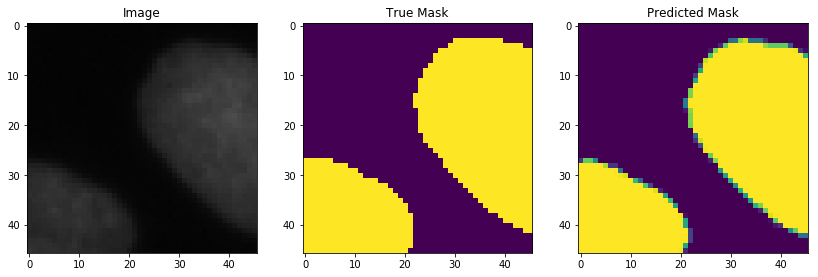

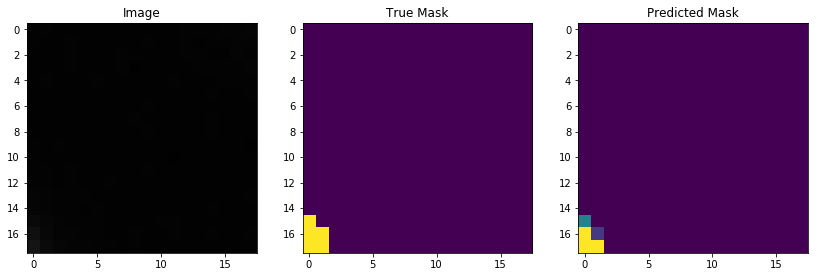

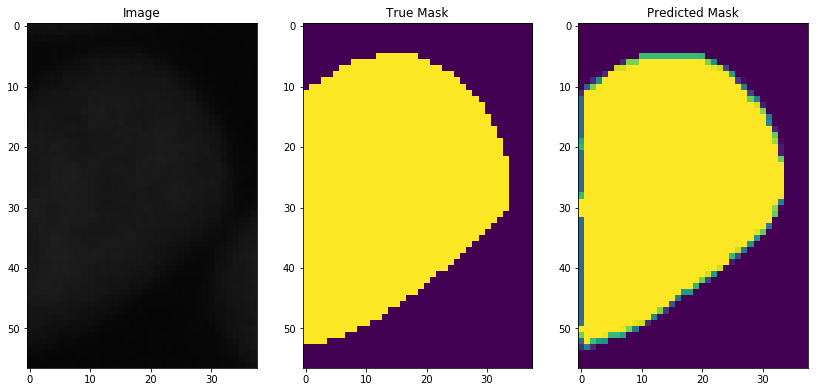

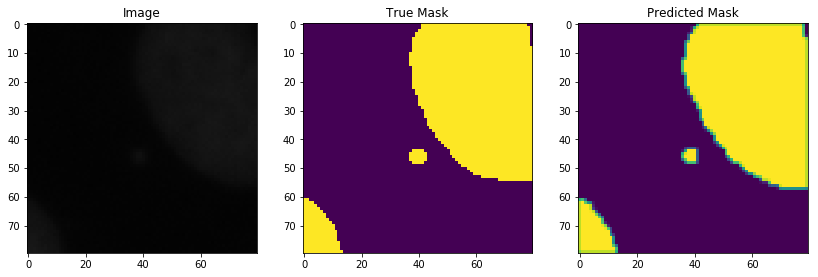

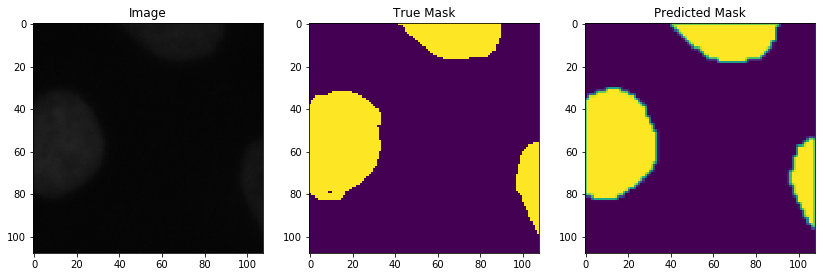

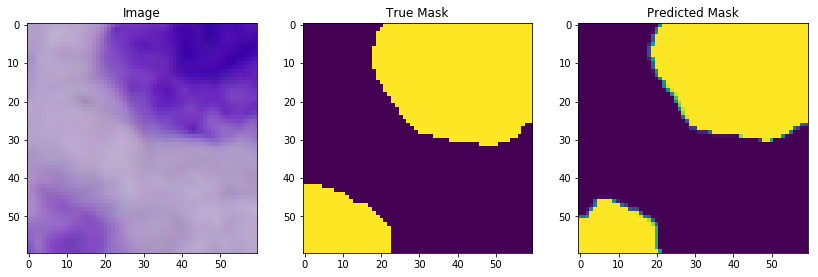

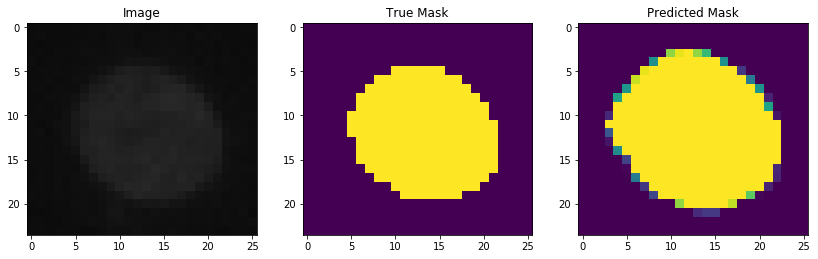

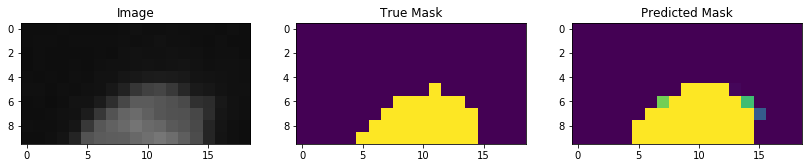

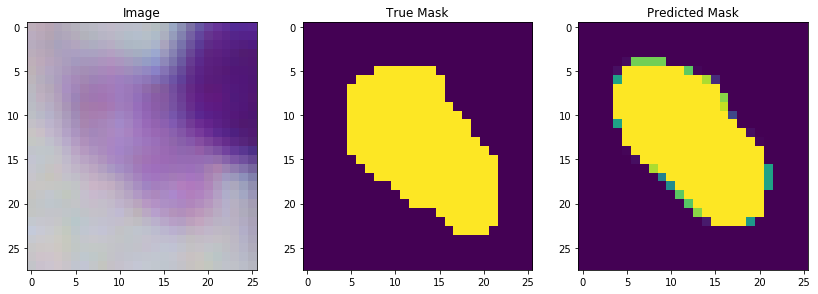

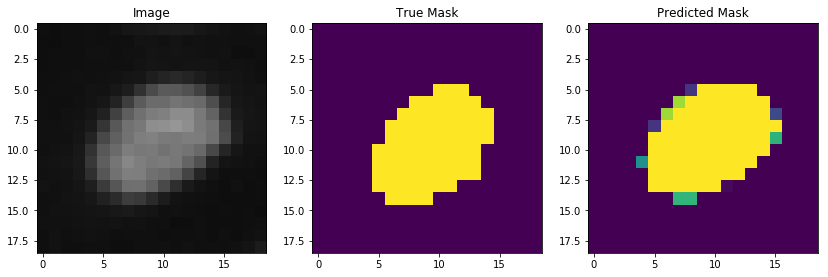

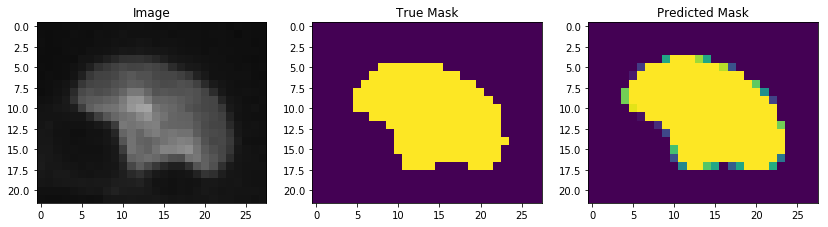

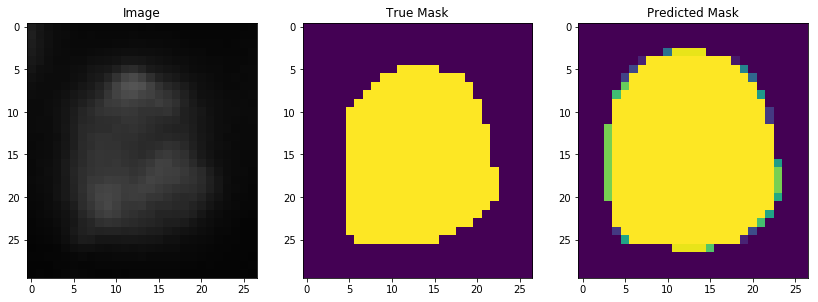

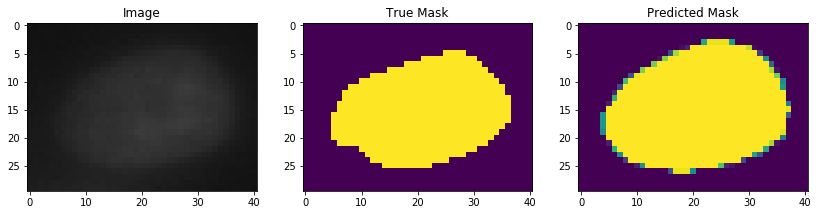

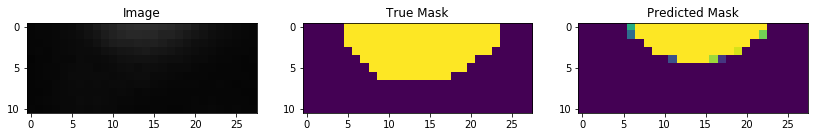

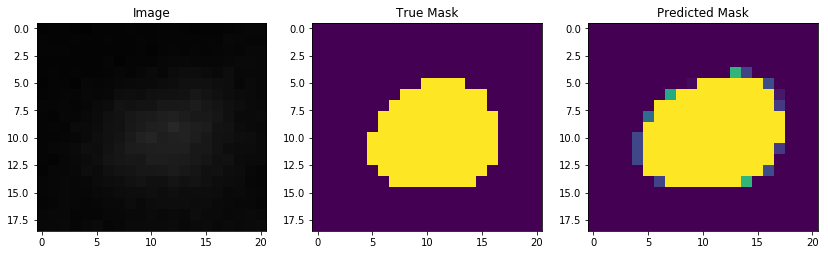

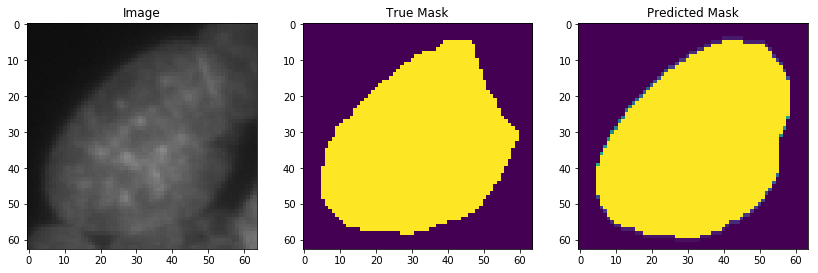

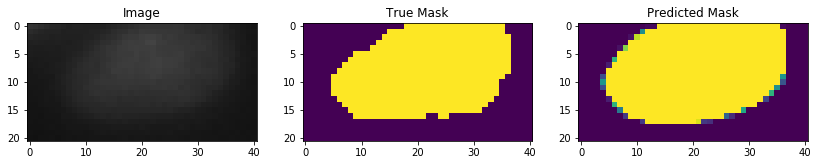

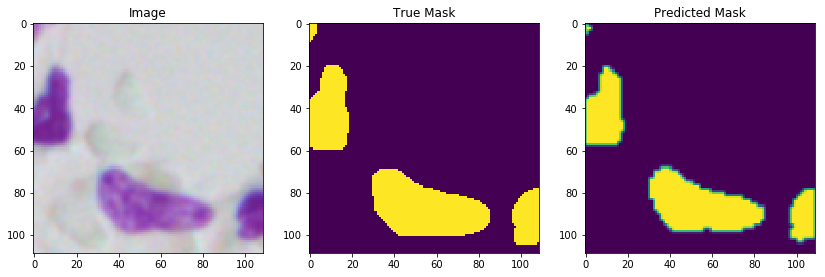

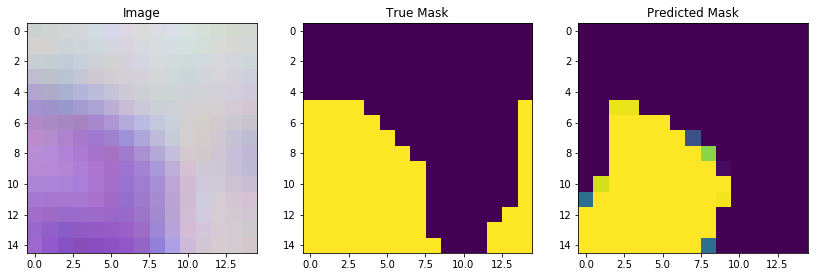

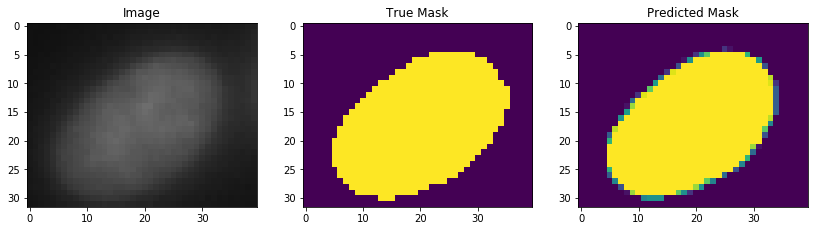

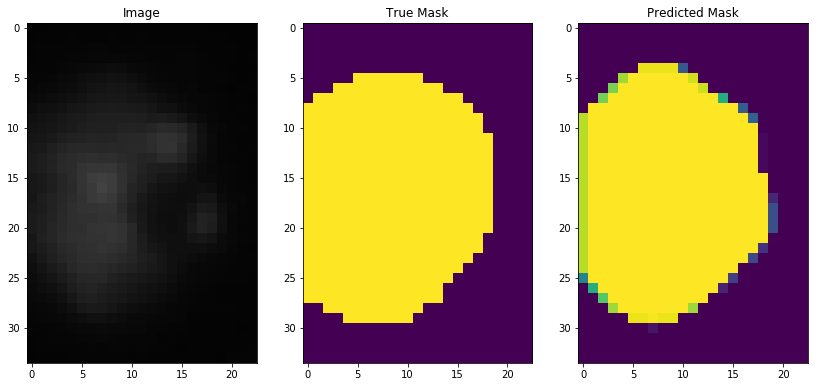

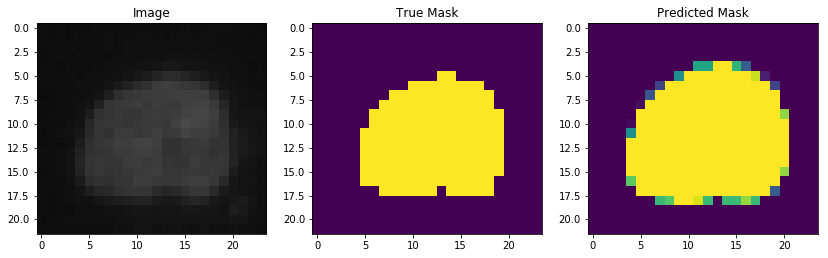

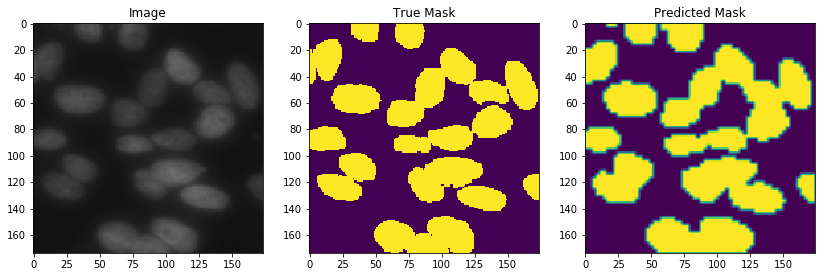

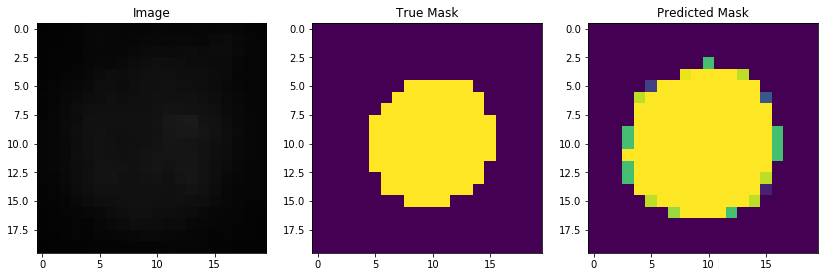

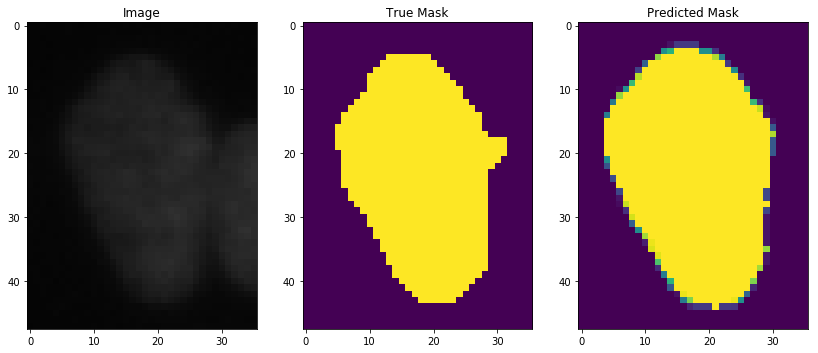

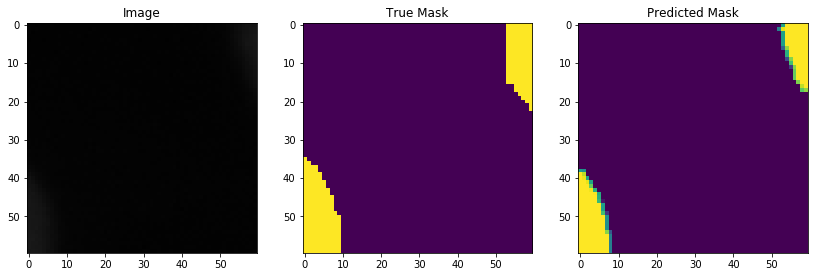

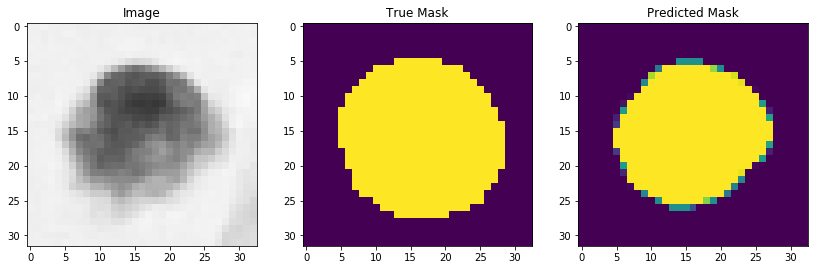

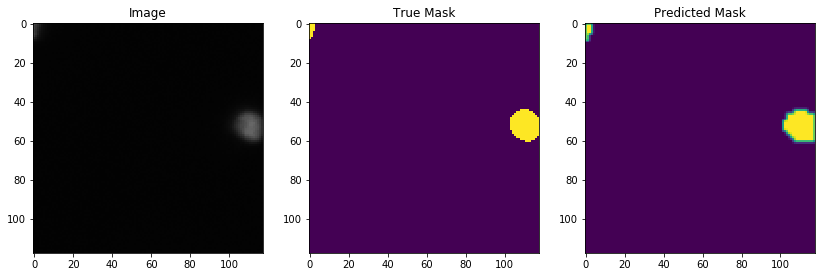

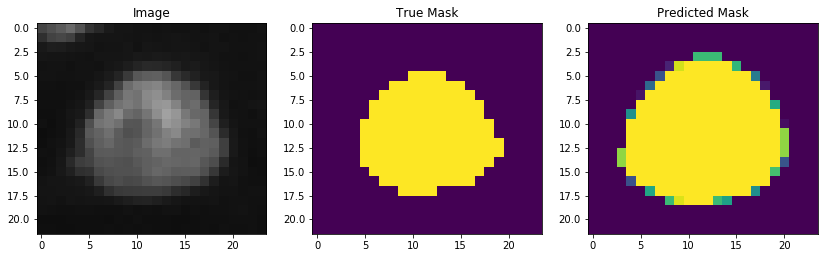

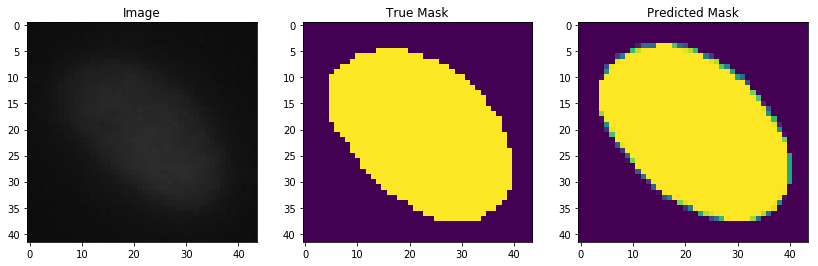

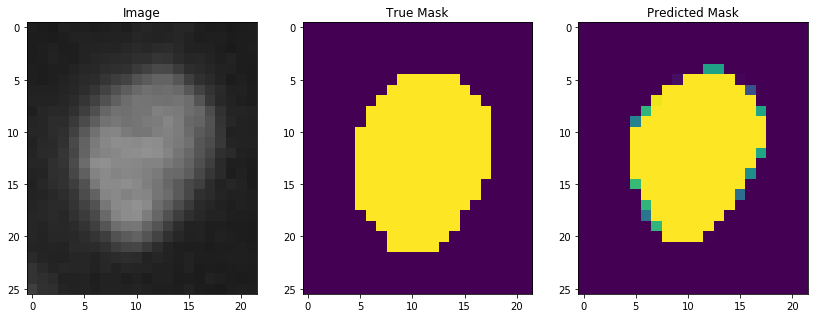

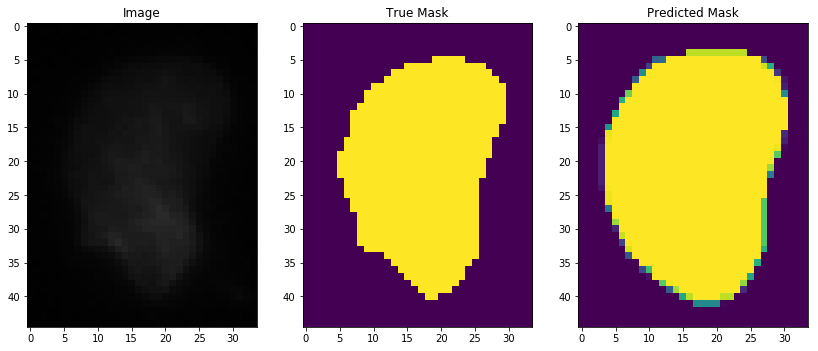

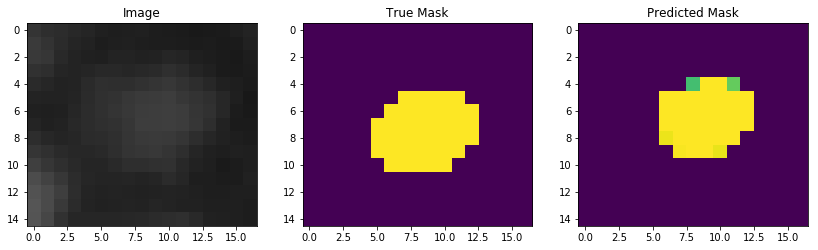

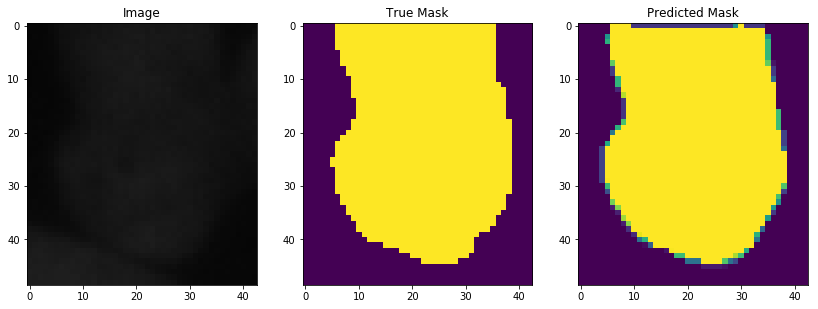

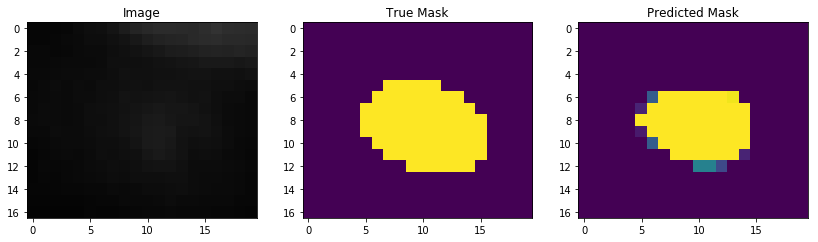

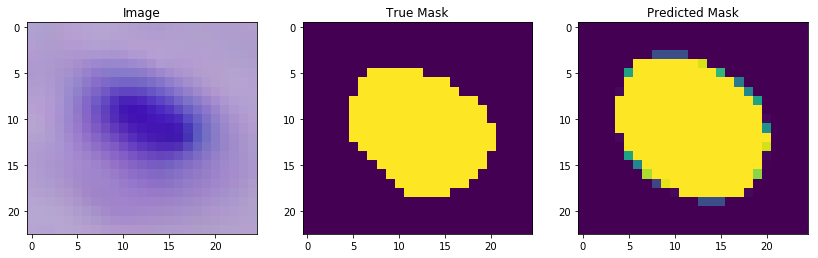

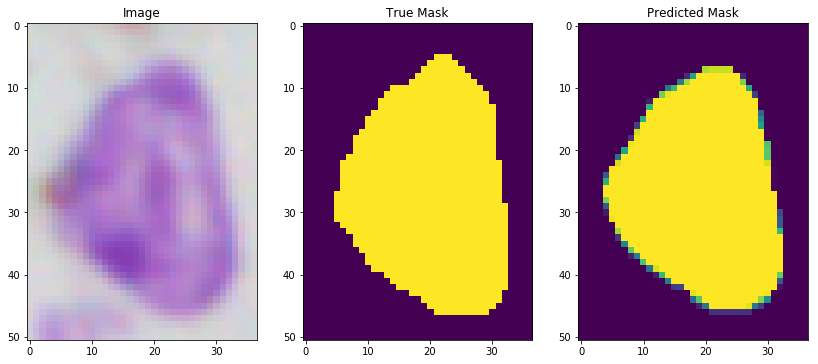

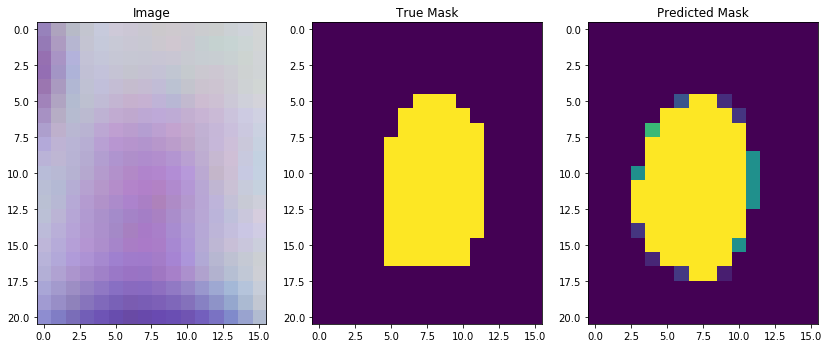

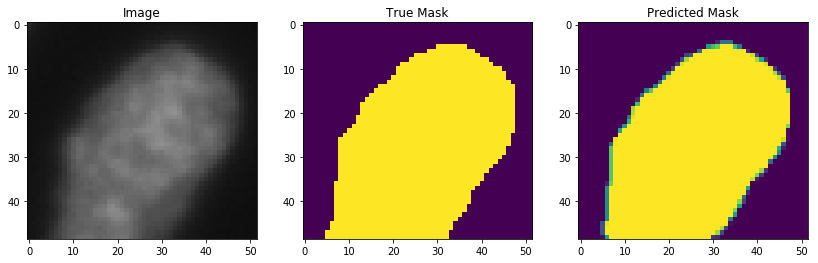

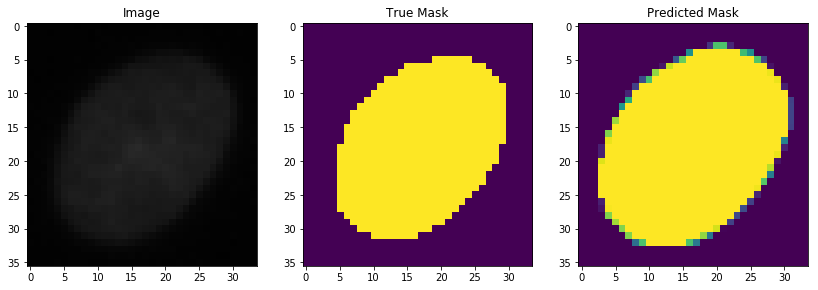

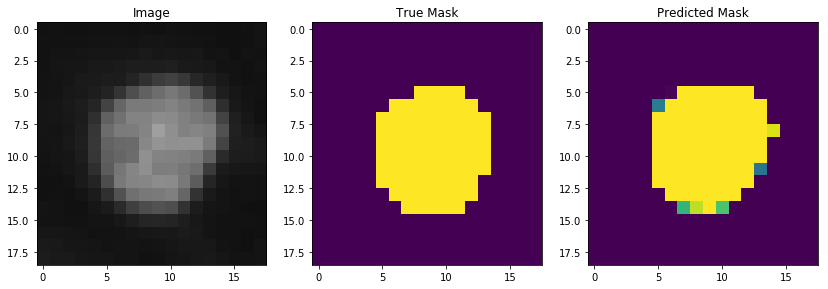

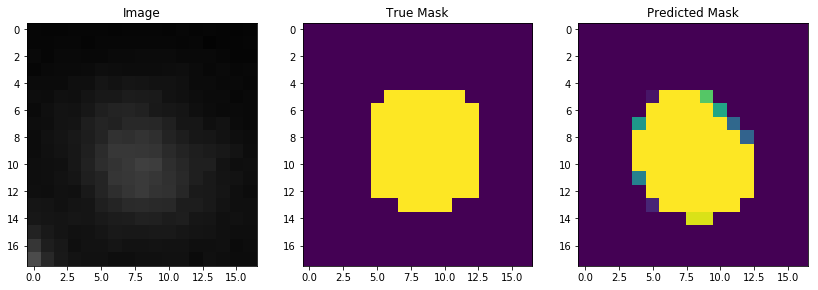

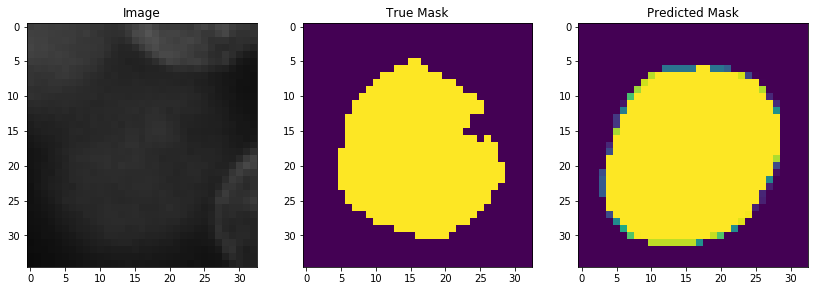

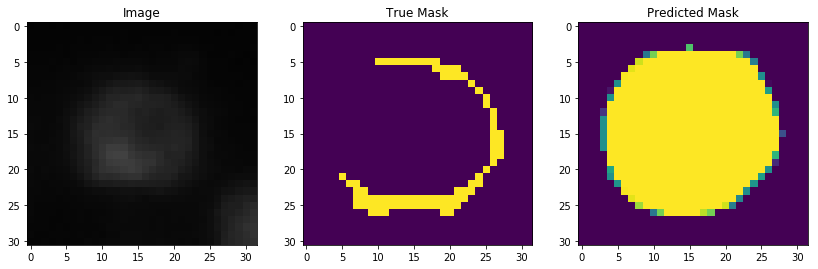

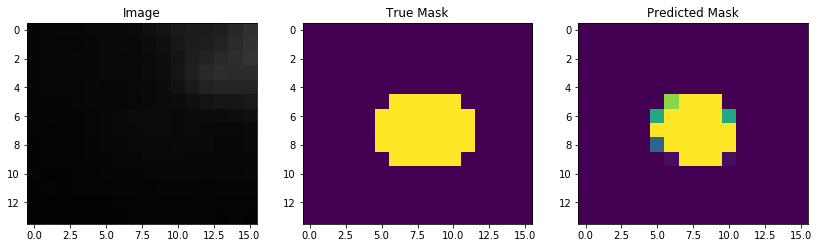

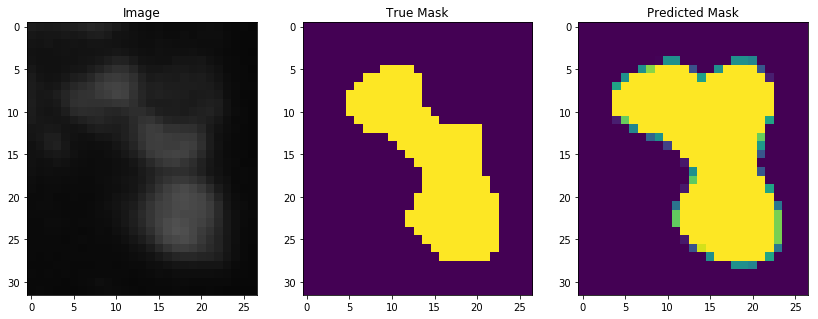

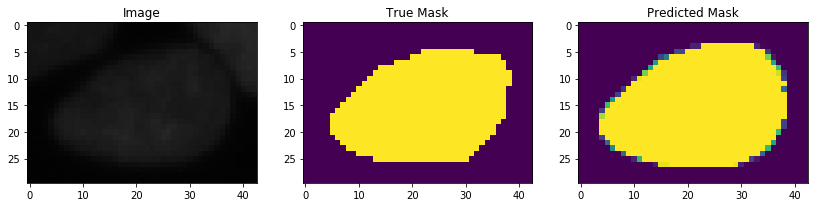

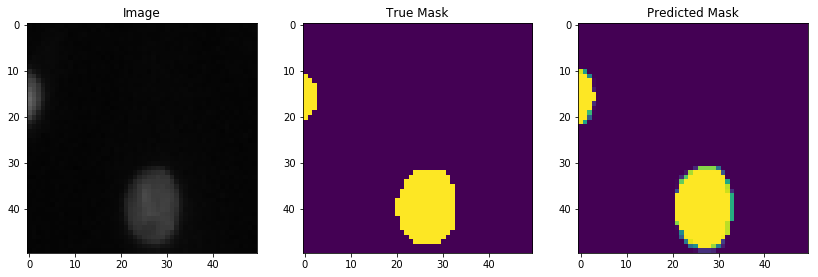

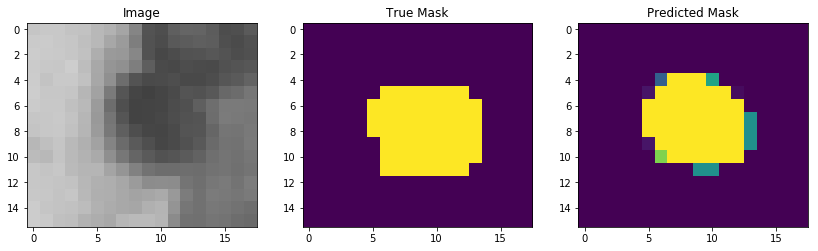

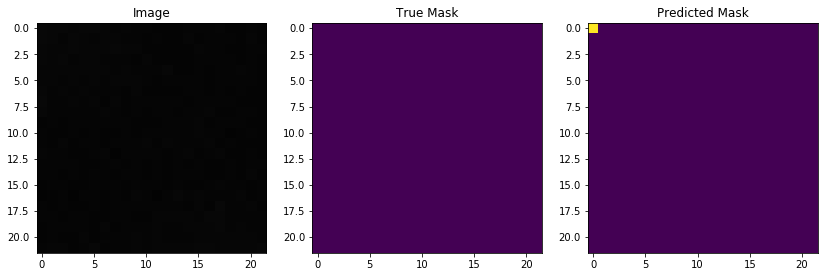

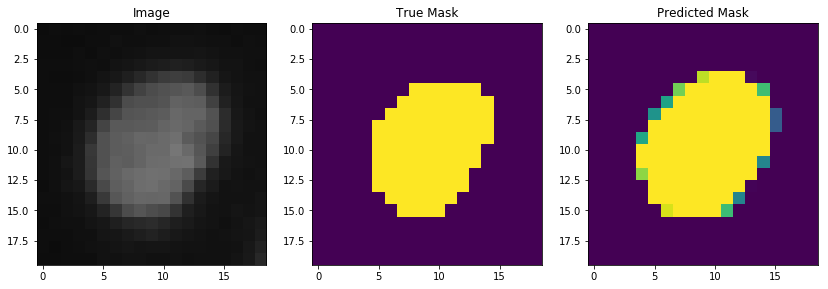

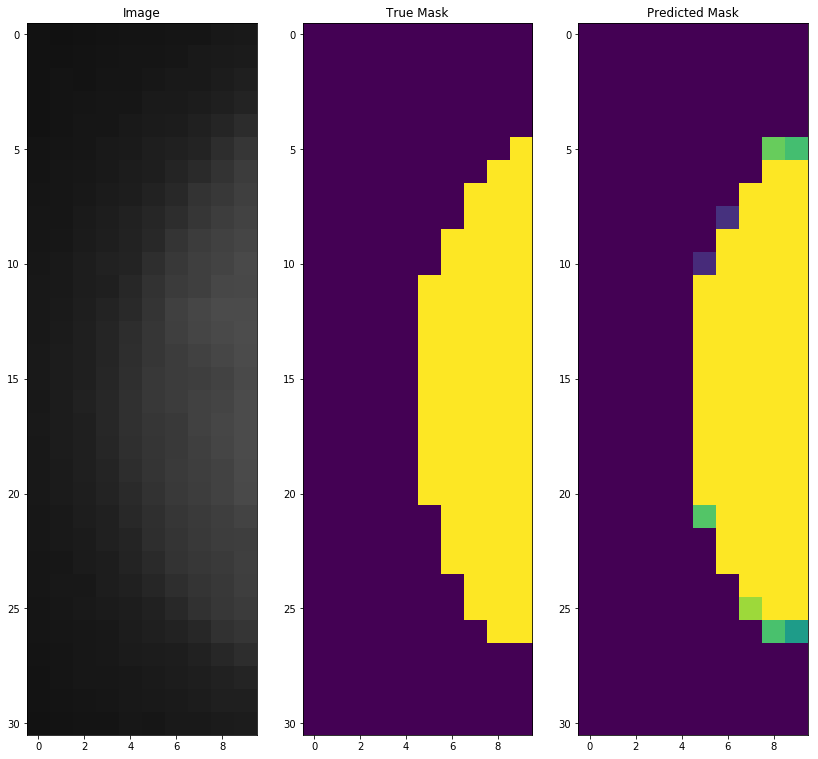

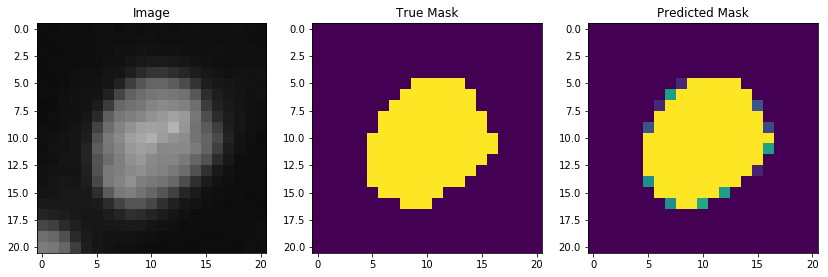

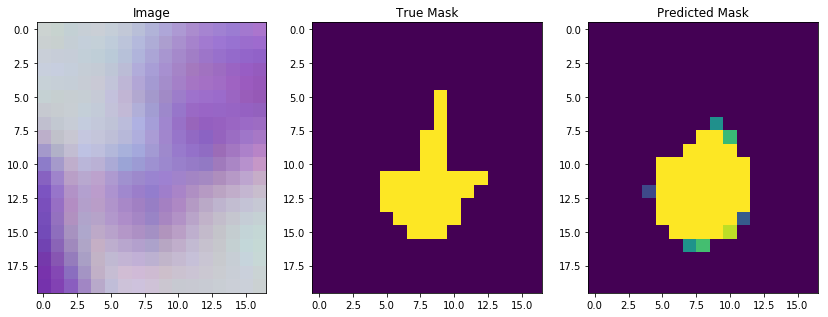

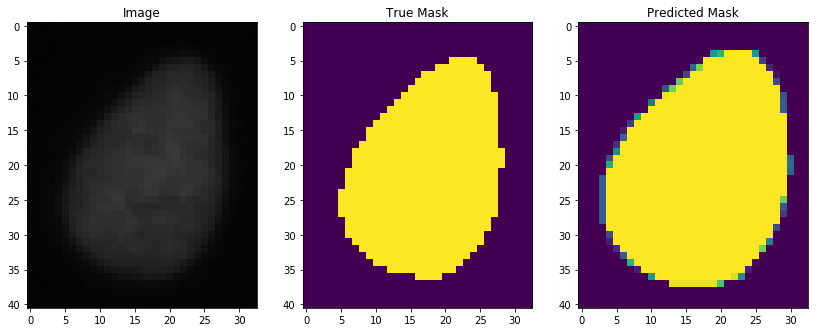

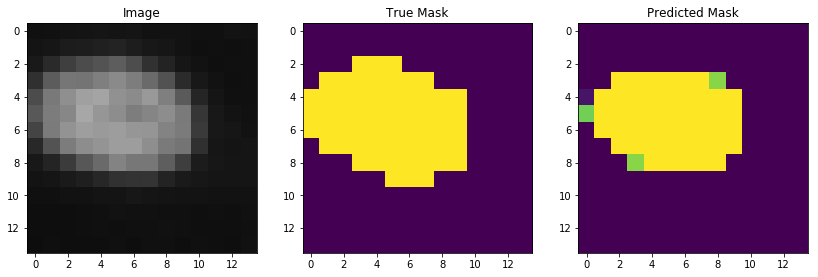

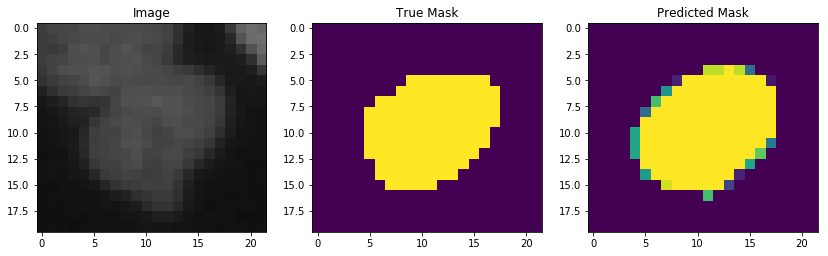

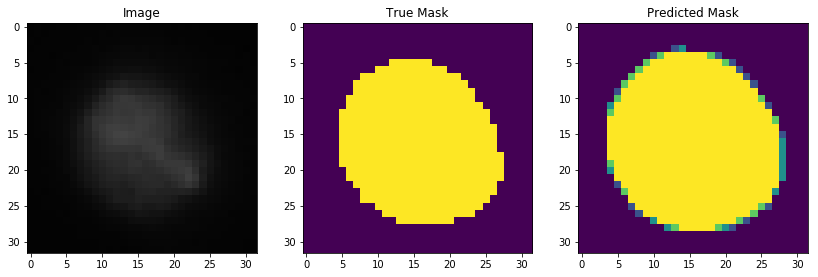

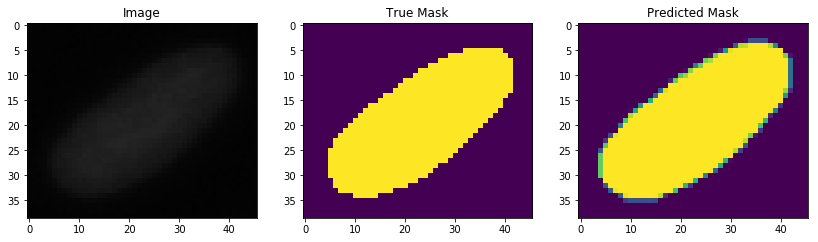

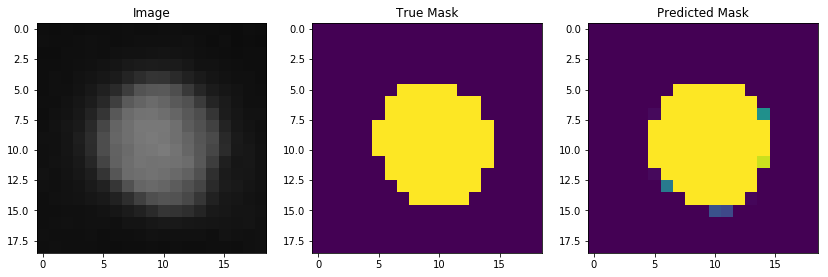

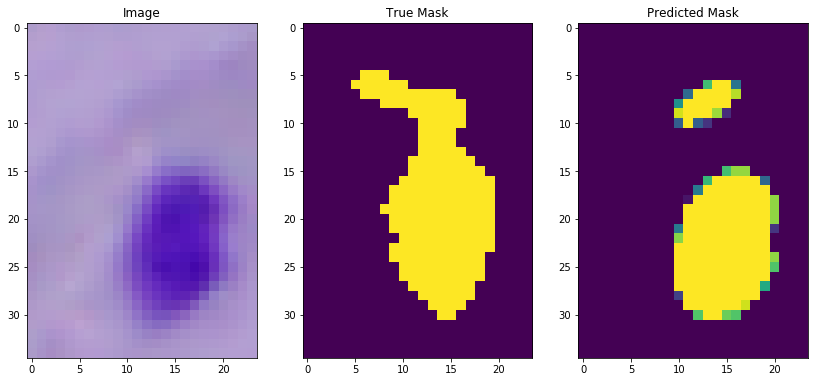

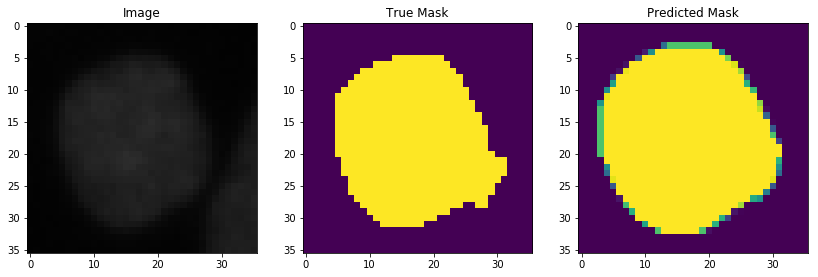

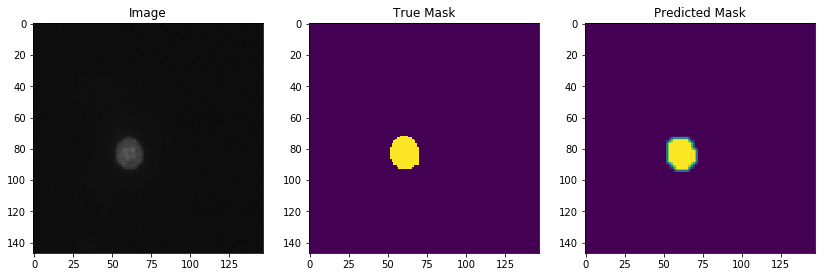

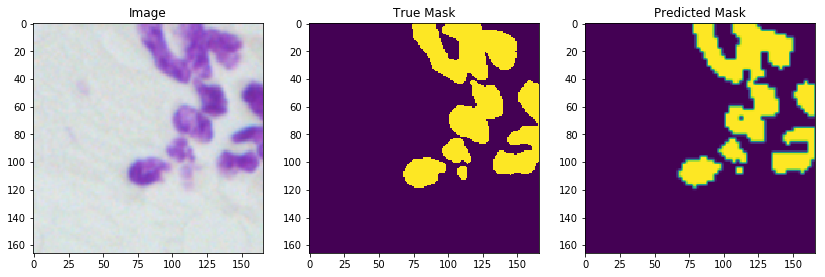

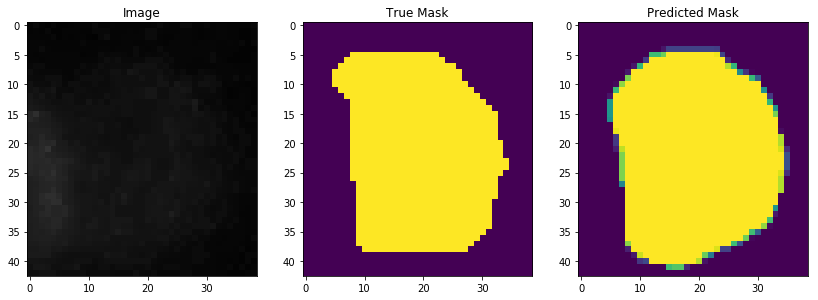

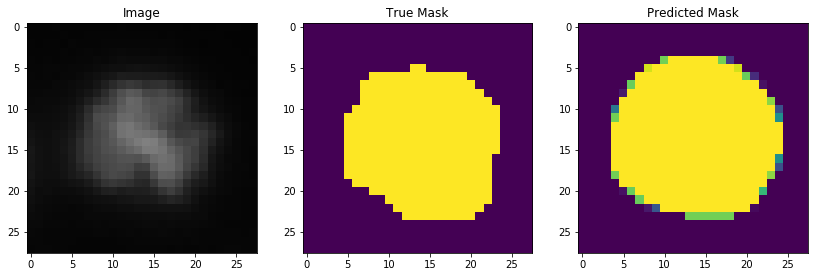

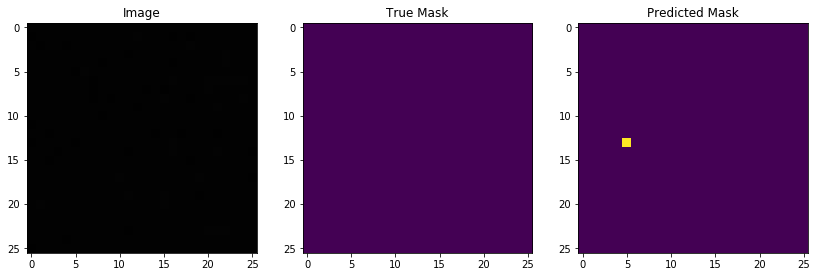

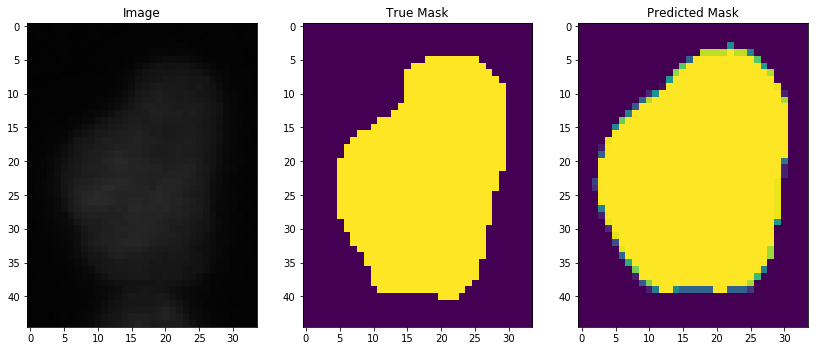

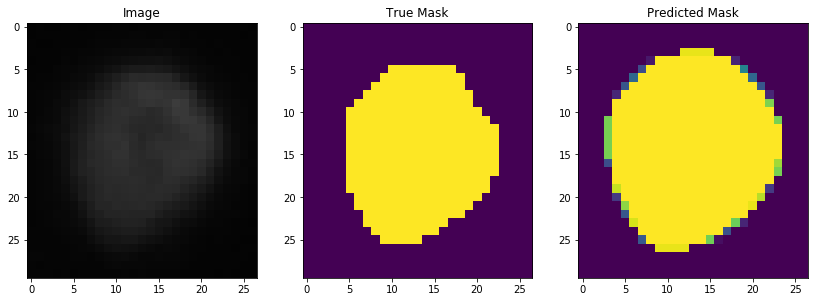

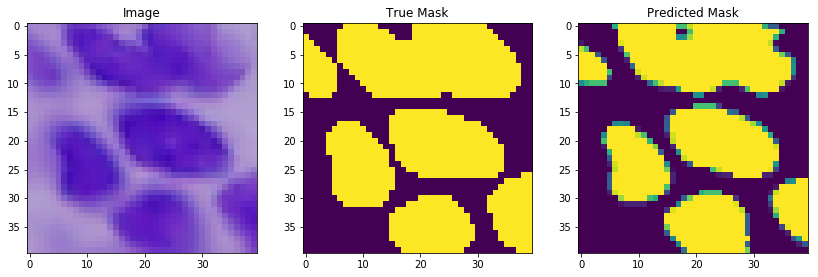

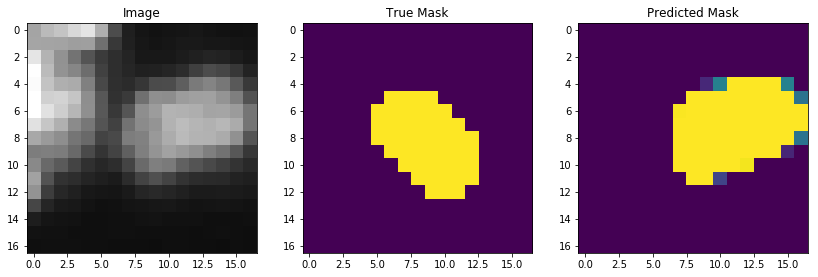

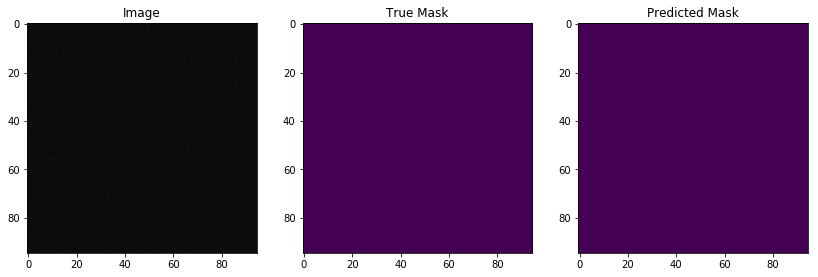

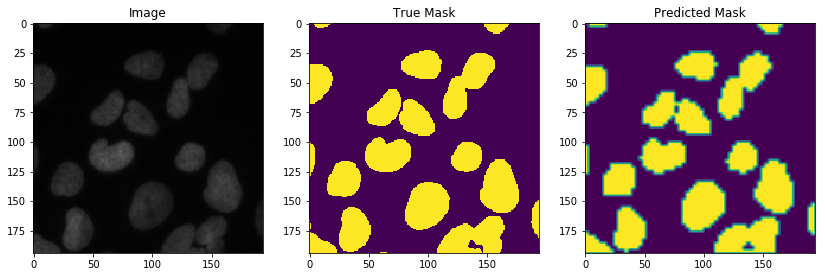

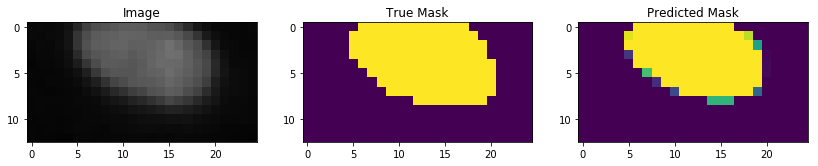

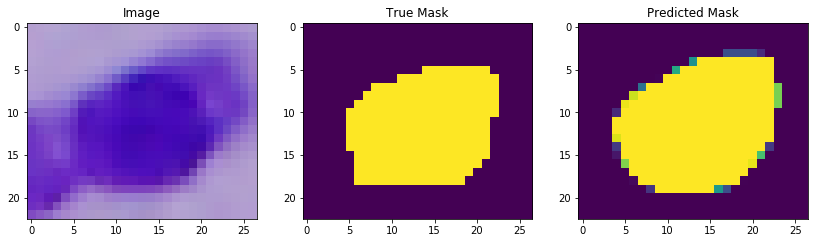

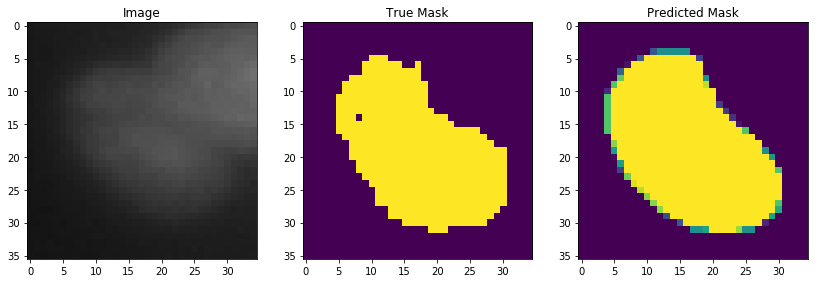

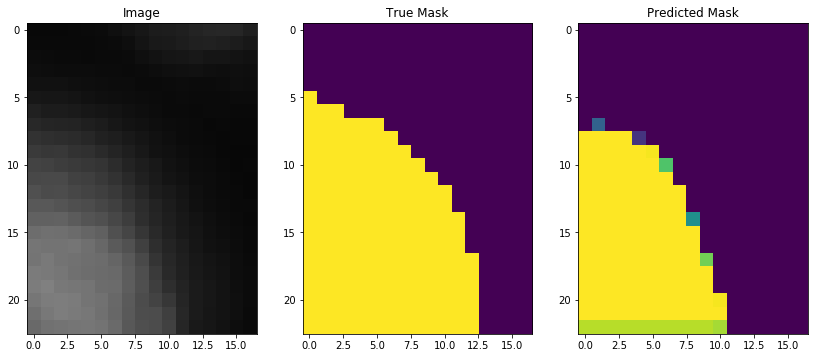

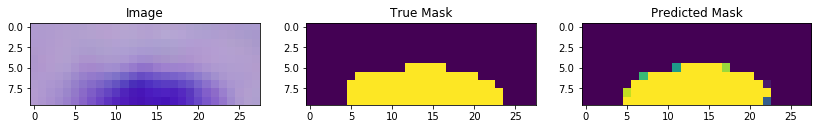

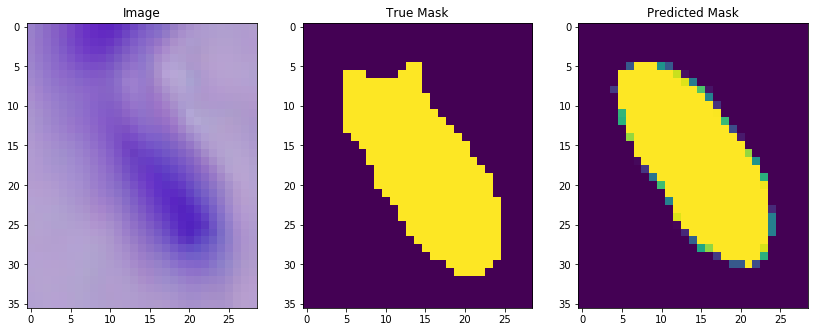

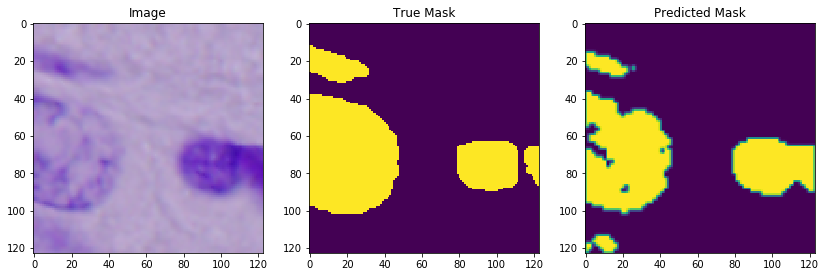

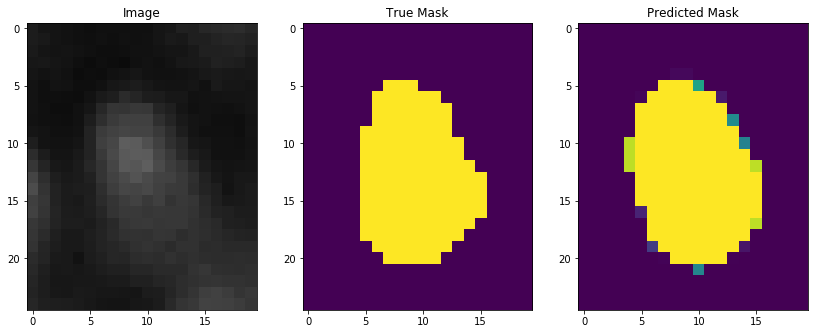

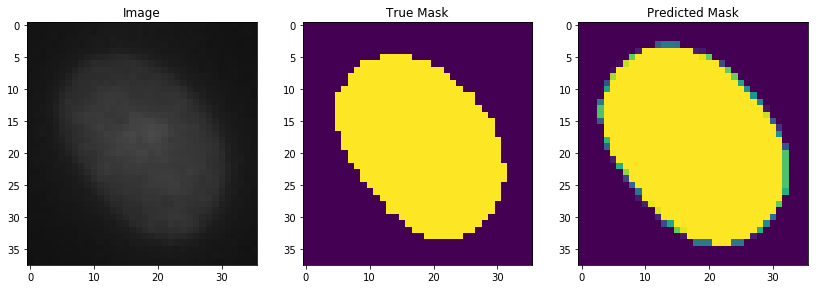

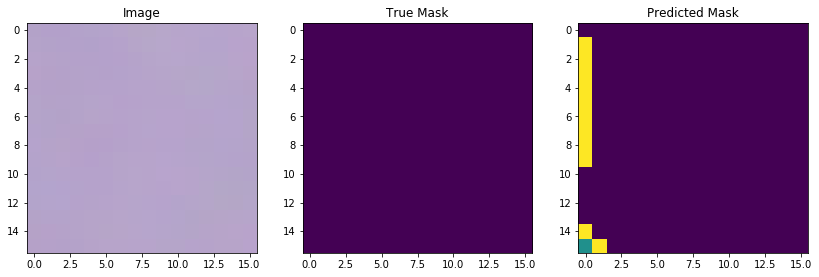

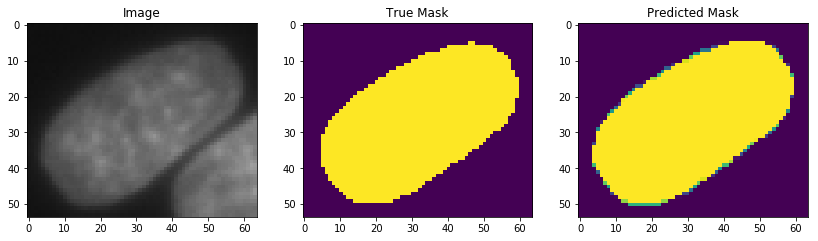

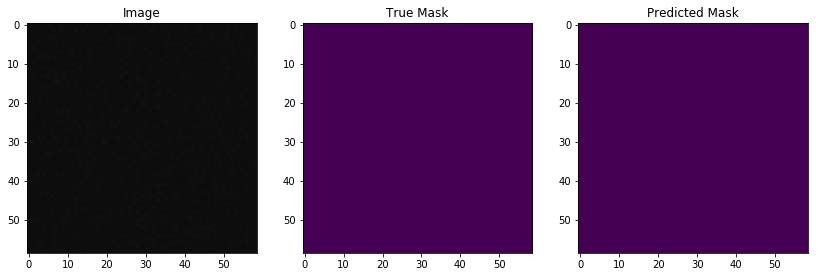

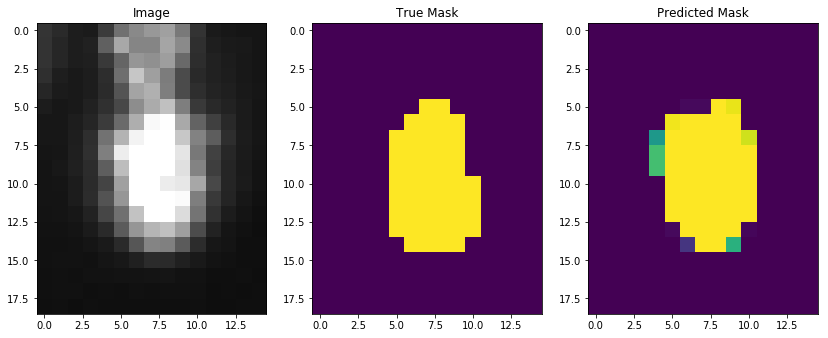

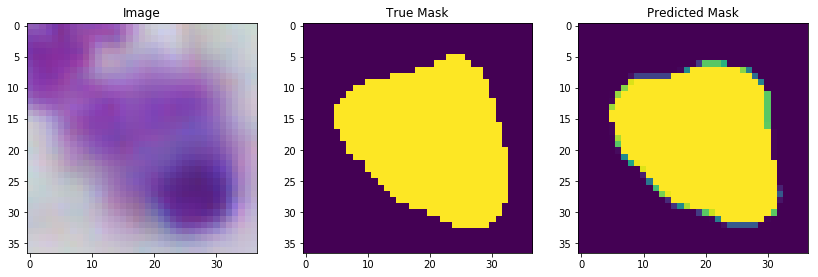

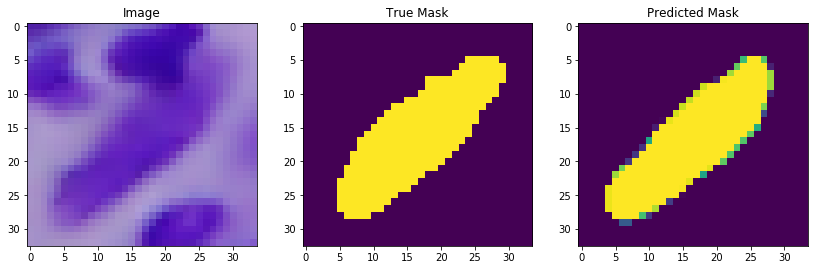

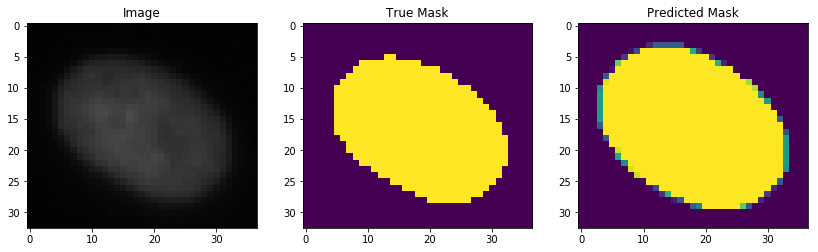

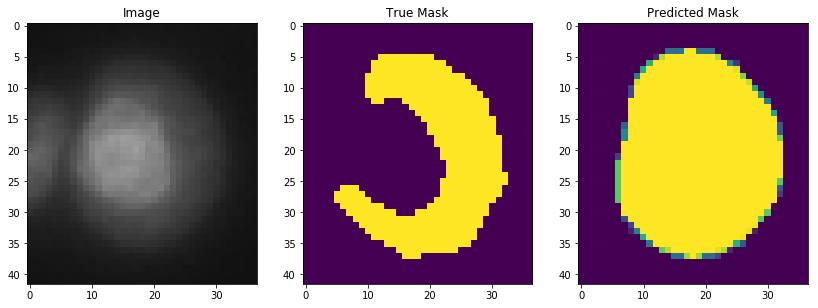

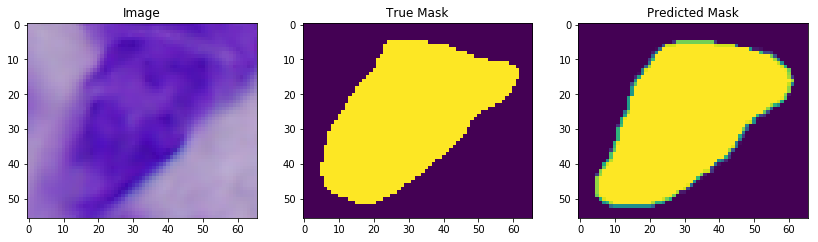

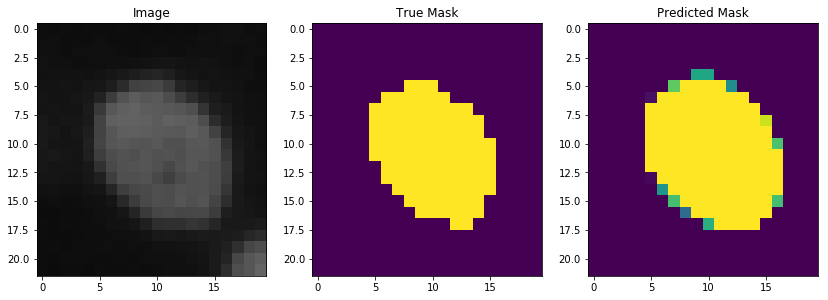

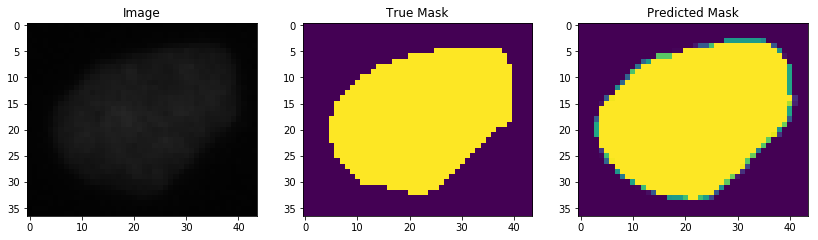

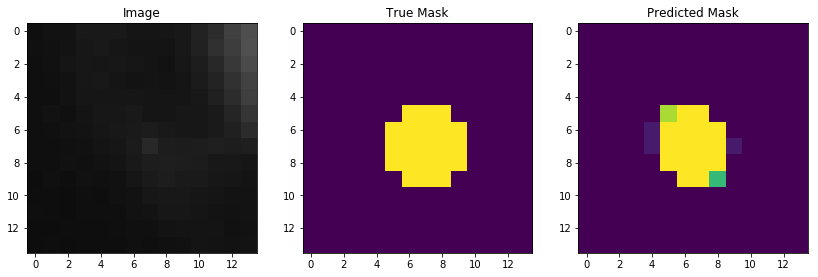

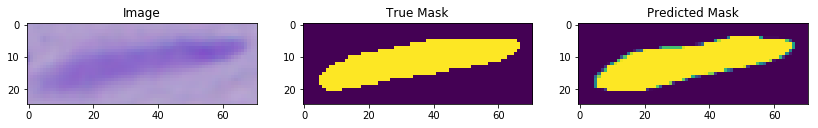

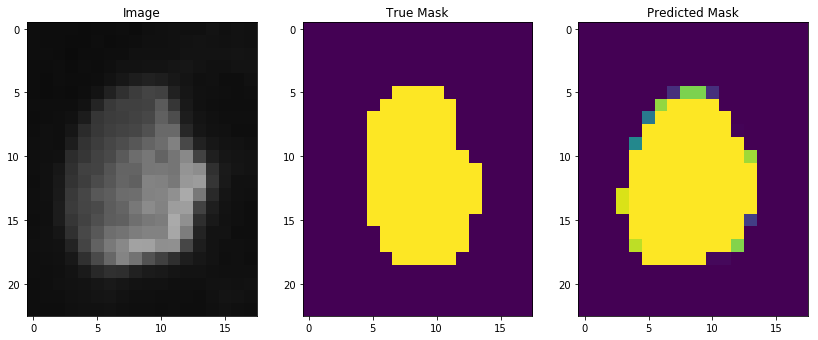

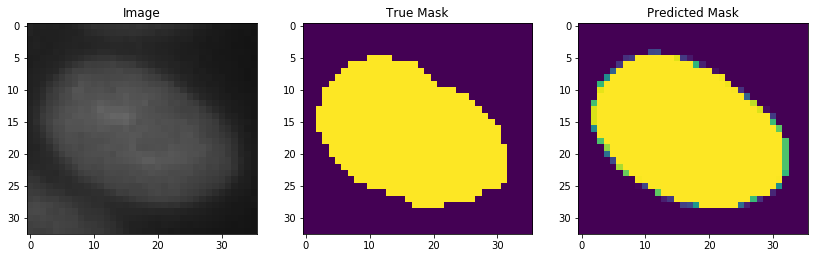

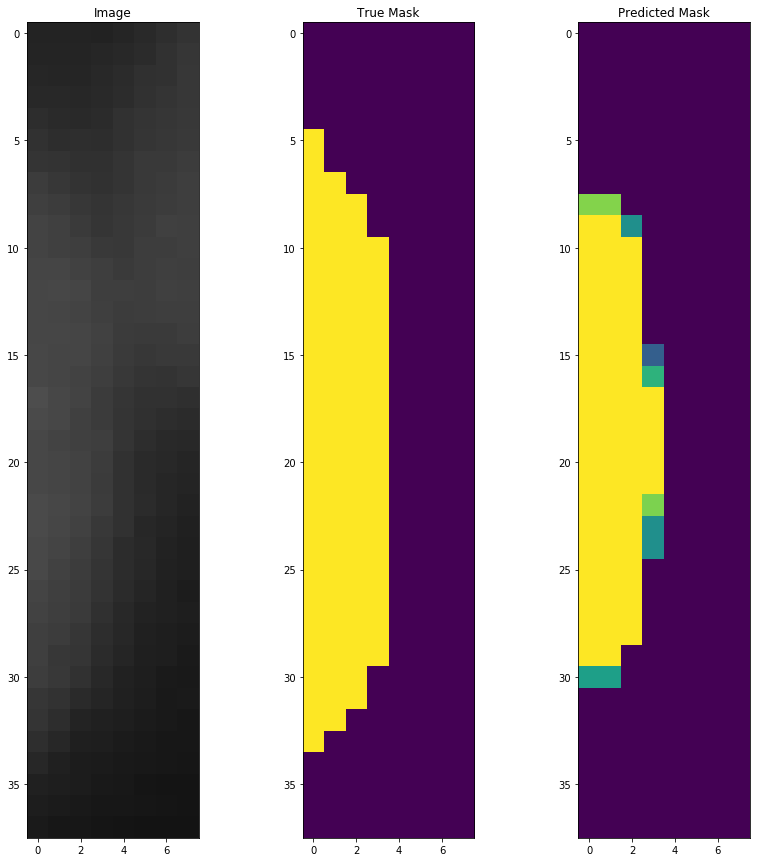

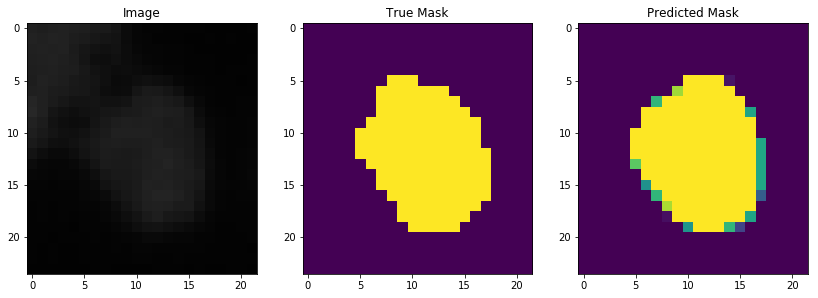

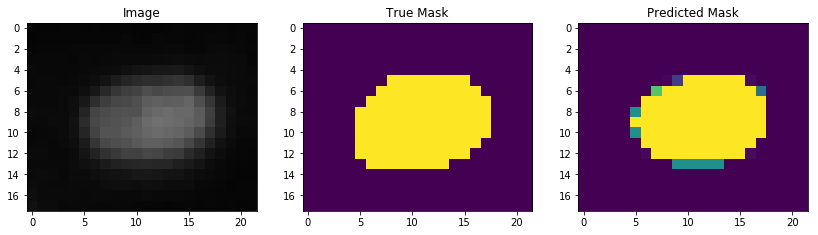

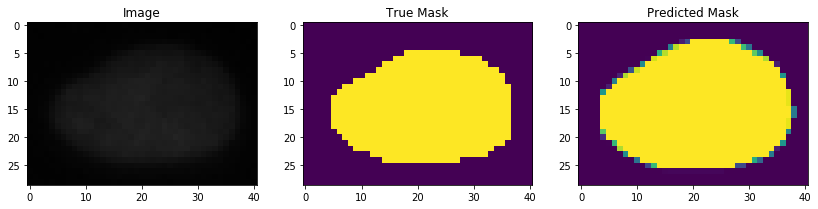

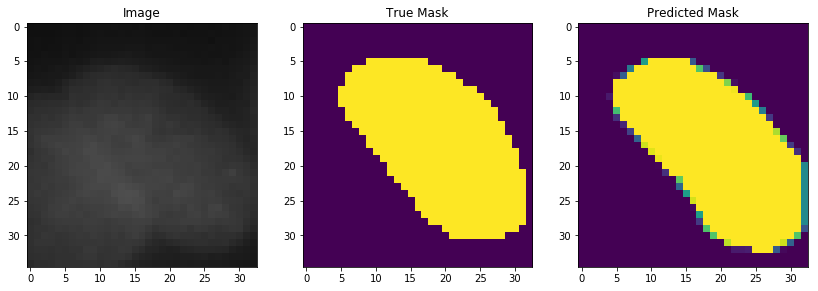

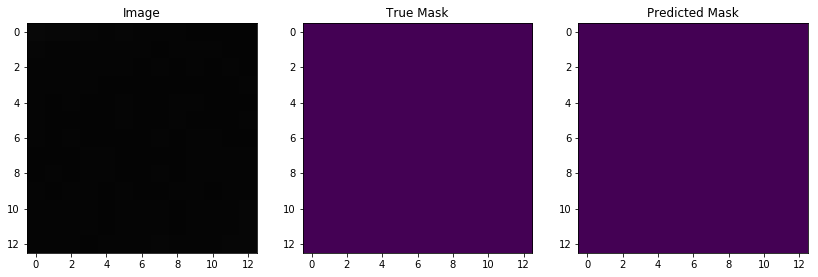

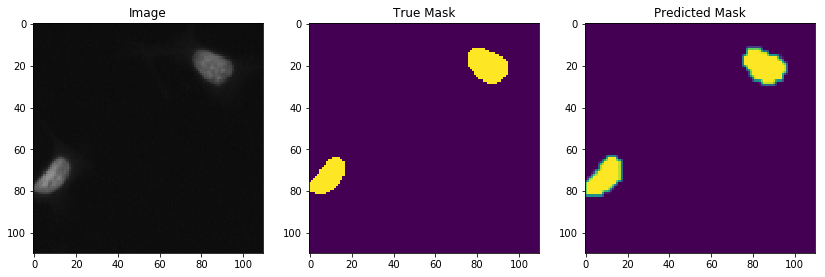

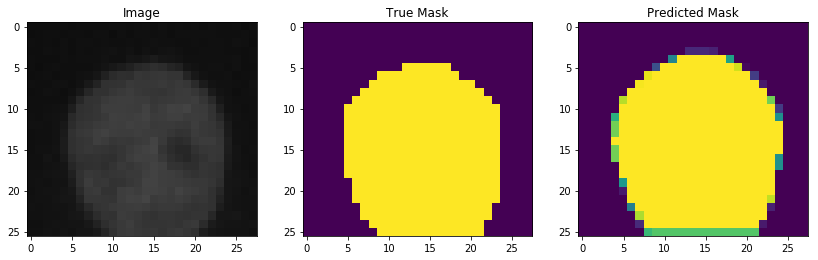

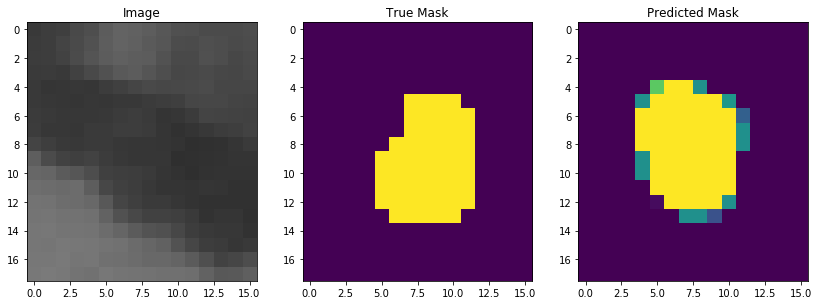

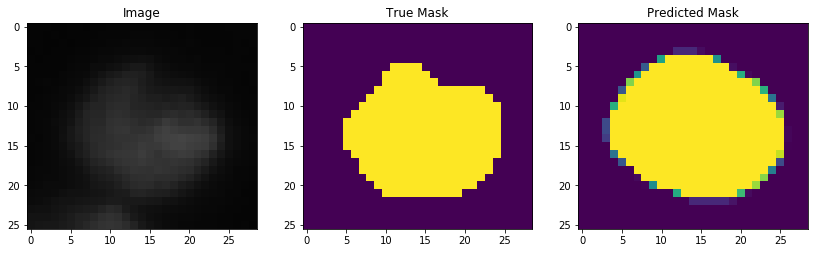

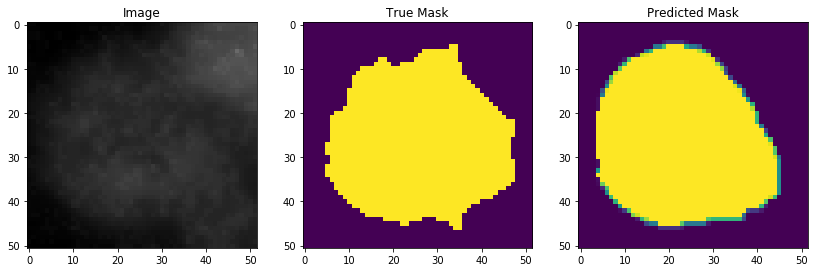

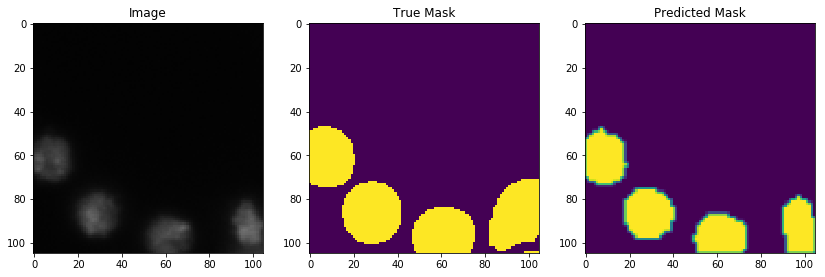

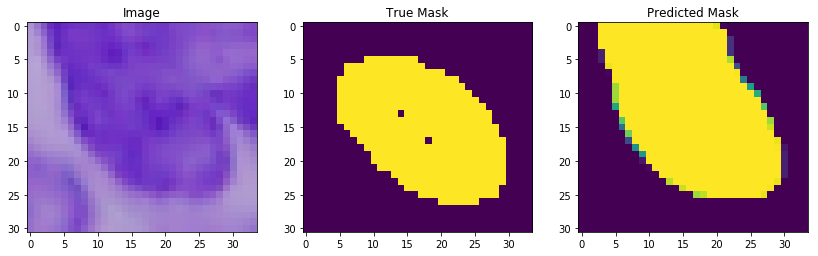

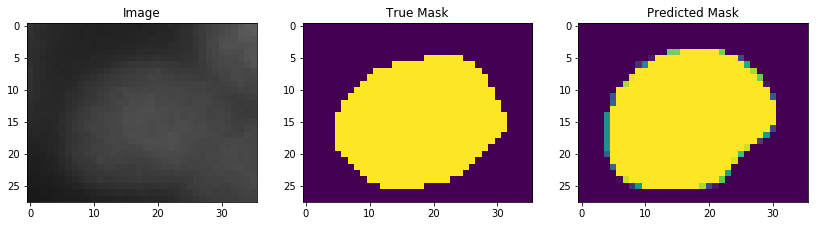

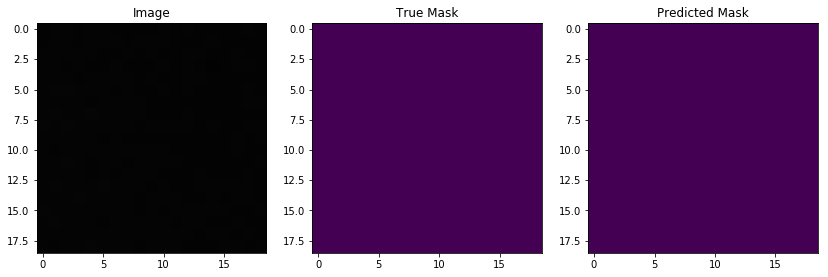

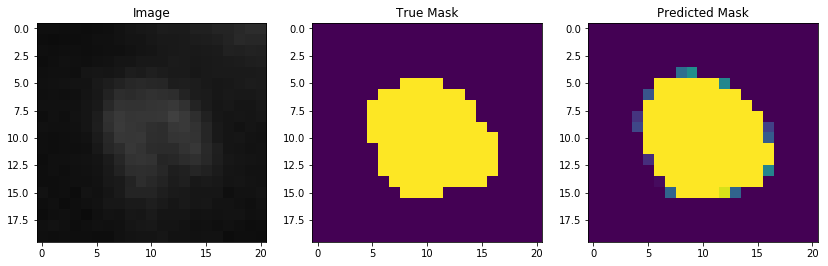

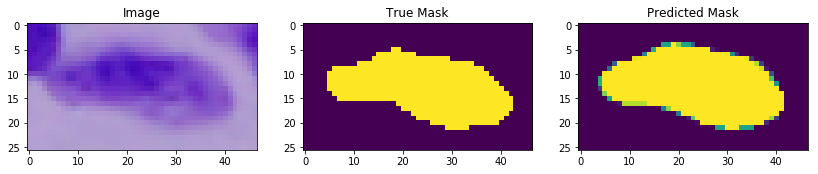

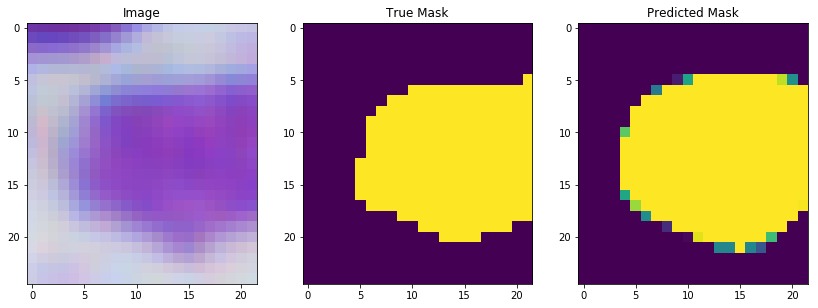

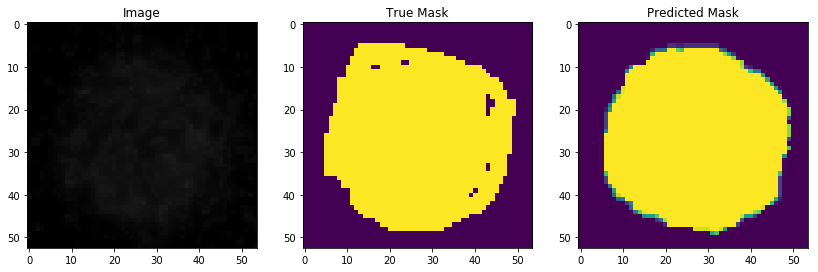

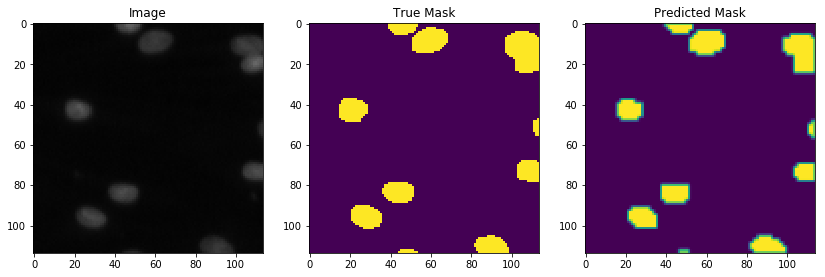

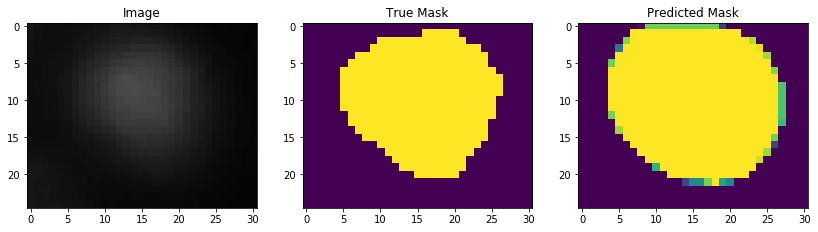

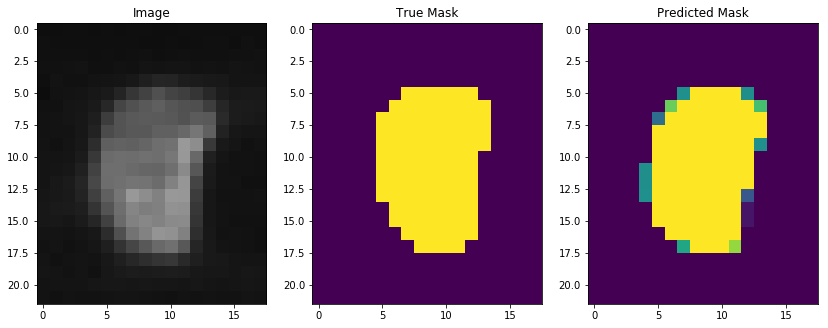

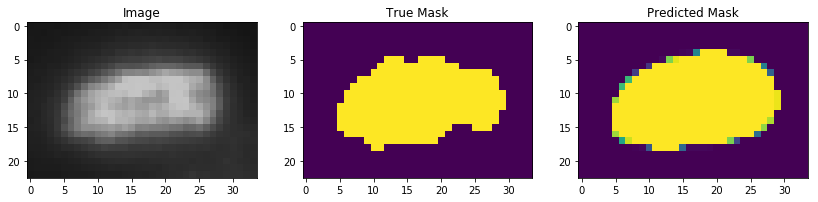

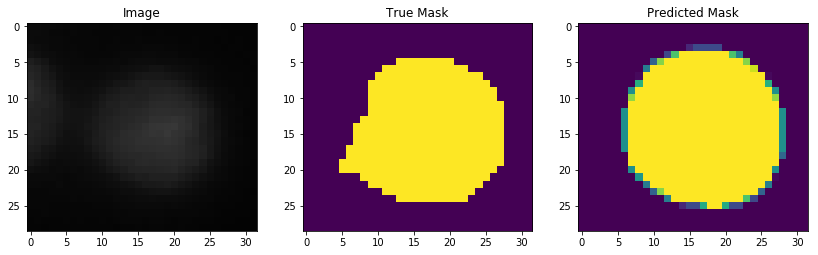

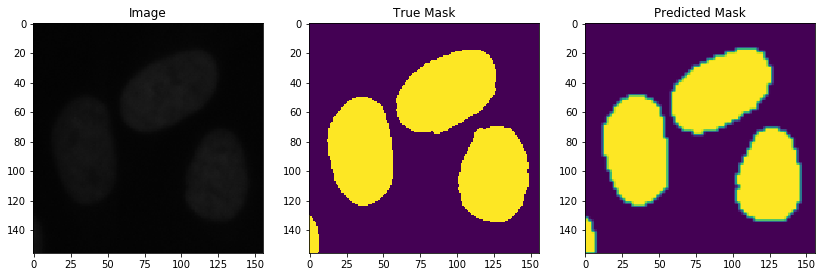

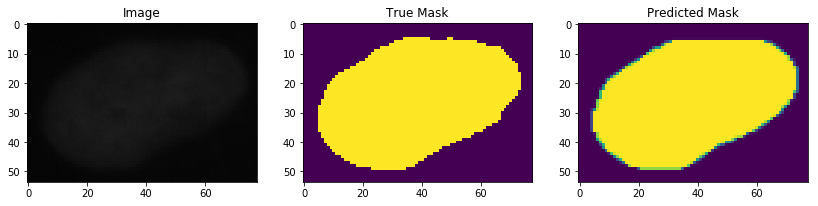

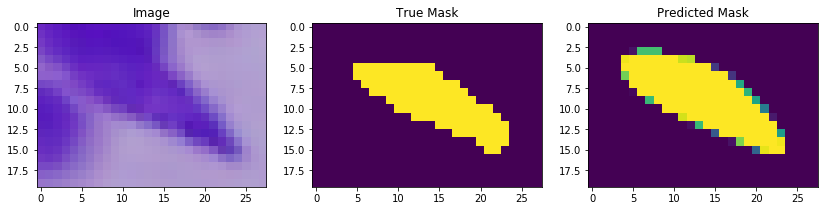

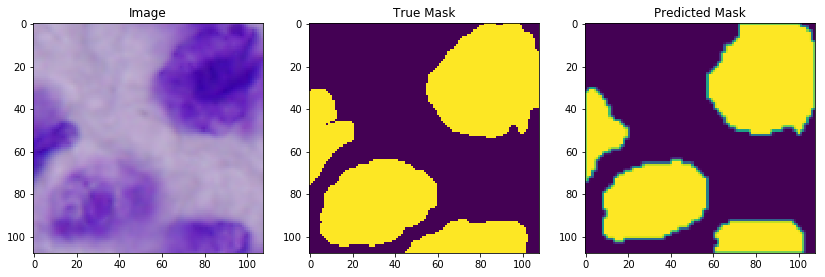

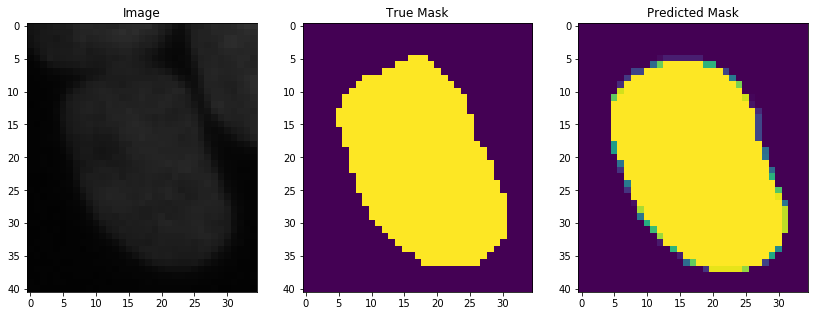

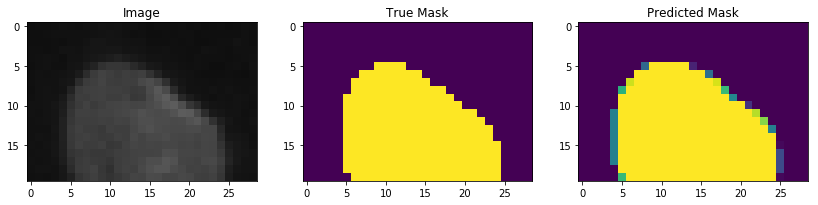

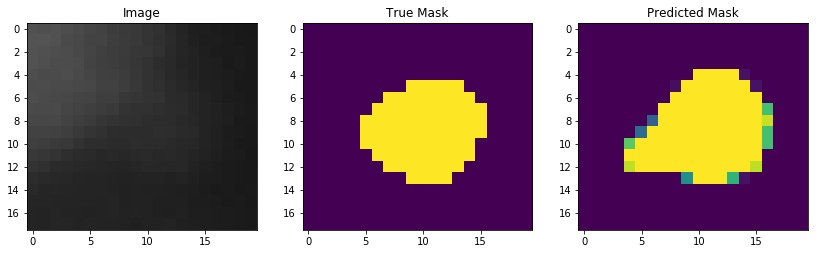

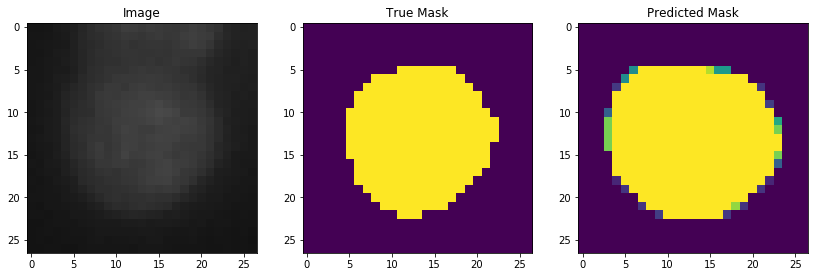

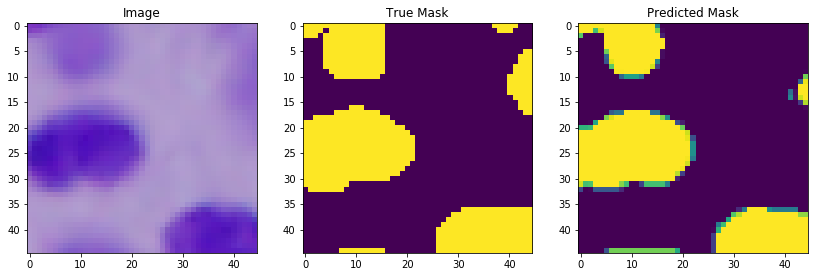

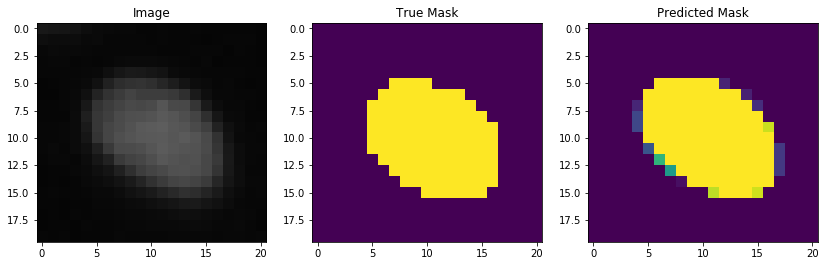

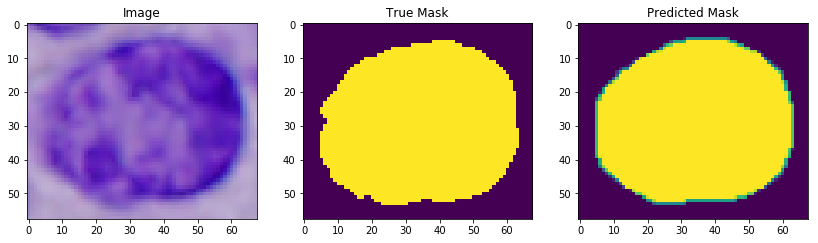

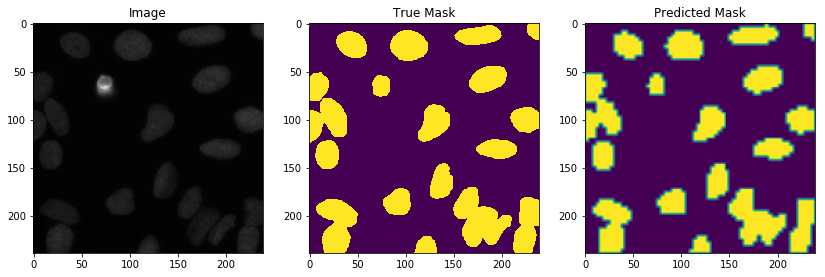

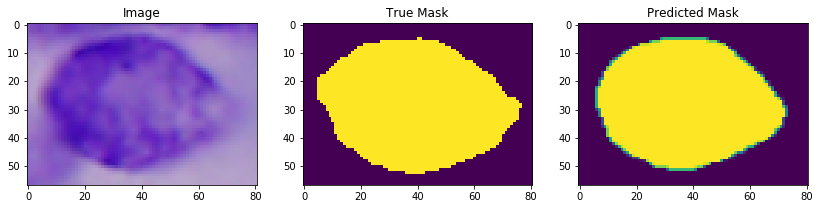

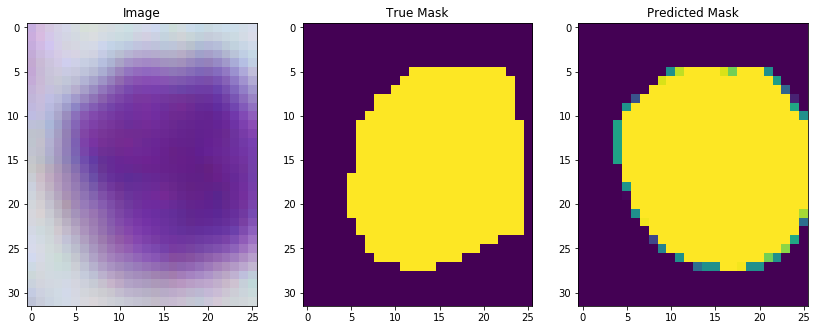

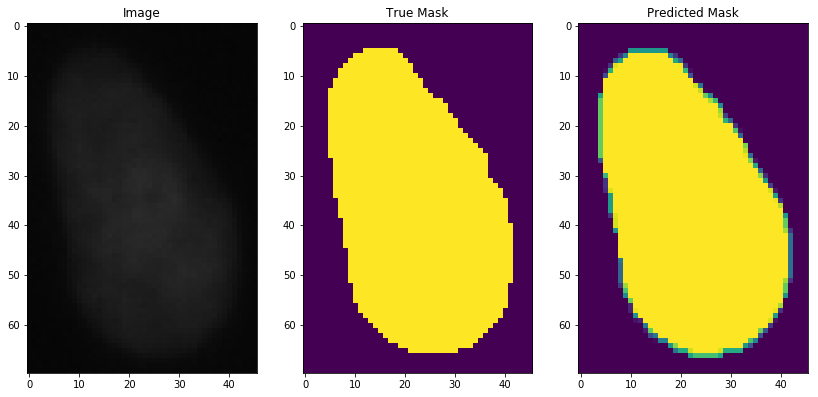

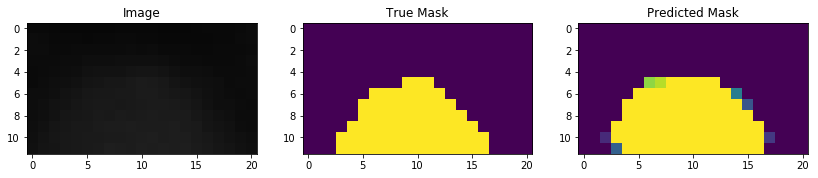

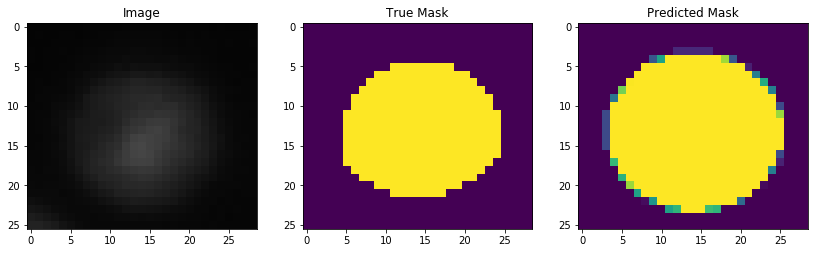

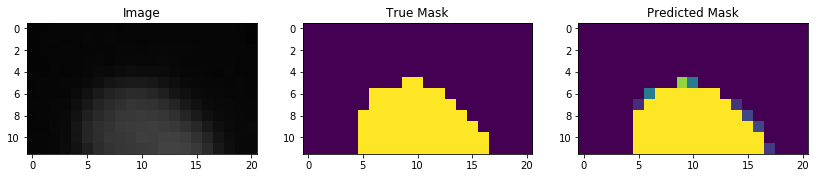

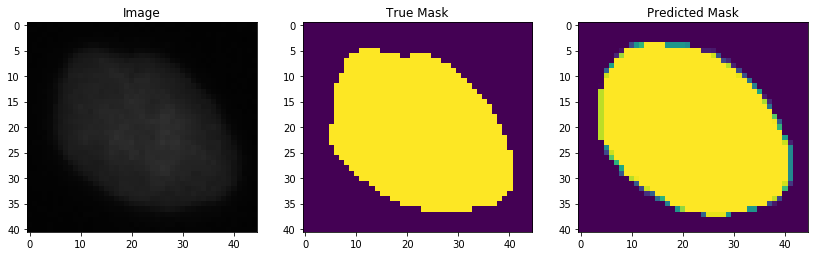

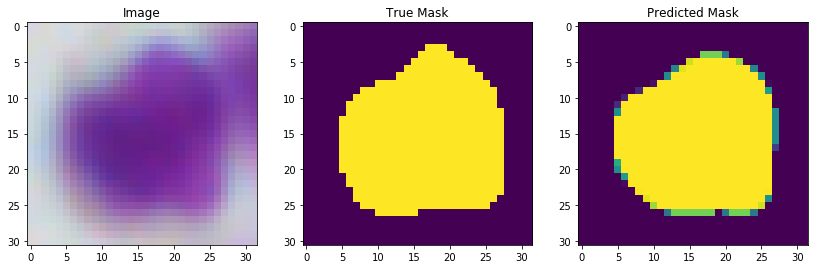

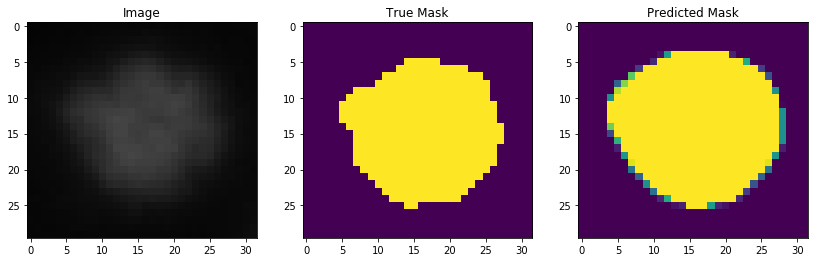

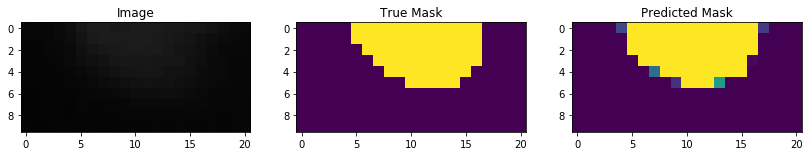

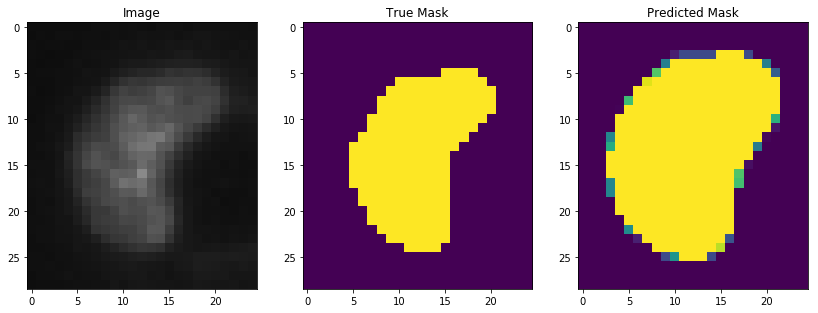

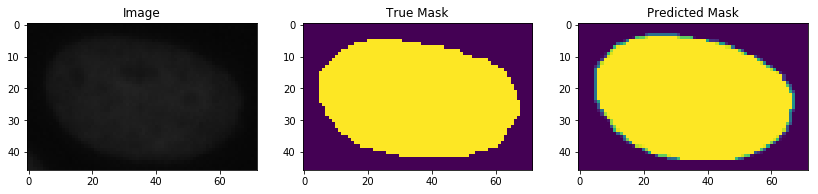

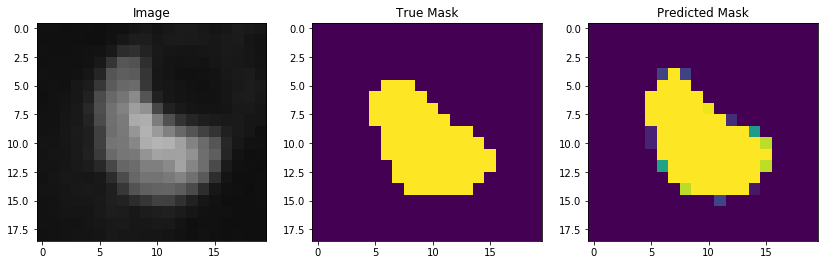

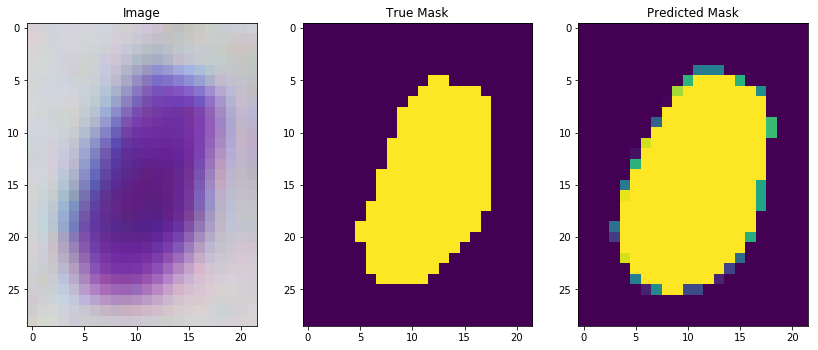

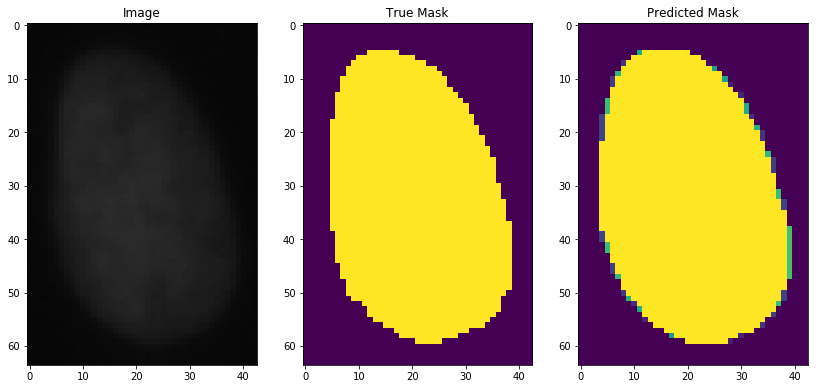

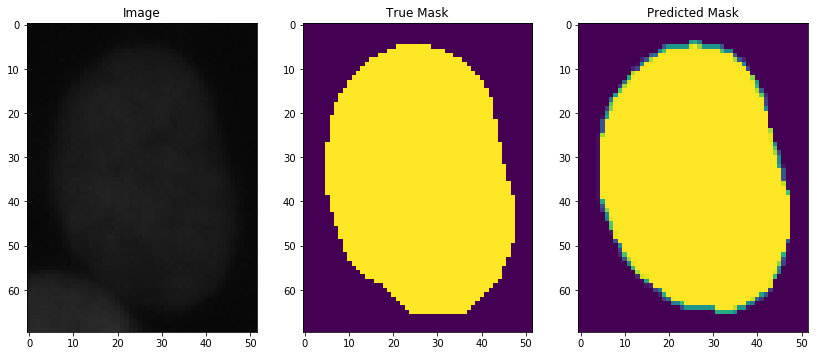

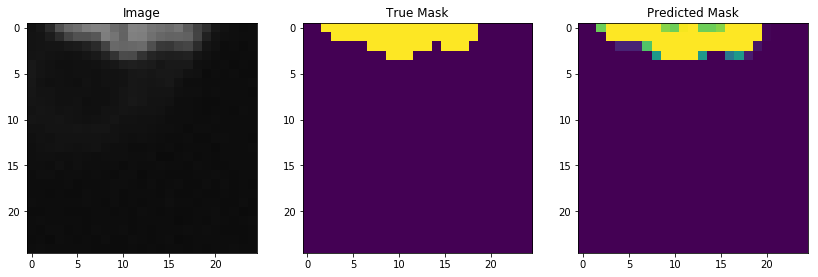

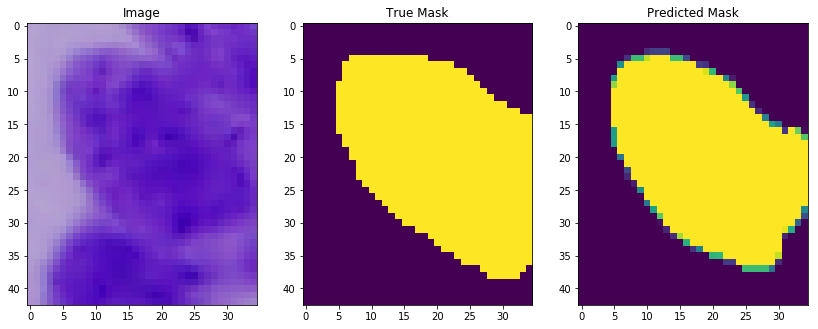

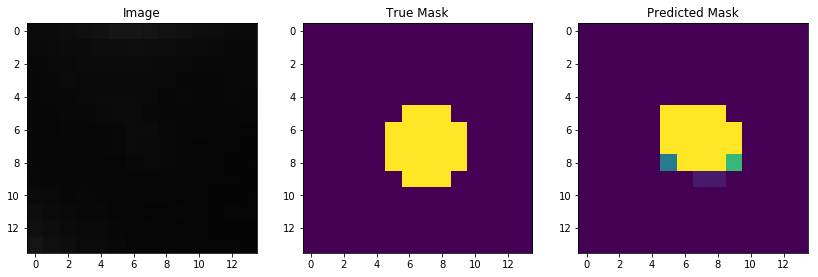

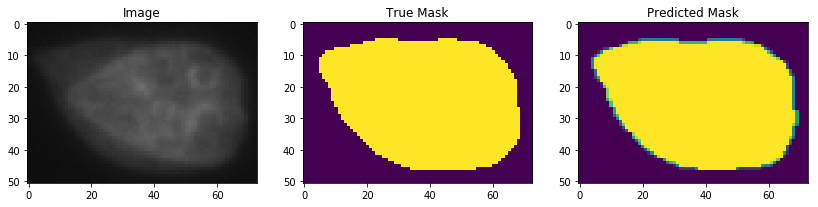

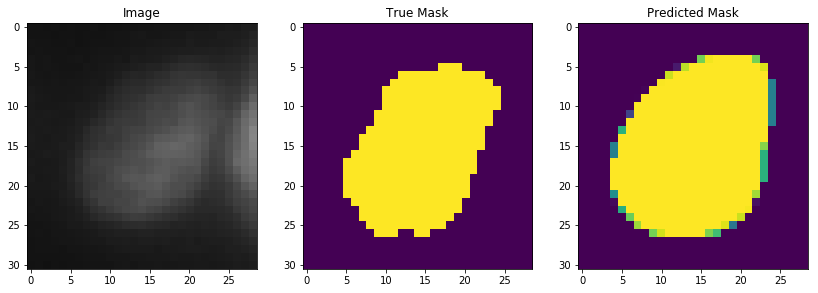

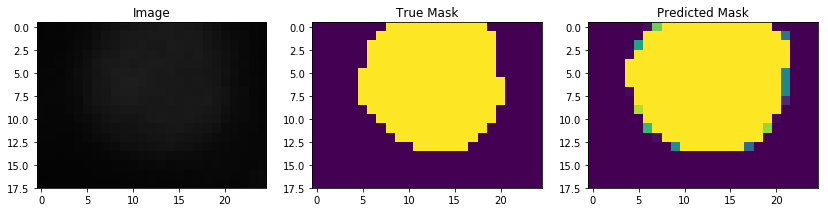

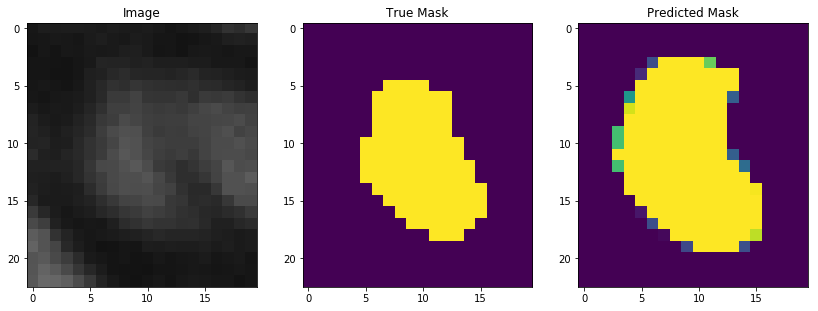

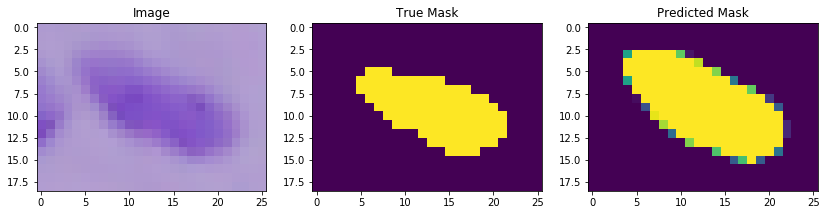

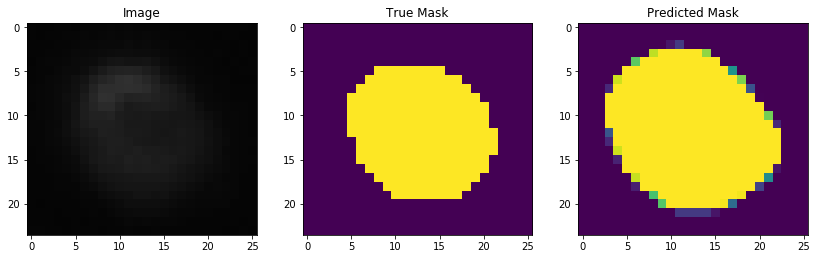

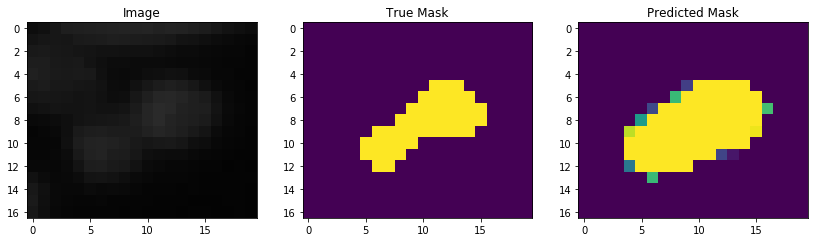

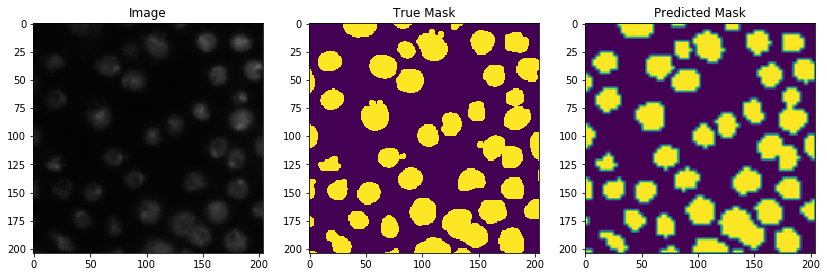

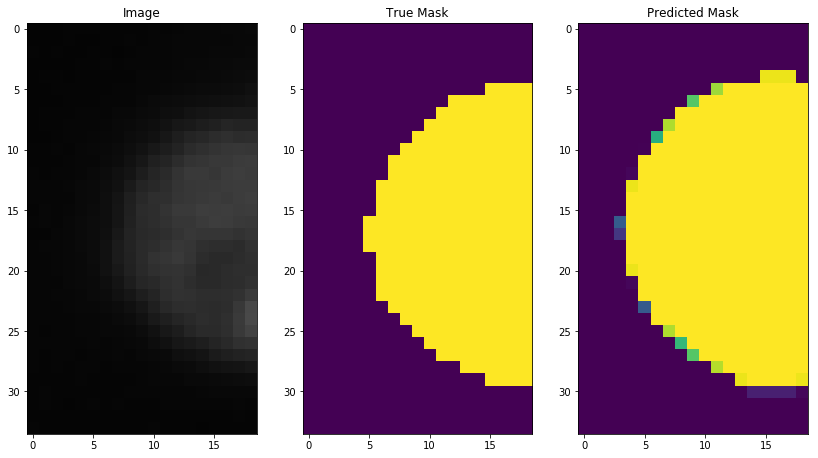

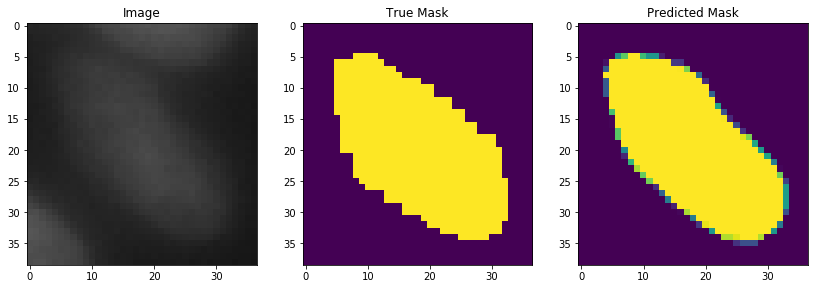

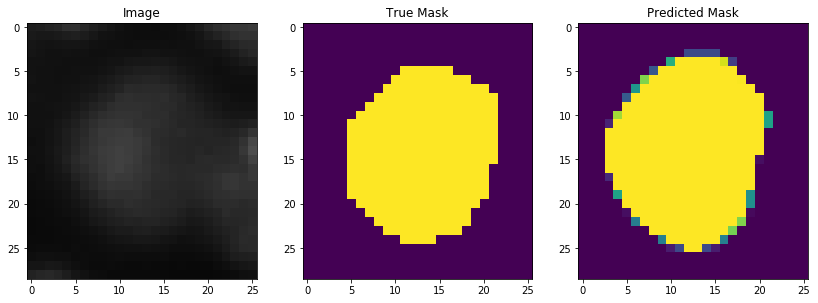

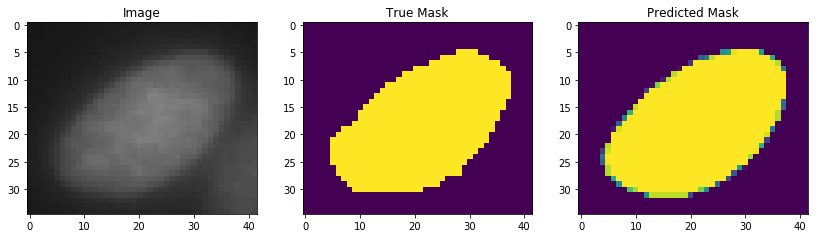

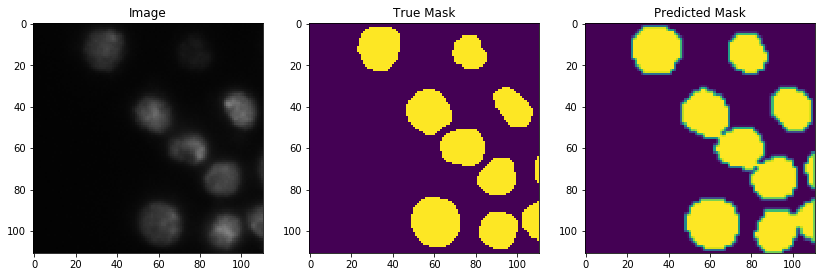

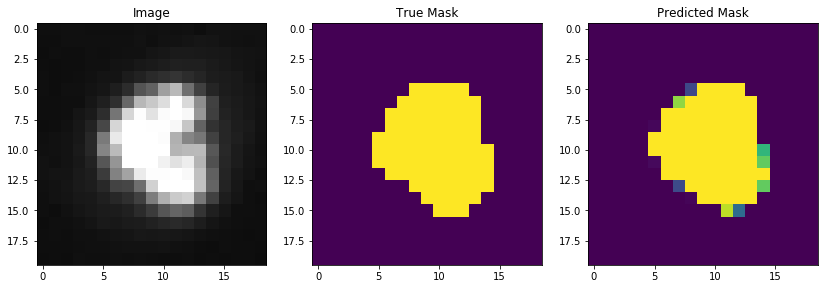

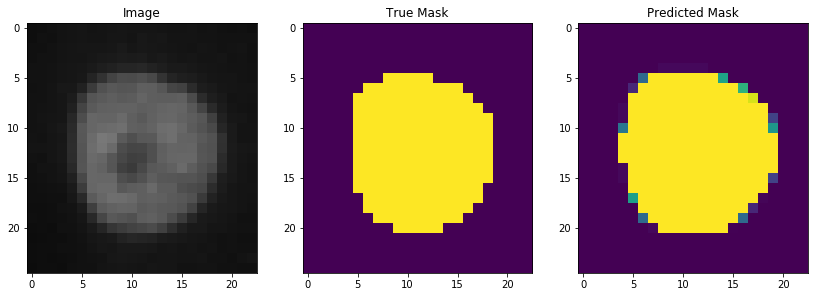

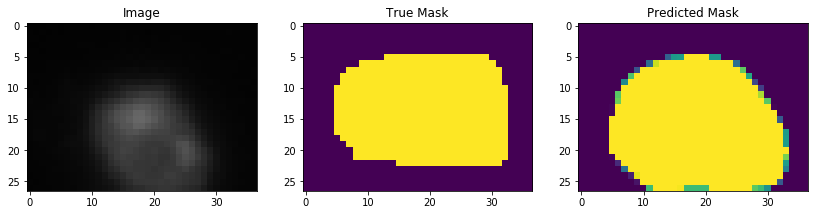

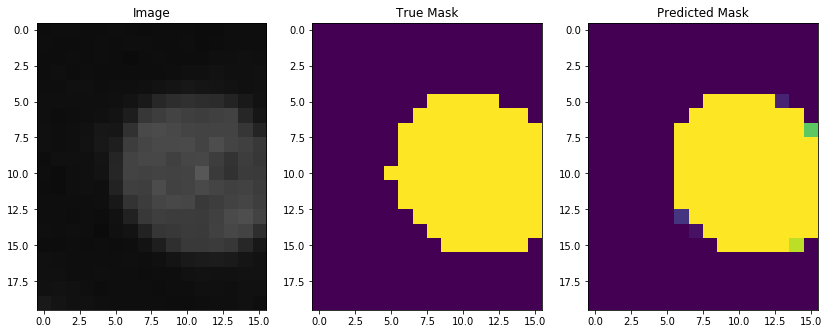

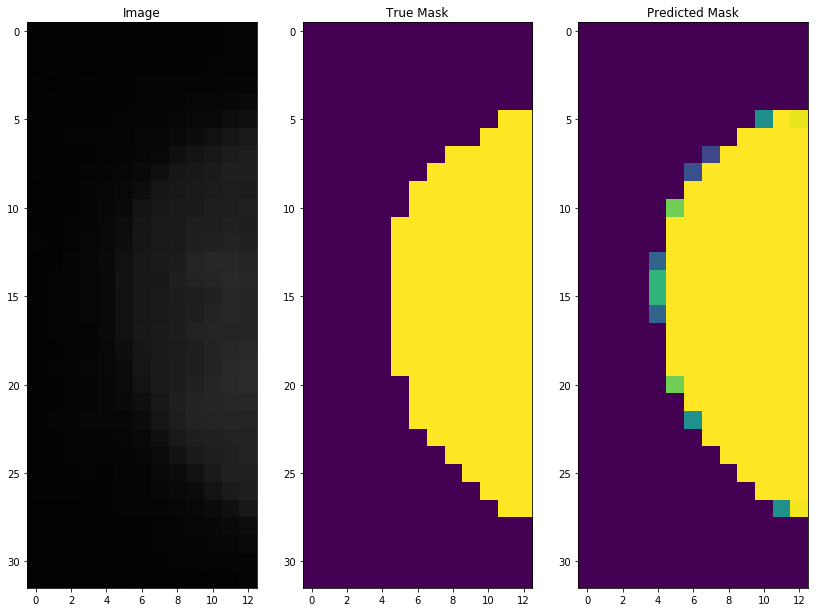

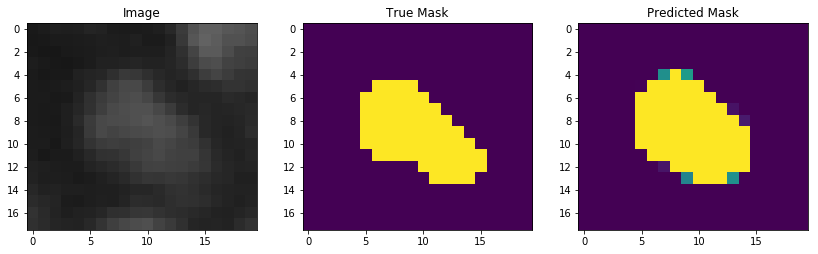

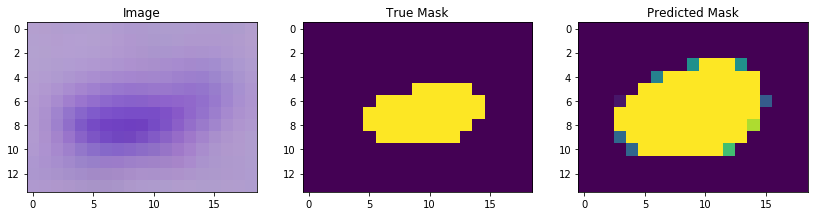

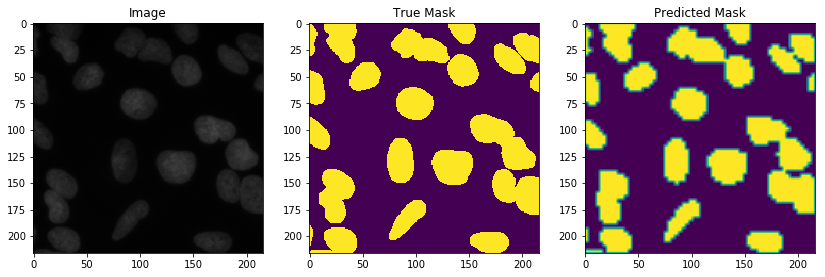

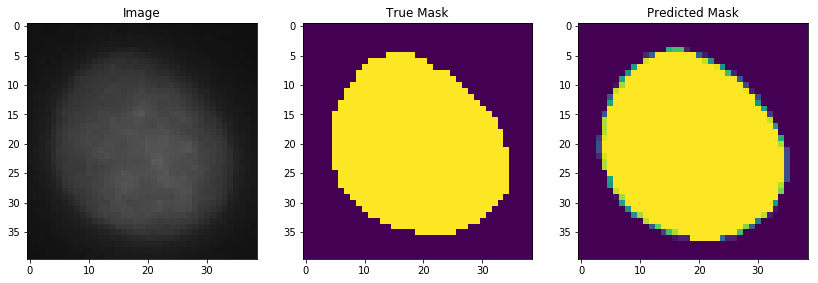

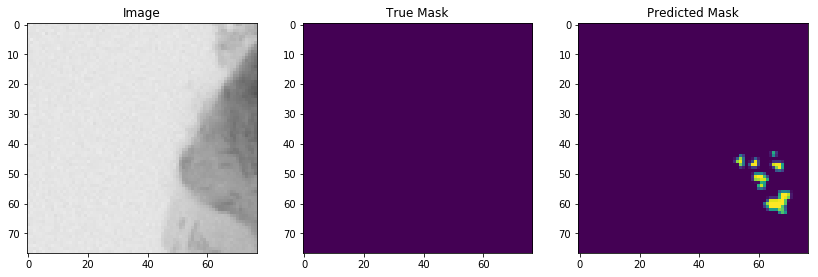

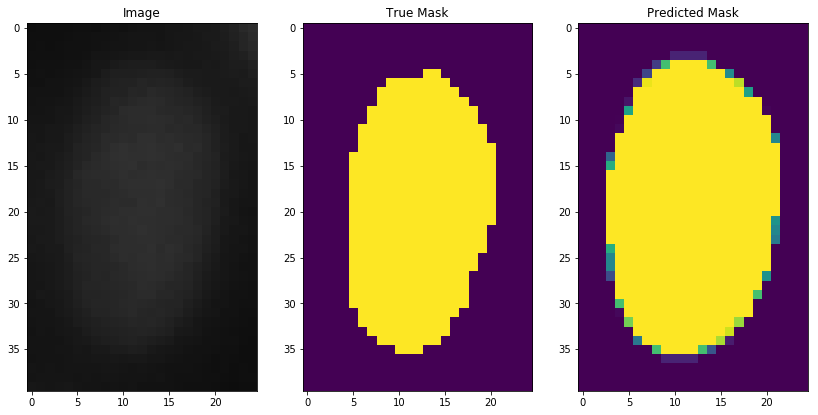

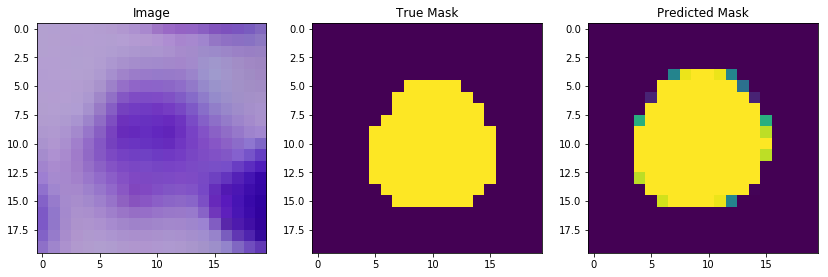

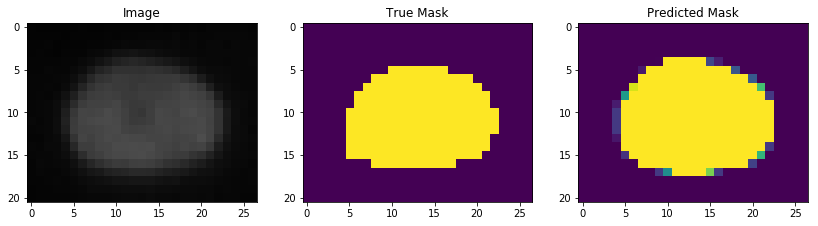

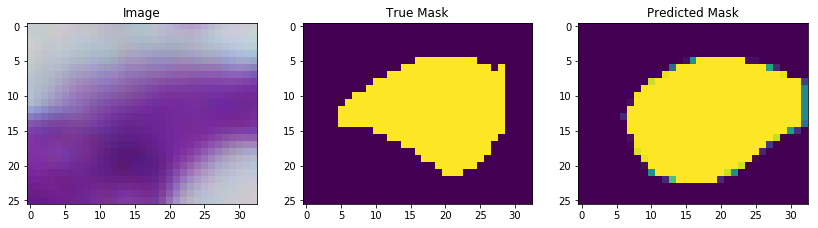

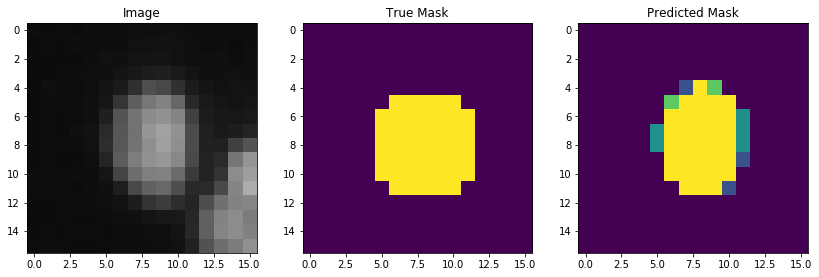

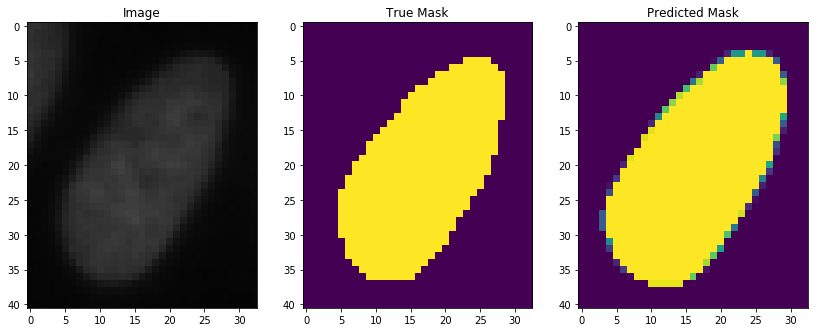

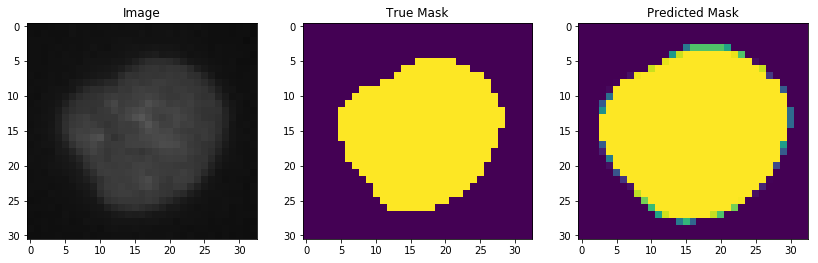

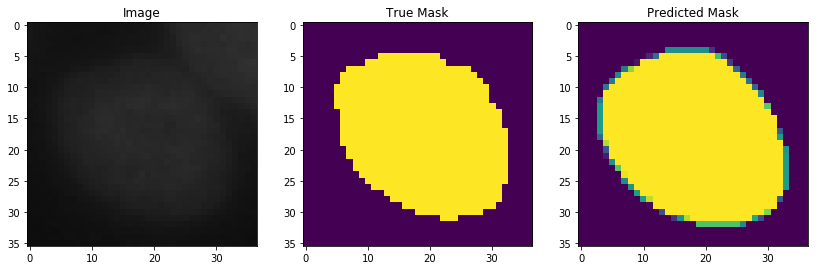

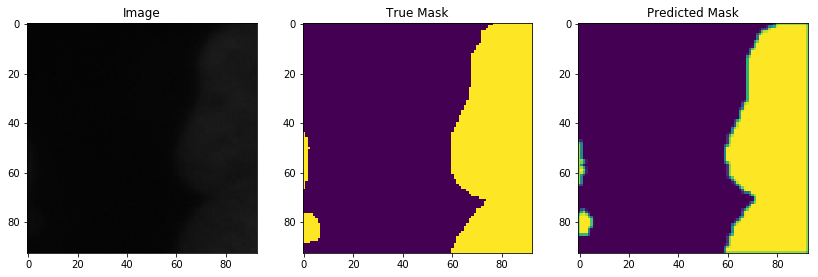

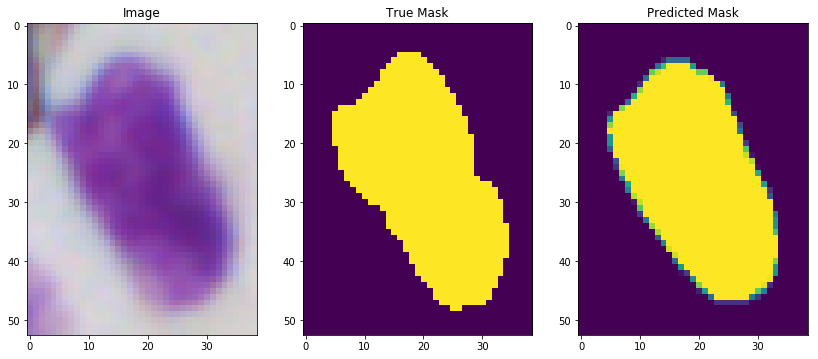

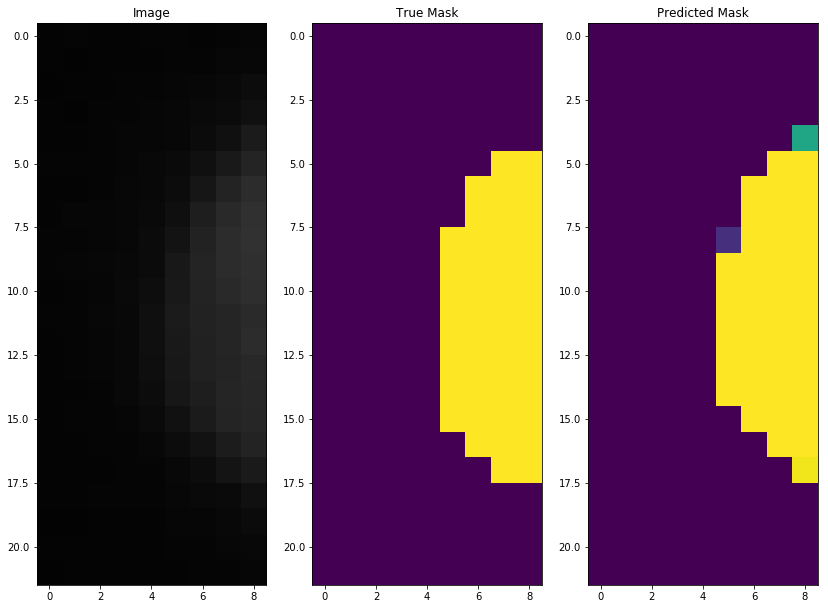

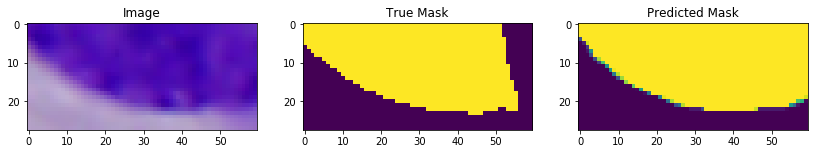

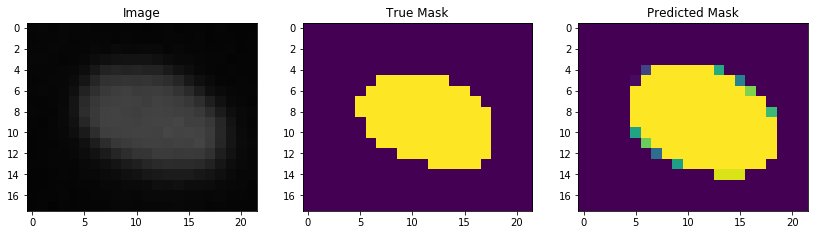

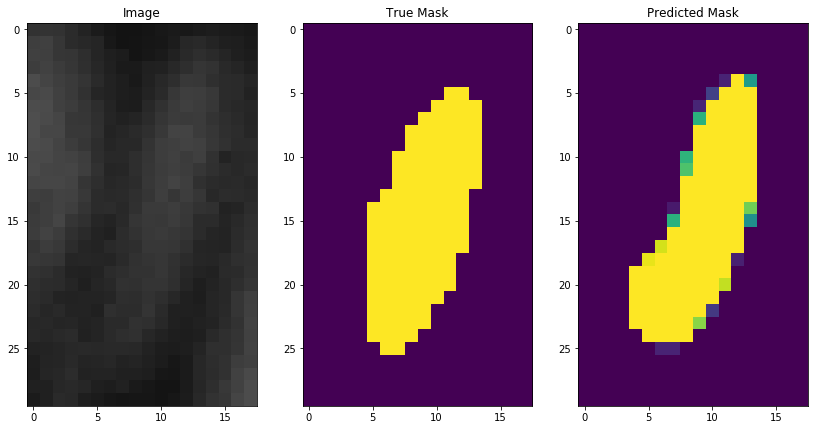

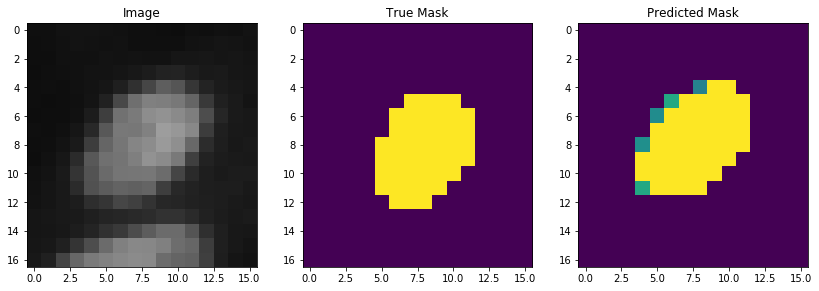

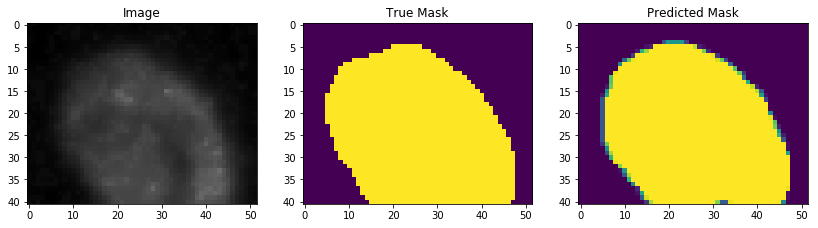

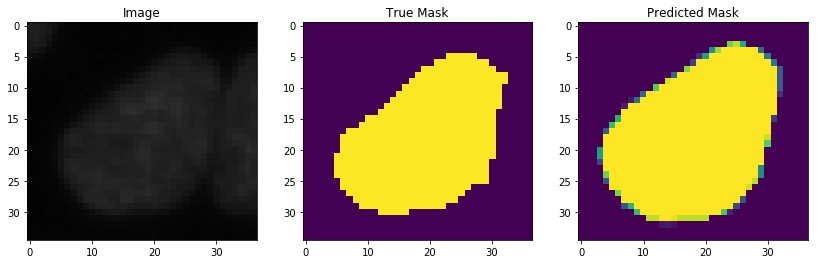

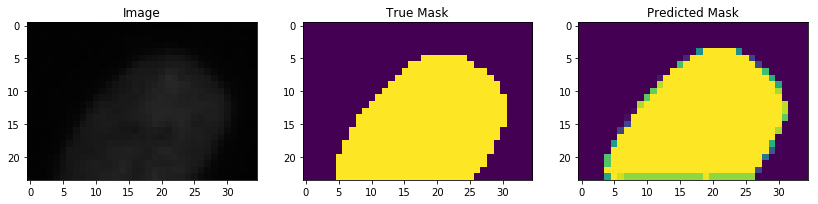

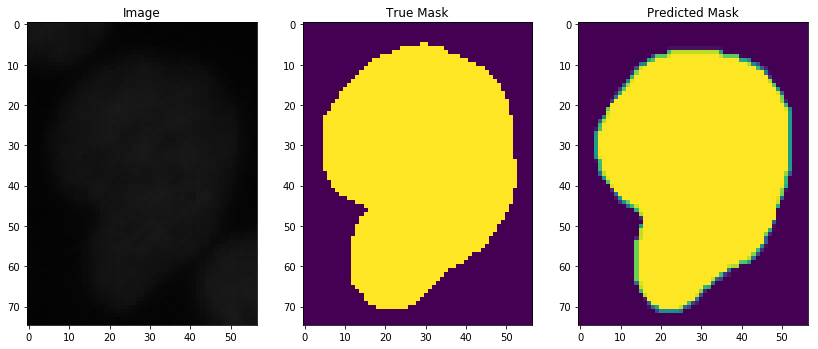

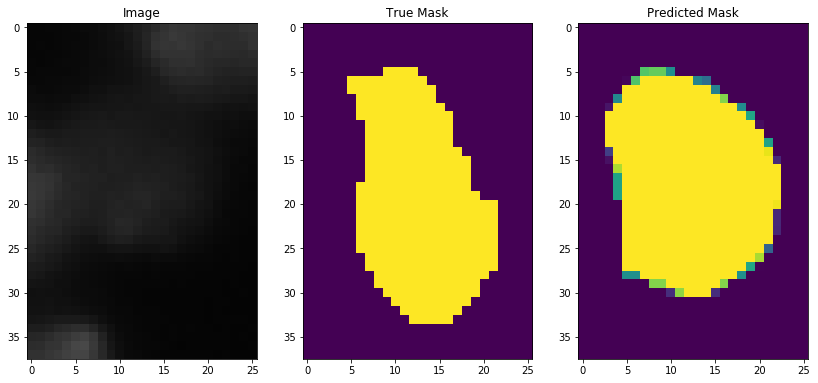

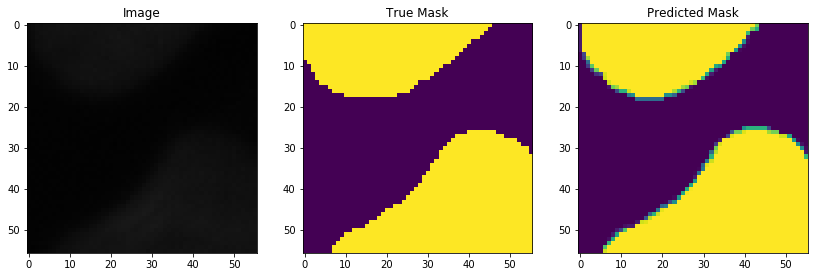

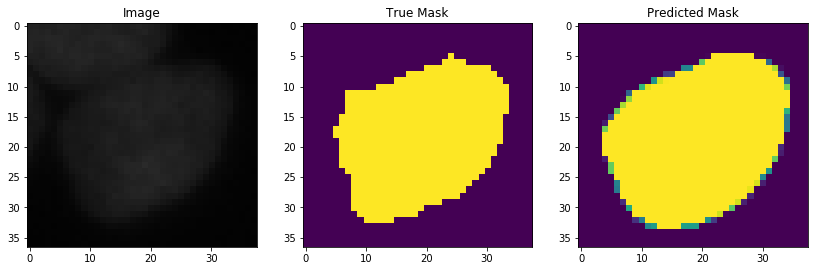

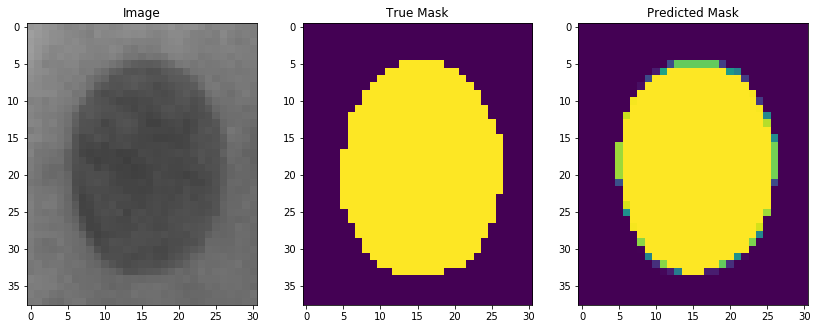

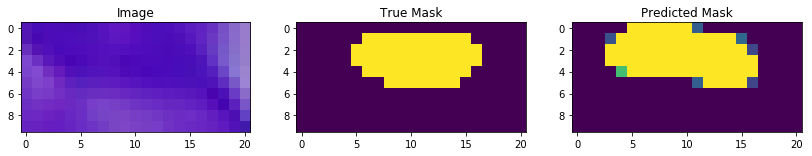

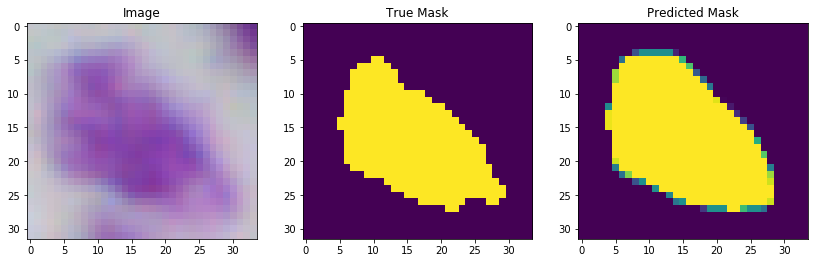

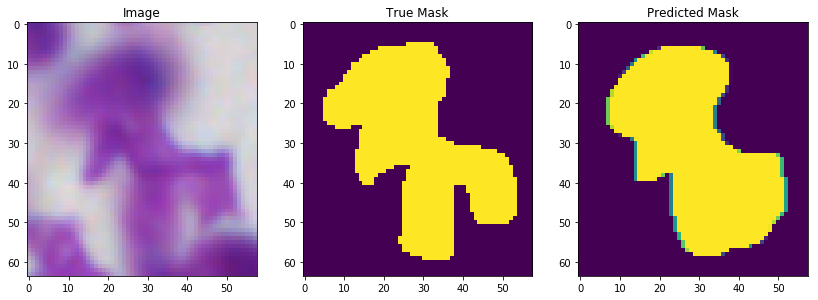

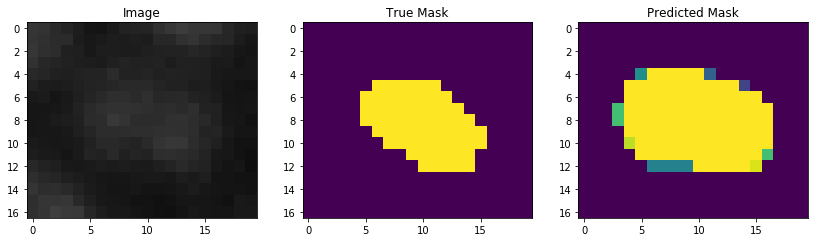

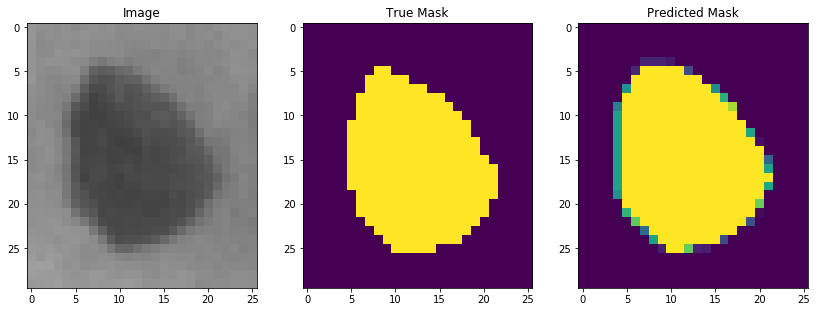

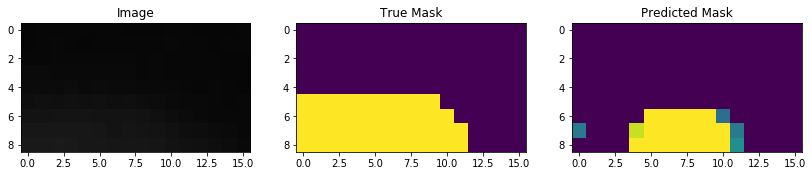

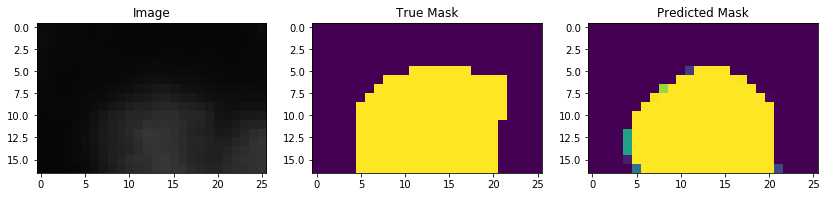

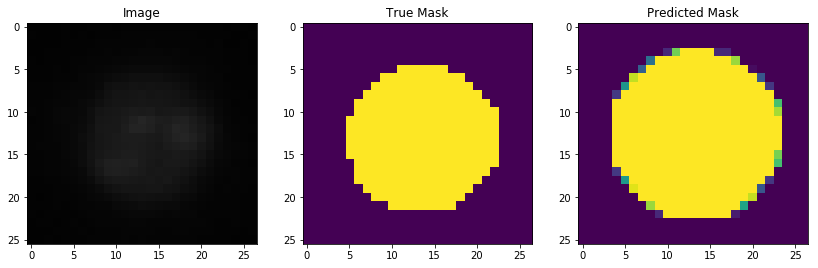

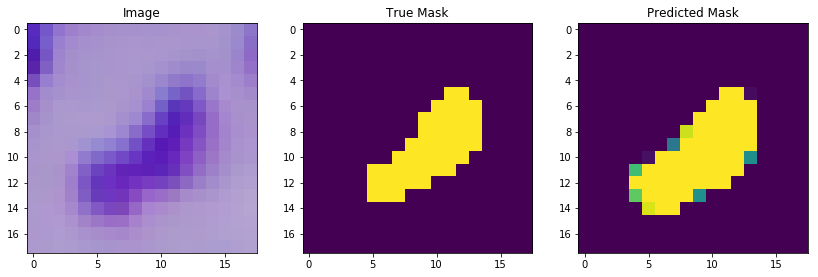

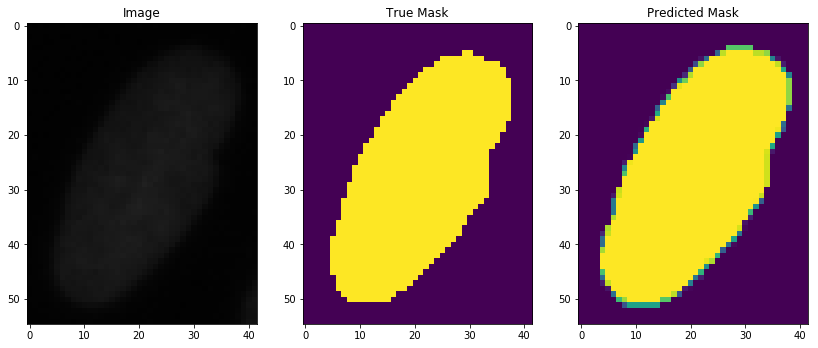

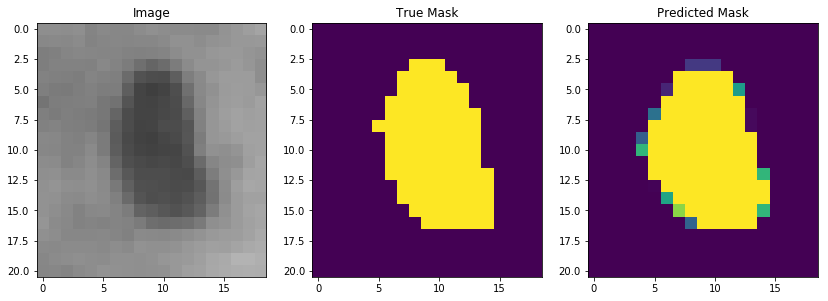

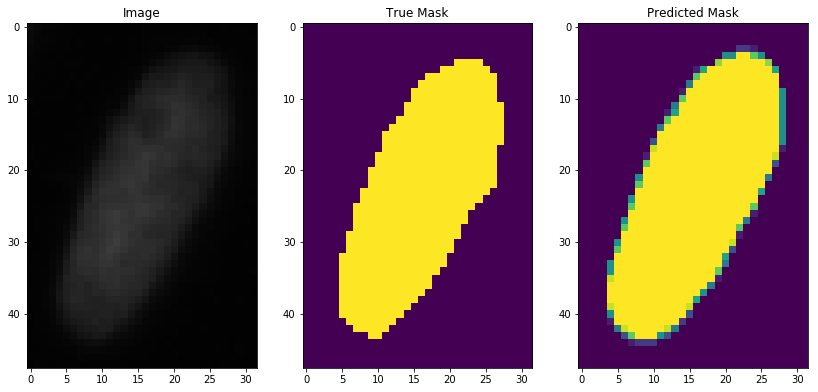

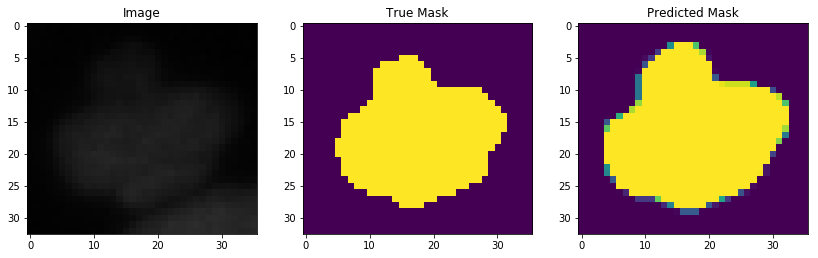

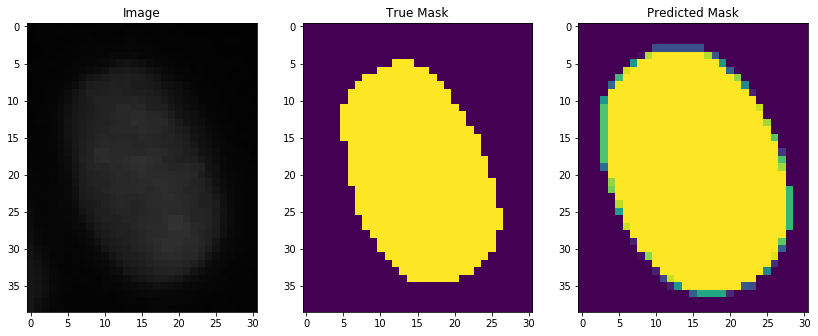

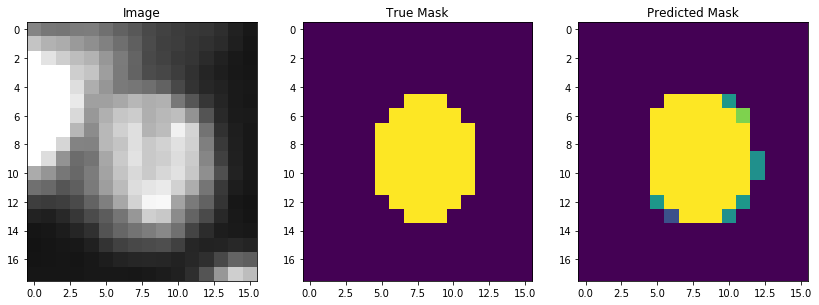

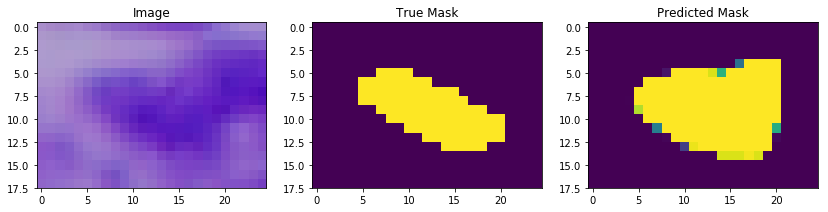

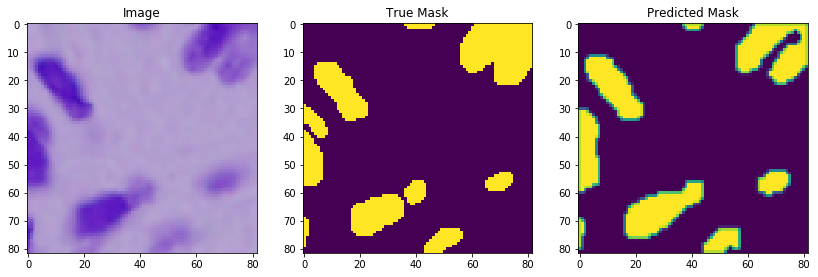

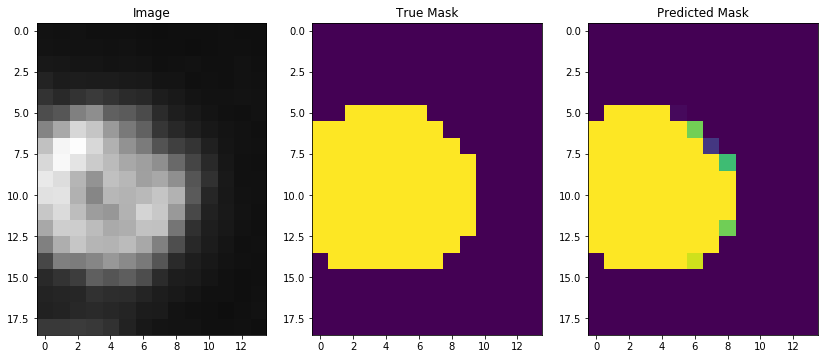

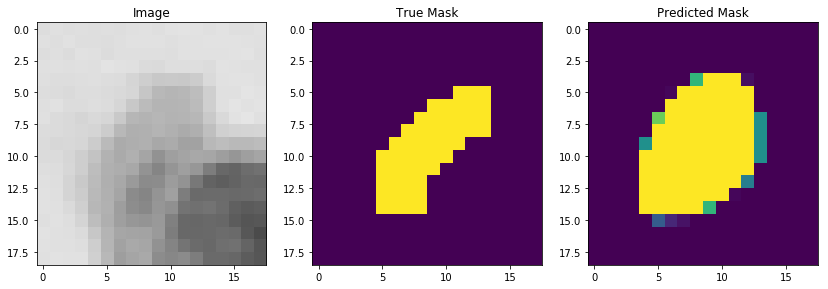

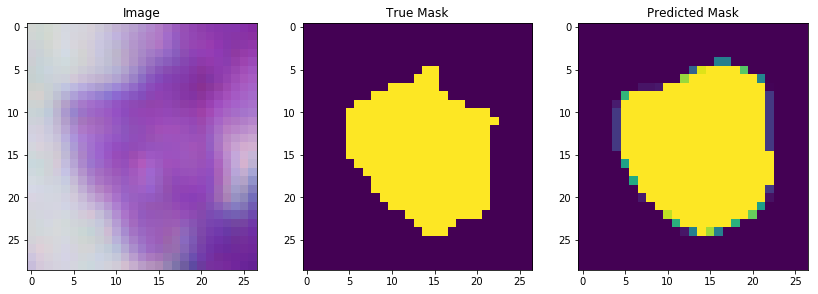

In [12]:
img_files = glob.glob('../data/image_mask_crops/*_img*')
img_files += glob.glob('../data/random_crops_mask/*img*.png')

train_img_files, valid_img_files = train_test_split(img_files, test_size=0.1, random_state=666)

def normalize_img(img_arr):
    img_min = np.min(img_arr)
    img_max = np.max(img_arr)
    img_mean = np.mean(img_arr)
    img_out = (img_arr - img_mean) / (img_max - img_min)
    return img_out

for fl in valid_img_files[:500]:
    img = imread(fl)
    msk = imread(fl.replace('img', 'msk')).astype(np.bool)

    img_for_net = normalize_img(resize(img, (64, 64), mode='constant', preserve_range=True))
    img_for_net = img_for_net.transpose((2,0,1)).reshape((1,3,64,64)).astype(np.float32)
    pred_msk = net(Variable(torch.from_numpy(img_for_net)))
    pred_msk = F.sigmoid(pred_msk)
    
    predicted_mask = np.where(pred_msk.data.numpy().squeeze() > 0.5, 1, 0).astype(np.int32)
    predicted_mask = resize(predicted_mask, (img.shape[0], img.shape[1]), mode='constant', preserve_range=True)
    
    plt.figure()
    plt.subplot(131)
    plt.title('Image')
    plt.imshow(img.squeeze())
    plt.subplot(132)
    plt.title('True Mask')
    plt.imshow(msk)
    plt.subplot(133)
    plt.title('Predicted Mask')
    plt.imshow(predicted_mask)
    plt.show()